# Household Income and Expenditure Survey

<br>

Ehsan Saboori Kenari

*Supervisor:* Mohamad Hoseini

<br>

In [1]:
#Importing required libraries
import pyodbc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
# import pyreadr
import re

import warnings # this will avoid showing warning in notebook
warnings.filterwarnings('ignore')

# set display format of dataframe
pd.options.display.float_format = '{:.3f}'.format
marker=['s','o','^','D','*','p', '+']
genderCode={'male':1, 'female':0}
collarCode={'white':0,'blue':1,'military':2}

In [2]:
# !pip install python-bidi
# !pip install arabic_reshaper
# from bidi.algorithm import get_display
# import arabic_reshaper

def farsi(x):
    reshaped_text = arabic_reshaper.reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text


In [3]:
%matplotlib inline

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 120

In [4]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

<br>

# Reading and preparing data set

## Reading HIES  rawdata downloaded from the Statistics Center of Iran. 

All the files are stored in a folder with path name filepath, <br>
and name of all raw data files are similiar in the format: "Outfile-{year}"

<br>

In [1]:

# filepath should be set to where all raw data are stored
filepath='E:/This_Term/Thesis other things/Data/HIES data/data'
os.chdir(filepath)

data=pd.DataFrame([])
income=pd.DataFrame([])

for year in np.arange(76,99):
    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'+
                      'DBQ= '+ filepath +'\Outfile-'+ str(year)+'.mdb')
    for area in ['U', 'R']:
        
        # reading table 1 that store demographics information of household member
        query='select * from ' + area + str(year) + 'P1'
        df = pd.read_sql(query, conn, columns=['Address'])
        
        # this object(or table) has 10 columns that differ their names in some years, but their order 
        # are the same. thus, I change their name to acoomodate with LFS(or EUS) data.
        df.columns=['household','person', 'relation', 'gender', 'age', 'literate',
                   'student', 'education', 'labor', 'marital' ]
        df=df.apply(pd.to_numeric, errors='coerce')
        df['year']=year
        if area=='U':
            df['RU']= 1
        else:
            df['RU']= 0
        df.dropna(subset=['person'], inplace=True)

        df=df.astype({'household':'int64','person':'int8', 'gender':'category',
                             'age':'float16', 'literate':'category', 'student':'category',
                             'education':'float16', 'labor':'category', 'marital':'category',
                             'year':'int8', 'RU':'int8'})   

        #######
        # reading income object from data for each year
        #######
        
        if year<=83:
            query='select * from ' + area + str(year) + 'P4S1'
        else:
            query='select * from ' + area + str(year) + 'P4S01'

        dfIncome = pd.read_sql(query, conn)
        
        if year<=83:
            colnames=dfIncome.filter(regex=re.compile("add|col01|col03|col13|col04", re.IGNORECASE)).columns
            dfIncome=dfIncome[colnames]
            dfIncome.columns=['household', 'person','occupation','job', 'income1']
            dfIncome['day']= 5
            dfIncome['hour']= 8
        else:
            colnames=dfIncome.filter(regex=re.compile("add|col01|col03|col15|col06|col07|col04", re.IGNORECASE)).columns
            dfIncome=dfIncome[colnames]
            dfIncome.columns=['household', 'person', 'occupation','job','hour','day' ,'income1']
        
        dfIncome=dfIncome.apply(pd.to_numeric, errors='coerce')
        dfIncome=dfIncome.astype({'occupation':'float16', 'income1':'float32'})
        
        ####################
        ## dropping second job of whom work in tow occupation
        

        
        #
        #
        #
        
        if year<=83:
            query='select * from ' + area + str(year) + 'P4S2'
        else:
            query='select * from ' + area + str(year) + 'P4S02'

        dfIncome2 = pd.read_sql(query, conn)
        
        if year<=83:
            colnames=dfIncome2.filter(regex=re.compile("add|col01|col03|col13|col04", re.IGNORECASE)).columns
            dfIncome2=dfIncome2[colnames]
            dfIncome2.columns=['household', 'person','occupation','job', 'income2']
            dfIncome2['day']= 5
            dfIncome2['hour']= 8
        else:
            colnames=dfIncome2.filter(regex=re.compile("add|col01|col03|col15|col06|col07|col04", re.IGNORECASE)).columns
            dfIncome2=dfIncome2[colnames]
            dfIncome2.columns=['household', 'person', 'occupation','job','hour','day' ,'income2']
        
        dfIncome2=dfIncome2.apply(pd.to_numeric, errors='coerce')
        dfIncome2=dfIncome2.astype({'occupation':'float16', 'income2':'float32'})        
        
        
        dfIncome= pd.merge(dfIncome, dfIncome2, on=['household','person'], how='outer', suffixes=['','_x'])
        
        dfIncome.loc[(dfIncome.occupation.isna()), 'occupation'] = dfIncome.occupation_x
        dfIncome.loc[(dfIncome.job.isna()), 'job'] = dfIncome.job_x
        
        dfIncome = dfIncome[['household', 'person','occupation','job','hour','day' ,'income1','income2']]
        
        #
        #
        #      
        
        
        dfIncome['year']=year
        if area=='U':
            dfIncome['RU']= 1
        else:
            dfIncome['RU']= 0
        
        
#         income=pd.concat([income, dfIncome])
        
        if year in [76, 77]:
            code = [76, 77]
        elif year in [96, 97, 98]:
            code = [510]
        else:
            code=[112]
            
        Mil = dfIncome.loc[(dfIncome.occupation.isin(code)),:]
        Other = dfIncome.loc[~(dfIncome.occupation.isin(code)),:]
        dfIncome = pd.concat([Mil,Other])
        
        dfIncome.drop_duplicates(subset=['household', 'person', 'year','RU'], inplace=True)
        
        ####################
        
        
        df= pd.merge(df, dfIncome, on=['household', 'person','year','RU'], how='left')        
        
        data=pd.concat([data,df])
        
        
# data.dropna(subset=['person'], inplace=True)
# data=data.astype({'household':'int64','person':'int8', 'gender':'category',
#                      'age':'float16', 'literate':'category', 'student':'category',
#                      'education':'float16', 'labor':'category', 'marital':'category',
#                      'year':'int8', 'RU':'int8'})       

# del df,dfIncome,dfIncome2


In [ ]:
data.loc[(data.year==year)&(data.occupation==112)&(data.gender==1),:].shape

In [ ]:
data.loc[(data.year==year)&(data.occupation==112)&(data.gender==1),:].shape

In [ ]:
# data.shape

# data.dtypes

# data.isna().sum()

# data.info(memory_usage='deep')

In [ ]:
for year in np.arange(76,99):
    print(f'year {year}: households:'
         , len(data[(data.year== year)].household.unique())
         , 'individuals:'
         , len(data[data.year== year]) )

<br>

## Reading weights of data from summary files in folder

<br>

In [ ]:
# filepath should be set to where all raw data are stored
filepath='E:/This_Term/Thesis other things/Data/HIES data/data'
os.chdir(filepath)
weight=pd.DataFrame([])
  
for year in np.arange(76,83):
    for area in ['R','U']:
        df = pd.read_csv(f'E:\This_Term\Thesis other things\Data\HIES data\data\weight\Sum_{area}{year}.csv')
        # the column that store weight have different name in different years. here we select the column that
        # has the characters "eight" in it. (which includes in all names.)
        a=df.filter(regex='eight').columns
        df.rename(columns={a[0] :'weight'}, inplace=True)  # rename that column to 'weight'
        df['year']=year
        if area=='U':
            df['RU']= 1
        else:
            df['RU']= 0
        #######
        # the ADDRESS(or household in our codes) doesn't match to other objects from rawdata in
        # years 77 to 83. but based on format that Address name of each household is made in data,
        # we are able to build this Address. (how Addrees of each household is made is written in the first
        # page of survey questionare.)
        #######
        if year==76:
            df['household']= (df.KHANEVAR.astype(str).str[0:1]+ df.KHANEVAR.astype(str).str[2:]).astype(np.int64)+ \
                          df.OSTAN* 10000 + df.RU*1000000
        else:
            df['household']= (df.KHANEVAR.astype(str).str[0:1]+ df.KHANEVAR.astype(str).str[2:]).astype(np.int64)+ \
                    df.SHAHRESTAN* 10000 + df.OSTAN* 1000000 + df.RU*100000000
        # we just take required columns from data!
        df=df[['household', 'RU', 'year', 'weight']]
        
        weight=pd.concat([weight, df])

######
# in years 83 to 95, the ADDRESS of each household math to their Address number
# in other objects. hence we read them seperately and concatenate them to weight 
# dataframe created above.
######
for year in np.arange(83,96):
    for area in ['R','U']:
        df = pd.read_csv(f'E:\This_Term\Thesis other things\Data\HIES data\data\weight\Sum_{area}{year}.csv')
        df=df.filter(regex='Add|ADDRESS|KHAN|eight')
        df.columns=['household', 'weight']
        df['year']=year
        if area=='U':
            df['RU']= 1
        else:
            df['RU']= 0
                
        weight=pd.concat([weight, df])

######
# for years 96 and 97 however, the wight is included in the data set downloaded form
# webpage of Satistics Center of Iran.
######
for year in [96,97,98]:
    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'+
                      'DBQ= '+ filepath +'\Outfile-'+ str(year)+'.mdb')
    for area in ['R','U']:
        query='select * from ' + area + str(year) + 'Data'
        df = pd.read_sql(query, conn)
        df= df[['Address', 'weight']]
        df.rename(columns={'Address':'household'}, inplace=True)
        df=df.apply(pd.to_numeric, errors='coerce')
        
        df['year']=year
        if area=='U':
            df['RU']= 1
        else:
            df['RU']= 0
        
        weight=pd.concat([weight, df])
        
del df       

<br>

## Merge the raw data with weight dataframe



In [ ]:
data=pd.merge(data, weight, on=['household','year','RU'], how='left')

data=data.astype({'gender':'category', 'hour':'float16', 'day':'float16',
                  'job':'float16', 'relation':'int8', 'weight':'float16', 'student':'category'})
# del weight

In [ ]:
# data.info(memory_usage='deep')

# Read cleaned data

In [6]:
# !pip install pyarrow
# data.to_feather(r"E:\This_Term\Thesis other things\Data\data2.file")
try:
    # windows 10
    data=pd.read_feather(r"E:\This_Term\Thesis other things\Data\data2.file")
except:
    # ubuntu
    data=pd.read_feather(r"/media/ehsan/New Volume/This_Term/Thesis other things/Data/data2.file")


# changing data type:
# default data.file columns format is as follows
# thus there is no need to run the following code:
# data=data.astype({'gender':'category', 
#                   'hour':'float16', 
#                   'day':'float16',
#                   'job':'float16', 
#                   'relation':'int8', 
#                   'weight':'float16', 
#                   'student':'category'})

In [7]:
data.dtypes

household        int64
person            int8
relation          int8
gender        category
age            float16
literate      category
student       category
education      float16
labor         category
marital       category
year              int8
RU                int8
occupation     float16
job            float16
hour           float16
day            float16
income1        float32
income2        float32
weight         float16
dtype: object

<br>

## Define new columns

<br>

In [8]:
###########################################################
# data.drop(columns=['participation'])
data.loc[(data['labor'].isin([1,2])), 'participation']=1
data.loc[(data['labor'].isin([3,4,5,6])), 'participation']=0
data.loc[(data['age']<16),'participation']=np.nan
# data.loc[(data['age']>65),'participation']=np.nan
data['participation']= data.participation.astype('category')

###########################################################
# unemployed note that for ages and in school individual it may work wrong 
data.loc[data.labor==2, 'unemployement']= 1
data.loc[data.labor==1, 'unemployement']= 0
data.loc[(data['age']<16),'unemployement']=np.nan
# data.loc[(data['age']>65),'unemployement']=np.nan
data['unemployement']= data.unemployement.astype('category')

###########################################################
# collar is occupation type of emplyed individual
data.loc[(data.occupation<5000)
         &(data.occupation>=1000)&
         (data.year>77) , 'collar']= 0 # white-collar 
data.loc[(data.occupation>=5000)&(data.year>77), 'collar']= 1 #blue collar
data.loc[(data.occupation<1000)&(data.year>77),'collar']= 2 # military

data.loc[(data.occupation<500)
         &(data.occupation>=100)&
         (data.year<=77) , 'collar']= 0 # white-collar 
data.loc[(data.occupation>=500)&(data.year<=77), 'collar']= 1 #blue collar
data.loc[(data.occupation<100)&(data.year<=77),'collar']= 2 # military
data['collar']= data.collar.astype('category')

###########################################################
# changing student code: 1 is student and 0 if not student
data['student']= data.student.astype('float16')
data.loc[data.student==2,'student']=0
data['student']= data.student.astype('category')

###########################################################
# changing gender code: 1 male and 0 for female
data['gender']= data.gender.astype('float16')
data.loc[data.gender==2,'gender']= 0
data['gender']= data.gender.astype('category')

###########################################################
# birth year of each individual
data['birth_y']= data['year']-data['age']

###########################################################
data.loc[(data.marital==1), 'married']= 'married'
data.loc[(data.marital.isin([2,3,4])), 'married']= 'single'
data= data.astype({'married':'category'})

###########################################################
# define educated
# data.loc[(data.year.isin([85,86,87,88,89,90,91,92])) , 'education'] = data.education / 10
# data.loc[(data.year.isin([97])) , 'education'] = data.education * 10

# data.loc[(data.literate==2), 'educated'] = 0
# data.loc[(data.education<50) , 'educated'] = 0
# data.loc[(data.education>=50) , 'educated'] = 1
# data.loc[(data.year>=93)&(data.year<=96)&(data.education==71), 'educated'] = 0

# data.loc[(data.education.isna())&(data.literate!=2) , 'educated'] = np.nan



In [9]:
#####################################################################
# define education level frome education code
#####################################################################
data.loc[(data.year<=84)
         &(data.education<=21),"educLevel"] = 5
data.loc[(data.year<=84)
         &(data.education.isin([22,23,24,25])),"educLevel"] = 8
data.loc[(data.year<=84)
         &(data.education.isin([26,27,28,29,30,31,32,33,
                                34,38,40,41,42,43,44,45,
                                46,47,92,93])),"educLevel"] = 11
data.loc[(data.year<=84)
         &(data.education.isin([39,35,48,49])),"educLevel"] = 12
data.loc[(data.year<=84)
         &(data.education.isin([51,52,61,62,94])),"educLevel"] = 16
data.loc[(data.year<=84)
         &(data.education.isin([71,72,73])),"educLevel"] = 18
data.loc[(data.year<=84)
         &(data.education.isin([75,76])),"educLevel"] = 22
data.loc[(data.year<=84)
         &(data.education.isin([77,78])),"educLevel"] = 24
data.loc[(data.year<=84)
         &(data.education.isin([81,82,83,85,86,87,89,91])),"educLevel"] = np.nan

####################################################
####################################################
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==11),"educLevel"] = 5
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==21),"educLevel"] = 8
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==31),"educLevel"] = 11
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==41),"educLevel"] = 12
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==51),"educLevel"] = 14
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==52),"educLevel"] = 16
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==53),"educLevel"] = 18
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==61),"educLevel"] = 22
data.loc[(data.year<=96)
         &(data.year>=93)
         &(data.education==71),"educLevel"] = np.nan
####################################################
####################################################
data.loc[(data.year.isin([97,98]))
         &(data.education==1),"educLevel"] = 5
data.loc[(data.year.isin([97,98]))
         &(data.education==2),"educLevel"] = 8
data.loc[(data.year.isin([97,98]))
         &(data.education==3),"educLevel"] = 11
data.loc[(data.year.isin([97,98]))
         &(data.education==4),"educLevel"] = 12
data.loc[(data.year.isin([97,98]))
         &(data.education==5),"educLevel"] = 14
data.loc[(data.year.isin([97,98]))
         &(data.education==6),"educLevel"] = 16
data.loc[(data.year.isin([97,98]))
         &(data.education==7),"educLevel"] = 18
data.loc[(data.year.isin([97,98]))
         &(data.education==8),"educLevel"] = 22
data.loc[(data.year.isin([97,98]))
         &(data.education==9),"educLevel"] = np.nan
####################################################
####################################################
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education<200),"educLevel"] = 5
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education>=200)
         &(data.education<300),"educLevel"] = 8
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education>=300)
         &(data.education<500),"educLevel"] = 12
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education>=500),"educLevel"] = 16
# data.loc[(data.year<=92)
#          &(data.year>=85)
#          &(data.education.isin([513,514,515])),"educLevel"] = 18
# data.loc[(data.year<=92)
#          &(data.year>=85)
#          &(data.education.isin([516,517])),"educLevel"] = 18
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education>=600)
         &(data.education<700),"educLevel"] = 22
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education.isin([605,606,515,510,520,310])),"educLevel"] = np.nan

####################################################
####################################################
data.loc[(data.literate==2), "educLevel"] = 0


In [10]:
data.loc[(data.year<=92)
         &(data.year>=85)
         &(data.education>90)
         |(data.education.isin([60.5,60.6,51.5,51.0,52.0,31.0])), "educated"] = np.nan
data.loc[(data.year<=84)
         &(data.education.isin([81,82,83,85,86,87,89,91])),"educated"] = np.nan
data.loc[(data.year>=93)&(data.year<=96)&(data.education==71), 'educated'] = np.nan
data.loc[(data.year==97)&(data.education==90), 'educated'] = np.nan

In [11]:
## define educated ##
# data.drop(columns=["educated"],inplace=True)
data.loc[data.educLevel>12, "educated"]= 1
data.loc[data.educLevel<=12, "educated"]= 0

In [12]:
data= data.astype({"weight":"float64"})

# sarbaz=data.loc[(data.year==90)&(data.occupation==112) , :].weight.sum()
# kol =  data.loc[(data.year==90) ,:].weight.sum()
# sarbaz/kol*100

<br>

## Size of each household

In [13]:
# tedad= pd.DataFrame(data[(data.year== 90)].household.value_counts()
#             ).rename(columns={'household':'size'})

## Initial Conditions

In [14]:
cohort = [60,61,62,63,64,65]
# cohort = [66,67,68,69,70,71]

data.loc[(data.age==16)
         &(data.birth_y.isin(cohort))
         &(data.gender==1) ,:].educLevel.value_counts(normalize=True)

11.000   0.519
8.000    0.243
5.000    0.204
0.000    0.026
12.000   0.007
16.000   0.001
Name: educLevel, dtype: float64

In [15]:
for educ in [0,5,8,11,12]:
    a=data.loc[(data.age==16)
             &(data.birth_y.isin(cohort))
             &(data.gender==1)
             &(data.educLevel==educ) ,"weight"].sum()
    b=data.loc[(data.age==16)
         &(data.birth_y.isin(cohort))
         &(data.gender==1)
         &(data.educLevel.notna()) ,"weight"].sum()
    share = a / b
    print("education level= ",educ,", share= ",share)

education level=  0 , share=  0.021522525968145034
education level=  5 , share=  0.18377399670122416
education level=  8 , share=  0.2307326902496617
education level=  11 , share=  0.5544224237735104
education level=  12 , share=  0.008672805873880631


In [16]:
# data.loc[(data.age==16)
#          &(data.birth_y.isin(cohort))
#          &(data.gender==1)
#          &(data.student==1),:] .educLevel.value_counts(normalize=True)

In [17]:
0.30990541912091596 + 0.34422847006593216

0.6541338891868481

In [18]:
0.138 +0.185 +0.654-1

-0.02299999999999991

<br>

# Analysis of data


In [19]:
# wm is weighted mean function required for grouping when data have missingv value
# since python don't have average function like R, we create this function

wm = lambda x: np.ma.average(np.ma.masked_array(x.to_numpy(dtype="float64", na_value=np.nan),x.isna()), 
                             weights=data.loc[x.index, "weight"])

wmPanel = lambda x: np.ma.average(np.ma.masked_array(x, np.isnan(x)),
                          weights=panel.loc[x.index, "weight"])

wmincome = lambda x: np.ma.average(np.ma.masked_array(x.to_numpy(dtype="float64", na_value=np.nan),x.isna()),
                          weights=income.loc[x.index, "weight"])

import math
def wmDev(x):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    values = np.ma.masked_array(x.to_numpy(dtype="float64", na_value=np.nan),x.isna())
    average = np.average(values, weights=data.loc[x.index, "weight"])
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=data.loc[x.index, "weight"])
    return (math.sqrt(variance))

<br>

## By year

<br>

In [23]:
# merge=merge.astype({'participation':'float64', 'unemployement':'float64'})
groupYear=data.groupby(by=['year']).agg({'participation':wm,
                                        'unemployement':wm}).reset_index()

<br>

*graph*: **participation and unemployement rate of 18 years old and older between 76-97**

<br>

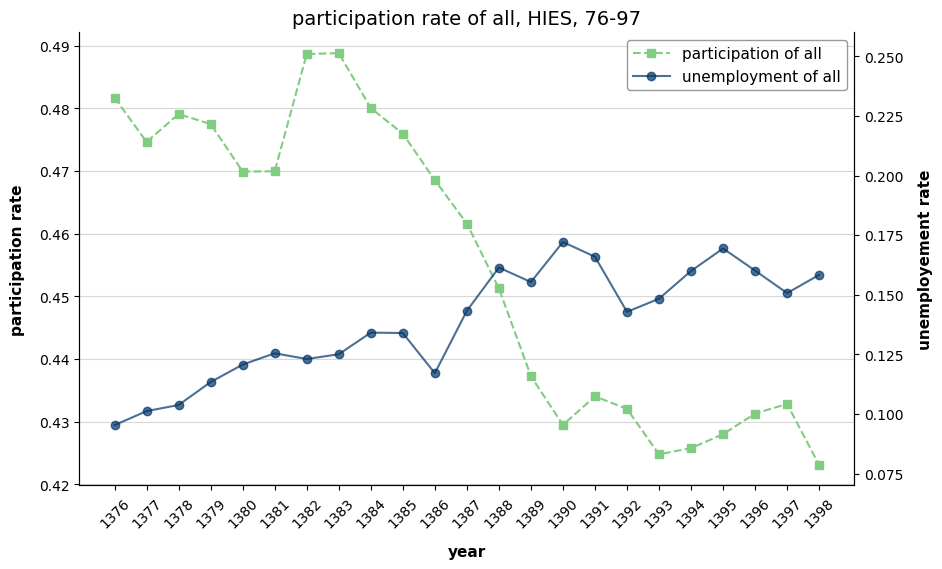

In [24]:
# plot unemployement and participation rate of all between 76-96

fig=plt.figure(figsize=(10,6))
ax1= fig.add_subplot(1,1,1)
line1= ax1.plot('year', 'participation', '--s',color=(0.5,0.8,0.5,1),
        data=groupYear,
        label='participation of all')

ax1.set_ylabel('participation rate',fontsize=11,labelpad=10,fontweight='bold')
# ax1.set_ylim(0.28,0.45)
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)


ax2=ax1.twinx()
line2= ax2.plot('year', 'unemployement', '-o', color=(0,0.2,0.4,0.7) ,
        data=groupYear,
        label='unemployment of all')

ax1.set_title('participation rate of all, HIES, 76-97',fontsize=14)
ax1.set_xlabel('year',fontsize=11,labelpad=10,fontweight='bold')
ax2.set_ylabel('unemployement rate',fontsize=11,labelpad=10,fontweight='bold')
ax2.set_ylim(0.07,0.26)


lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc='best',edgecolor='gray',prop={'size':11}, handlelength=2.4)
ax1.grid(axis='y',alpha=0.5)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

<br>

## By year and gender

<br>

In [25]:
groupYearGender=data.groupby(by=['year','gender']).agg({'participation':wm,'unemployement':wm}).reset_index()

<br>

*graph*: **Uneployement rate men and women**


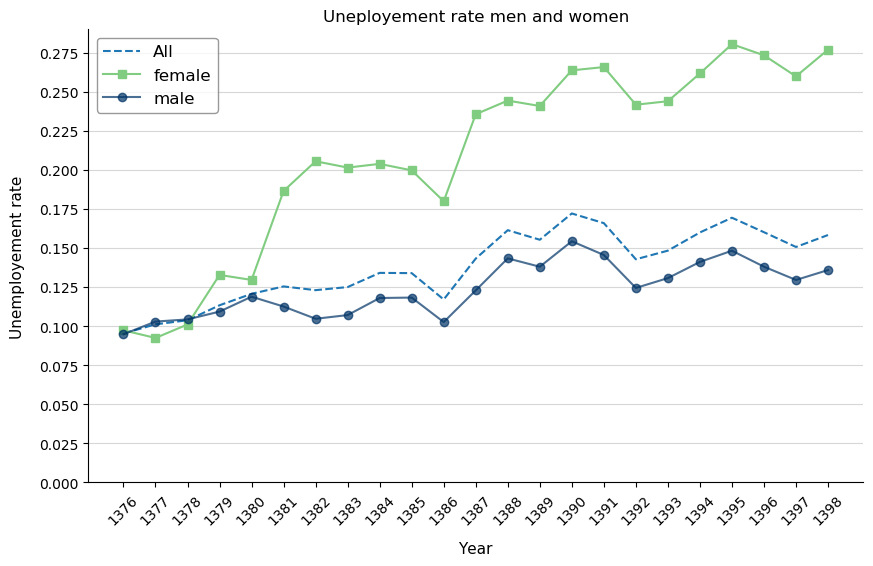

In [26]:
fig=plt.figure(figsize=(10,6))
ax1= fig.add_subplot(1,1,1)

ax1.plot('year','unemployement','--',
         data=groupYear,
        label='All')

for index,gender in enumerate(['female','male']):

    ax1.plot('year','unemployement',
            data=groupYearGender[(groupYearGender['gender']==genderCode[gender])],
            label=f'{gender}',
            marker= marker[index],
            color=(0,0.2,0.4,0.7) if gender=='male' else (0.5,0.8,0.5,1))

ax1.set_xlabel('Year', fontsize=11,labelpad=10,fontweight='regular')
ax1.set_ylabel('Unemployement rate', fontsize=11,labelpad=10,fontweight='regular')
ax1.set_title('Uneployement rate men and women')
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)

# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

plt.show()
# figure.savefig('./output/')

<br>

*graph*: **participation rate of men and women**


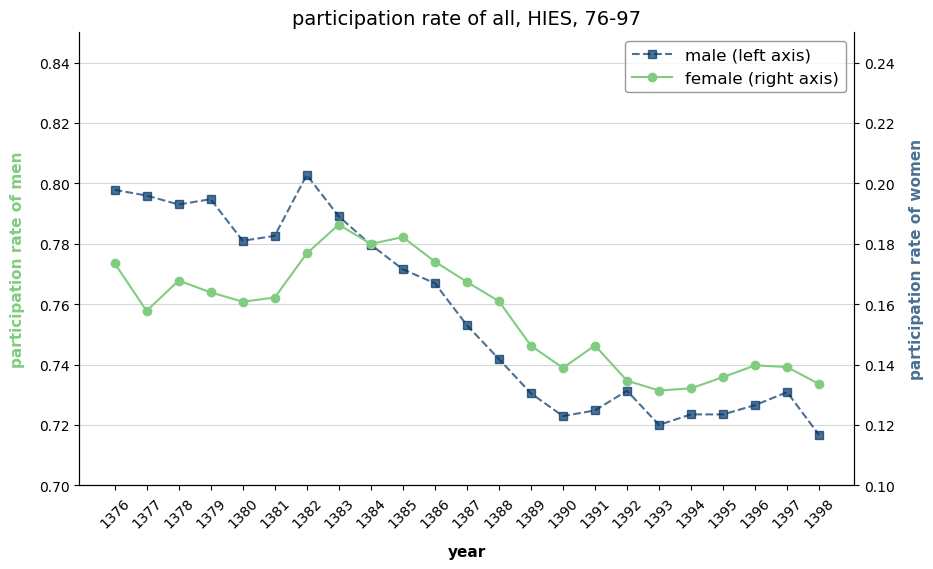

In [27]:
# plot unemployement and participation rate of all between 76-96

fig=plt.figure(figsize=(10,6))
ax1= fig.add_subplot(1,1,1)
line1= ax1.plot('year', 'participation', '--s',color=(0,0.2,0.4,0.7),
        data=groupYearGender[(groupYearGender['gender']==genderCode['male'])],
        label='male (left axis)')

ax1.set_ylabel('participation rate of men',fontsize=11,labelpad=10,fontweight='bold', color=(0.5,0.8,0.5,1))
ax1.set_ylim(0.7,0.85)
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)


ax2=ax1.twinx()
line2= ax2.plot('year', 'participation', '-o', color=(0.5,0.8,0.5,1) ,
        data=groupYearGender[(groupYearGender['gender']==genderCode['female'])],
        label='female (right axis)')

ax1.set_title('participation rate of all, HIES, 76-97',fontsize=14)
ax1.set_xlabel('year',fontsize=11,labelpad=10,fontweight='bold')
ax2.set_ylabel('participation rate of women',fontsize=11,labelpad=10,fontweight='bold', color=(0,0.2,0.4,0.7))
ax2.set_ylim(0.1,0.25)

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.4)
ax1.grid(axis='y',alpha=0.5)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

One thing this graph show us is that labor market condition for men and women are different,
    thus whlie investigating aspects of labor force, we distinguish between them.


<br>

## By year and education

<br>

In [28]:
groupYearEduc=data.groupby(by=['year','educated']).agg({
    'unemployement':wm,'participation':wm}).reset_index()
groupYearEducGender=data.groupby(by=['year','educated','gender']).agg({
    'unemployement':wm,'participation':wm}).reset_index()


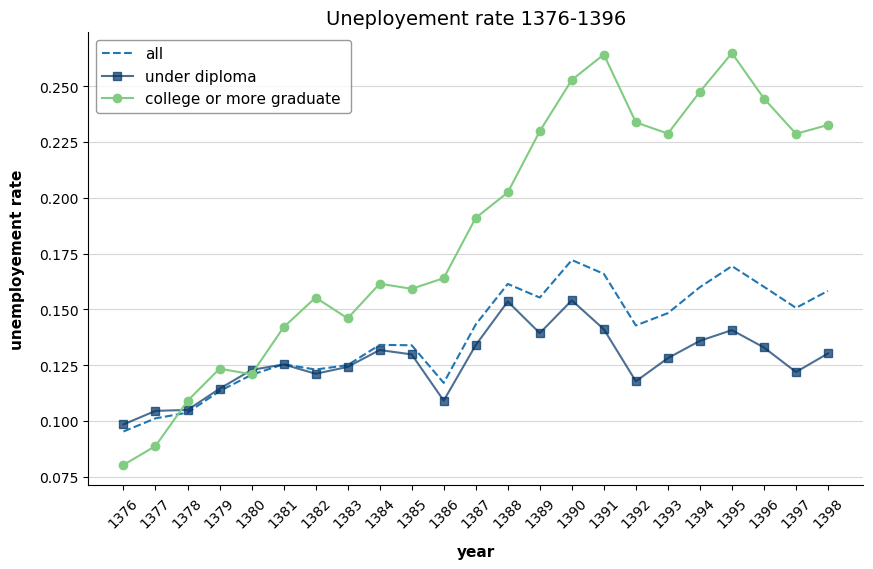

In [29]:
fig=plt.figure(figsize=(10,6))
ax1= fig.add_subplot(1,1,1)

ax1.plot('year','unemployement','--',
         data=groupYear,
        label='all')
for index,educ in enumerate([0,1]):
    ax1.plot('year','unemployement',
            data=groupYearEduc[(groupYearEduc['educated']== educ)],
            label=f'{"under diploma" if educ==0 else "college or more graduate"} ',
            marker= marker[index],
            color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1))

ax1.set_title('Uneployement rate 1376-1396',fontsize=14)
ax1.set_xlabel('year',fontsize=11,labelpad=10,fontweight='bold')
ax1.set_ylabel('unemployement rate',fontsize=11,labelpad=10,fontweight='bold')
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
# plt.yticks(np.arange(0.04,0.25,0.02))
ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':11})
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
plt.show()
# figure.savefig('./output/')

*graph*: **Uneployement rate of men 1376-1397 by education category**


*graph*: **Uneployement rate of women 1376-1397 by education category**

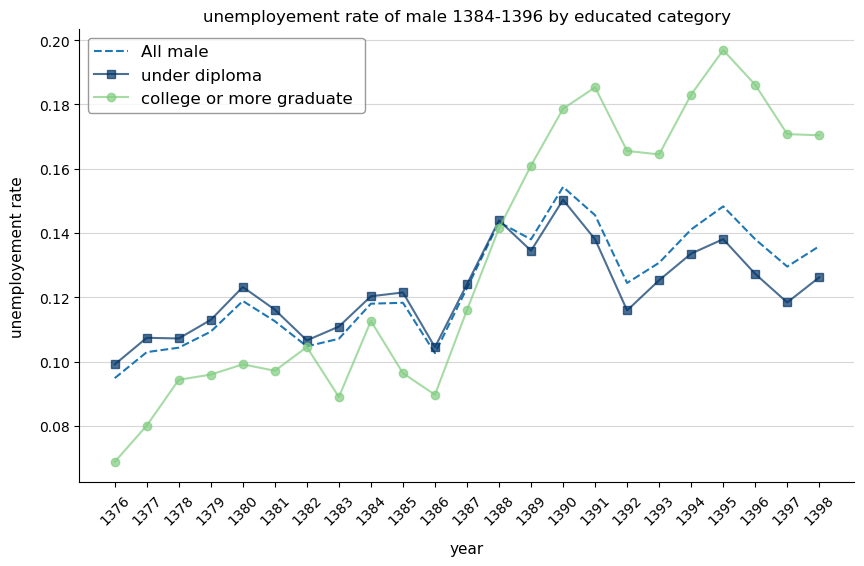

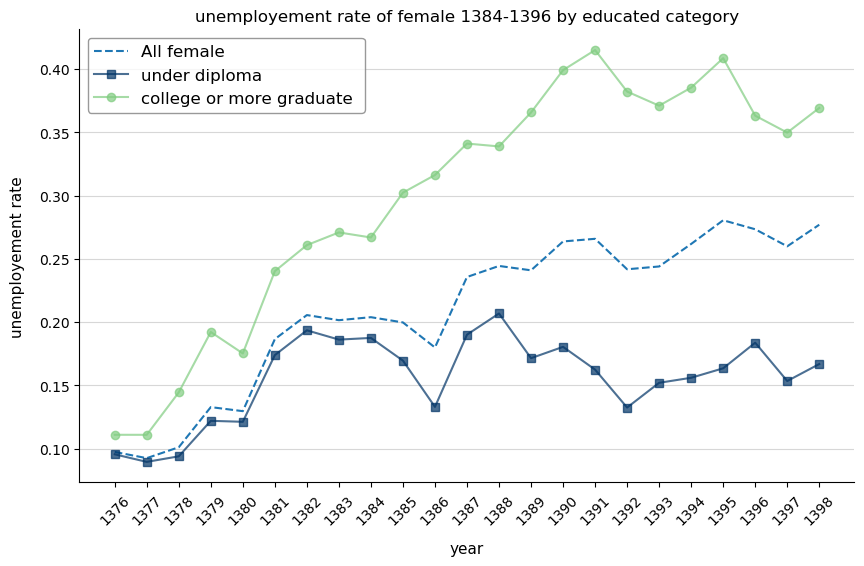

In [30]:
################################
for gender in ['male', 'female']:
    fig=plt.figure(figsize=(10,6))
    ax1= fig.add_subplot(1,1,1)

    ax1.plot('year','unemployement','--',
             data=groupYearGender[groupYearGender['gender']== genderCode[gender]],
            label=f'All {gender}')

    for index,educ in enumerate([0,1]):

        ax1.plot('year','unemployement','-s',
                data=groupYearEducGender[(groupYearEducGender['educated']==educ)&
                                  (groupYearEducGender['gender']== genderCode[gender])],
                label=f'{"under diploma" if educ==0 else "college or more graduate"} ',
                marker= marker[index],
                color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1),
                alpha=0.7)

    ax1.set_title(f'unemployement rate of {gender} 1384-1396 by educated category')
    ax1.set_xlabel('year',fontsize=11,labelpad=10,fontweight='regular')
    ax1.set_ylabel('unemployement rate', fontsize=11,labelpad=10,fontweight='regular')
    ax1.set_xticks(np.arange(76,99,1))
    ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
    # plt.yticks(np.arange(0.53,0.77,0.02))
    ax1.grid(axis='y',alpha=0.5)
    ax1.legend(loc='best',edgecolor='gray',prop={'size':12})
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.show()
    # fig.savefig('./output/participation rate by education')

<br>

*graph*: **participation rate of men 1376-1397 by educated category**

*graph*: **participation rate of women 1376-1397 by educated category**

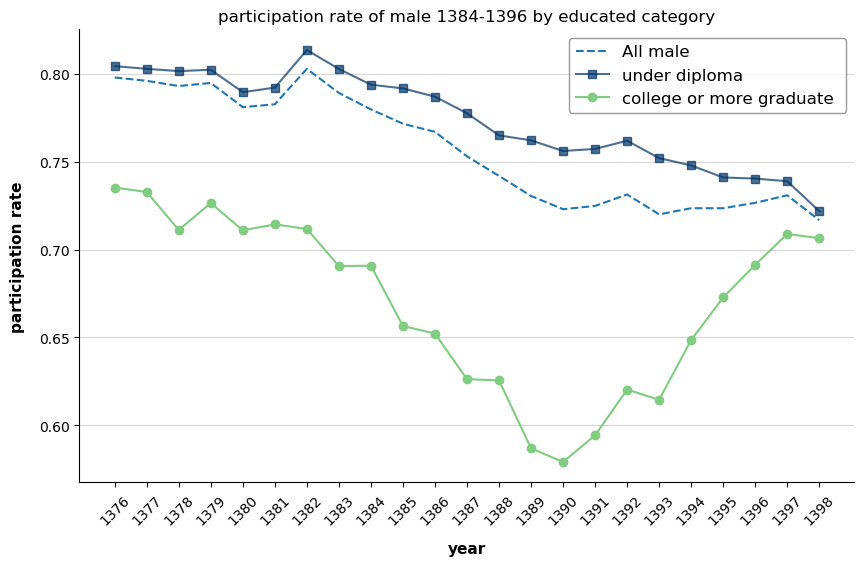

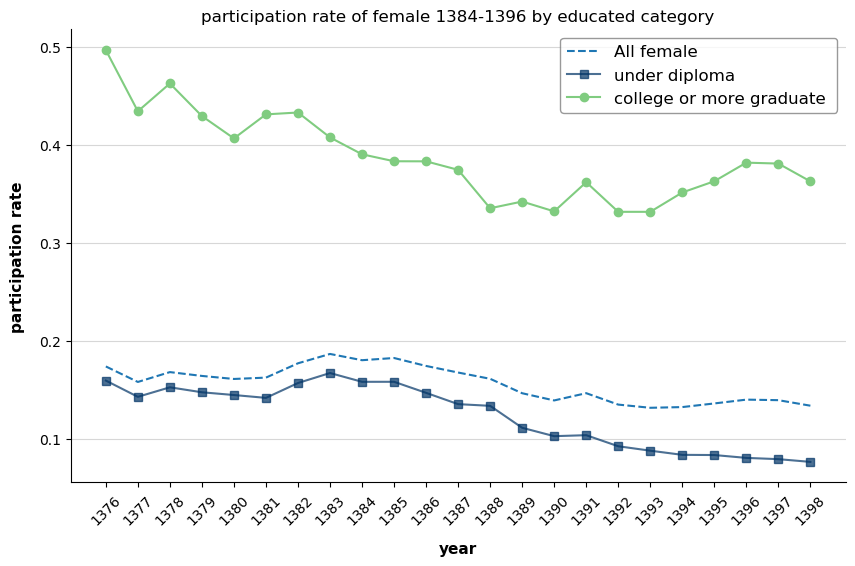

In [31]:
################################
for gender in ['male', 'female']:
    fig=plt.figure(figsize=(10,6))
    ax1= fig.add_subplot(1,1,1)

    ax1.plot('year','participation','--',
             data=groupYearGender[groupYearGender['gender']== genderCode[gender]],
            label=f'All {gender}')

    for index,educ in enumerate([0,1]):
        
        ax1.plot('year','participation',
                data=groupYearEducGender[(groupYearEducGender['educated']==educ)&
                                  (groupYearEducGender['gender']== genderCode[gender])],
                label=f'{"under diploma" if educ==0 else "college or more graduate"} ',
                marker= marker[index],
                color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1))

    ax1.set_title(f'participation rate of {gender} 1384-1396 by educated category')
    ax1.set_xlabel('year',fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_ylabel('participation rate',fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_xticks(np.arange(76,99,1))
    ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
    # plt.yticks(np.arange(0.53,0.77,0.02))
    ax1.grid(axis='y',alpha=0.5)
    ax1.legend(loc='best',edgecolor='gray',prop={'size':12})
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.show()
    # fig.savefig('./output/participation rate by education')

<br>

## By collar and year

<br>


*graph*: **share of occupation in each year**

In [32]:
####
# weighted version
# just considering white- and blue- collar:
groupCountCollar= data[(data.collar!=2) ].groupby(by=['year']).agg({
    'collar':wm}).reset_index()

########################################## year above must be corrected after defining collar


# unweighted version
# groupCountCollar= data.groupby(by=['year'])['collar'].value_counts(normalize=True). \
#     unstack().reset_index().rename(columns={0:'white',1:'blue', 2:'military'})

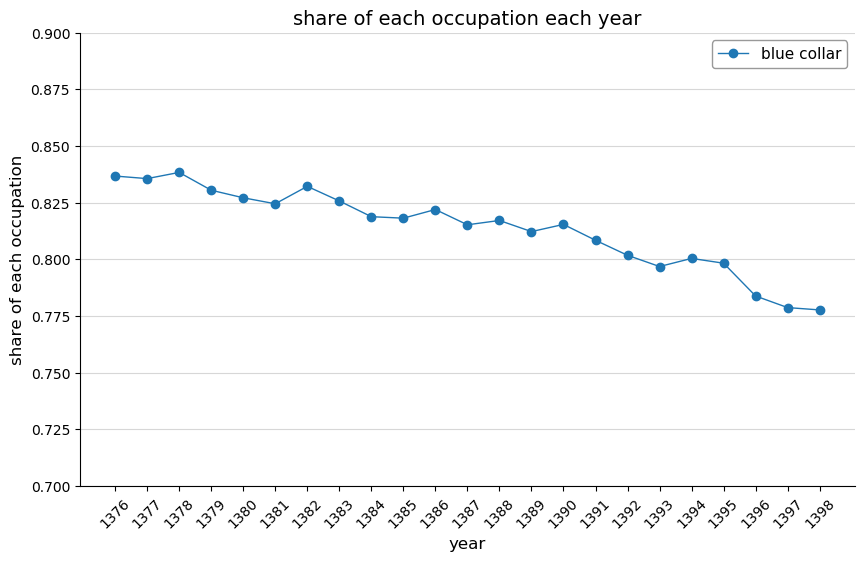

In [33]:
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,1,1)

ax1.plot('year','collar','-o', linewidth=1,
        data=groupCountCollar,
        label='blue collar')

ax1.set_title('share of each occupation each year', fontsize= 14)
ax1.set_xlabel('year', fontsize=12)
ax1.set_ylabel('share of each occupation', fontsize=12)
ax1.set_xticks(np.arange(76,99))
ax1.set_ylim(0.7 , 0.9)
# ax1.set_yticks(np.arange(0, 0.91, 0.1))
# ax1.set_xlim(75,98)
ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation= 45)

ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':11})
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()

In [34]:
groupYearCollar=data.groupby(by=['year','collar']).agg({'educated':wm,'gender':wm}).reset_index()


<br>

*graph*: **share of men in blue- and white- collar occupations**

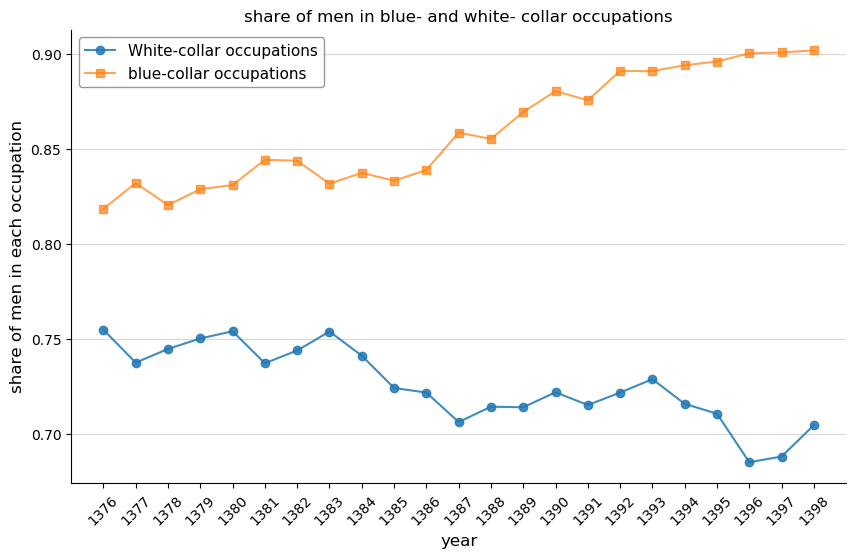

In [35]:
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,1,1)

ax1.plot('year','gender','-o',
        data=groupYearCollar[(groupYearCollar.collar==0)]
        ,label='White-collar occupations'
        ,alpha=0.85)
ax1.plot('year','gender','-s',
        data=groupYearCollar[(groupYearCollar.collar==1)]
        ,label='blue-collar occupations'
        ,alpha=0.7)
# plt.plot('year','gender','-x',
#         data=groupYearCollar[(groupYearCollar.collar==2)]
#         ,label='military occupations')

ax1.set_title('share of men in blue- and white- collar occupations')
ax1.set_xlabel('year',fontsize=12)
ax1.set_ylabel('share of men in each occupation',fontsize=12)
ax1.set_xlim(75,99)
ax1.set_xticks(np.arange(76,99))
ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation= 45)
ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc='best',prop={'size':11},edgecolor='gray')
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()

<br>

*graph*: **share of educated in blue- and white- collar occupations**

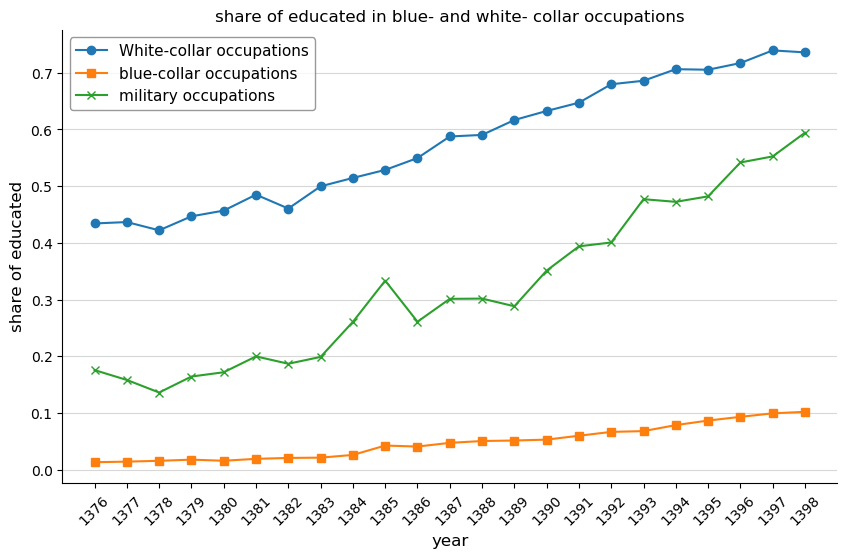

In [36]:
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,1,1)

ax1.plot('year','educated','-o',
        data=groupYearCollar[(groupYearCollar.collar==0)]
        ,label='White-collar occupations')

ax1.plot('year','educated','-s',
        data=groupYearCollar[(groupYearCollar.collar==1)]
        ,label='blue-collar occupations')
ax1.plot('year','educated','-x',
        data=groupYearCollar[(groupYearCollar.collar==2)]
        ,label='military occupations')

ax1.set_title('share of educated in blue- and white- collar occupations')
ax1.set_xlabel('year',fontsize=12)
ax1.set_ylabel('share of educated',fontsize=12)

ax1.set_xlim(75,99)
ax1.set_xticks(np.arange(76,99))
ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation= 45)
ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc='best',prop={'size':11},edgecolor='gray')
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()

<br>

*graph:* **share of educated people going to blue-collar occupation by gender**

In [37]:
groupYearEducGender=data.groupby(by=['year','educated','gender']).agg({'collar': wm}).reset_index()

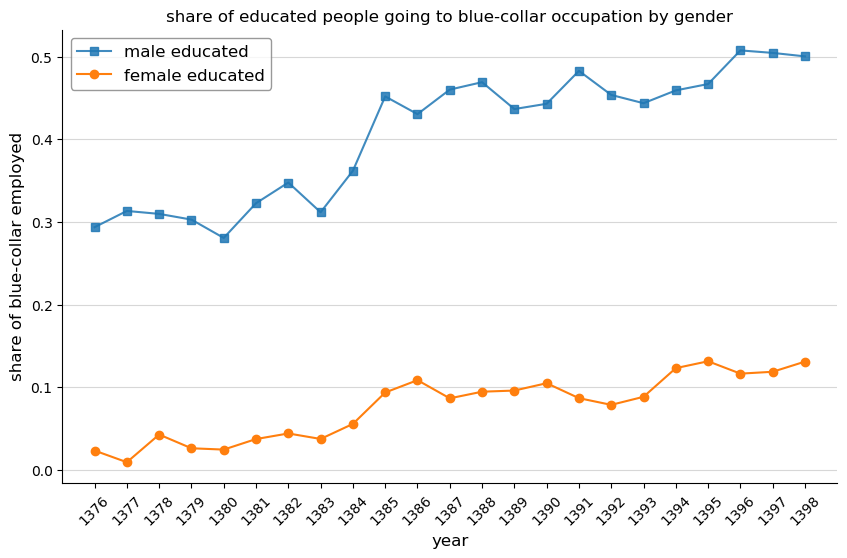

In [38]:
# for gender in ['male', 'female']:
gender='male'

fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,1,1)
ax1.plot('year','collar','-s',
        data=groupYearEducGender[(groupYearEducGender.gender==genderCode[gender])&
                                 (groupYearEducGender.educated==1)]
        ,label='male educated'
        ,alpha=0.85)

ax1.plot('year','collar','-o',
        data=groupYearEducGender[(groupYearEducGender.gender==genderCode['female'])&
                                 (groupYearEducGender.educated==1)]
        ,label='female educated')

ax1.set_title('share of educated people going to blue-collar occupation by gender')
ax1.set_xlabel('year',fontsize=12)
ax1.set_ylabel('share of blue-collar employed',fontsize=12)
ax1.set_xlim(75,99)
ax1.set_xticks(np.arange(76,99))
ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation= 45)
ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc='best',prop={'size':12},edgecolor='gray')
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()

<br>

## By marital status and gender


*this is new in version 7*

<br>

In [45]:
data.loc[(data.marital==1), 'married']= 'married'
data.loc[(data.marital.isin([2,3,4])), 'married']= 'single'
data= data.astype({'married':'category'})


In [46]:
groupYearGenderMar=data.groupby(by=['year','gender','married']).agg(
    {'participation':wm,'unemployement':wm}).reset_index()

<br>

*graph*: **participation rate of men and women by marital status**


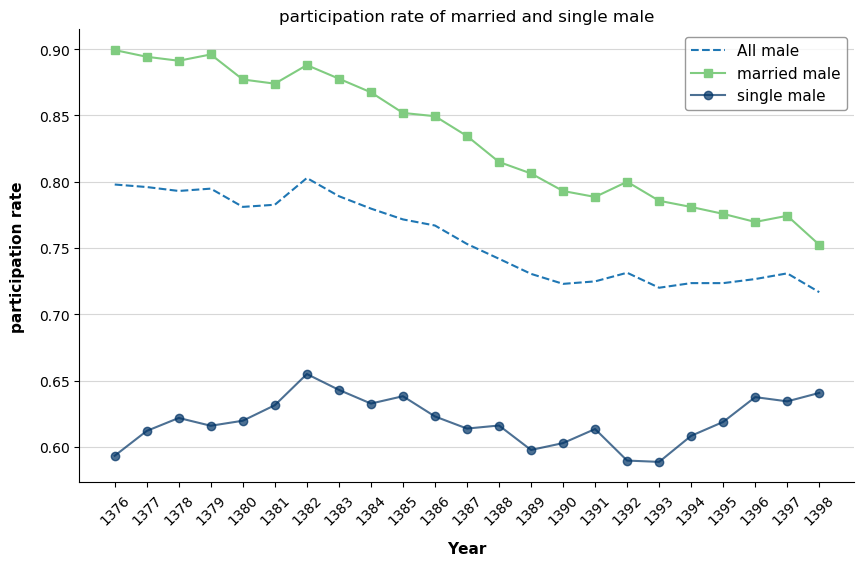

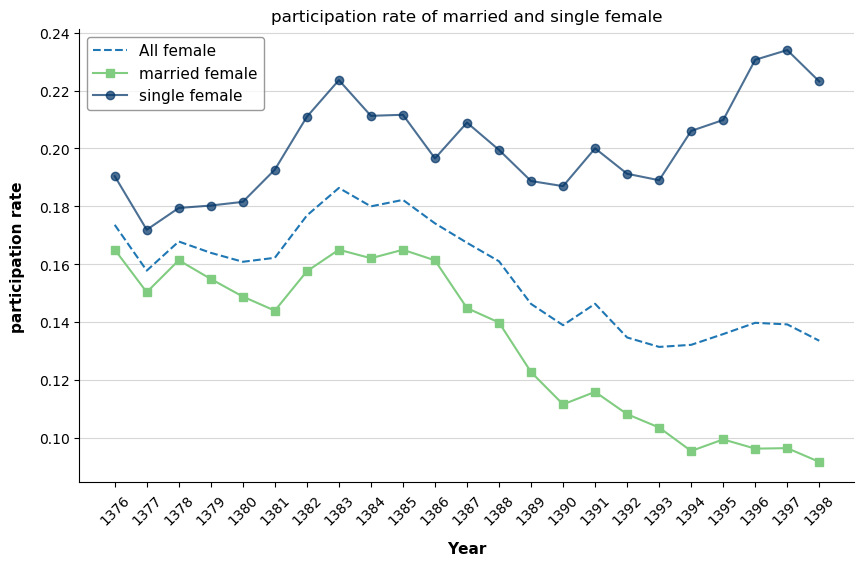

In [47]:
for gender in ['male','female']:
    fig=plt.figure(figsize=(10, 6))
    ax1=fig.add_subplot(1,1,1)

    ax1.plot('year','participation','--',
             data=groupYearGender[groupYearGender.gender==genderCode[gender]],
            label=f'All {gender}')

    for index,married in enumerate(['married','single']):

        ax1.plot('year','participation',
                data=groupYearGenderMar[(groupYearGenderMar['gender']==genderCode[gender])
                                        &(groupYearGenderMar['married']== married)],
                label=f'{married} {gender}',
                marker= marker[index],
                color=(0,0.2,0.4,0.7) if married=='single' else (0.5,0.8,0.5,1))

    ax1.set_xlabel('Year', fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_ylabel('participation rate', fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_title(f'participation rate of married and single {gender}')
    ax1.set_xticks(np.arange(76,99))
    ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation= 45)
    # plt.yticks(np.arange(0,0.3,0.025))
    ax1.grid(axis='y',alpha=0.5)
    ax1.legend(loc='best',edgecolor='gray',prop={'size':11}, handlelength=2.2)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.show()
    # figure.savefig('./output/')

<br>

*graph*: **unemployement rate of men and women by marital status**


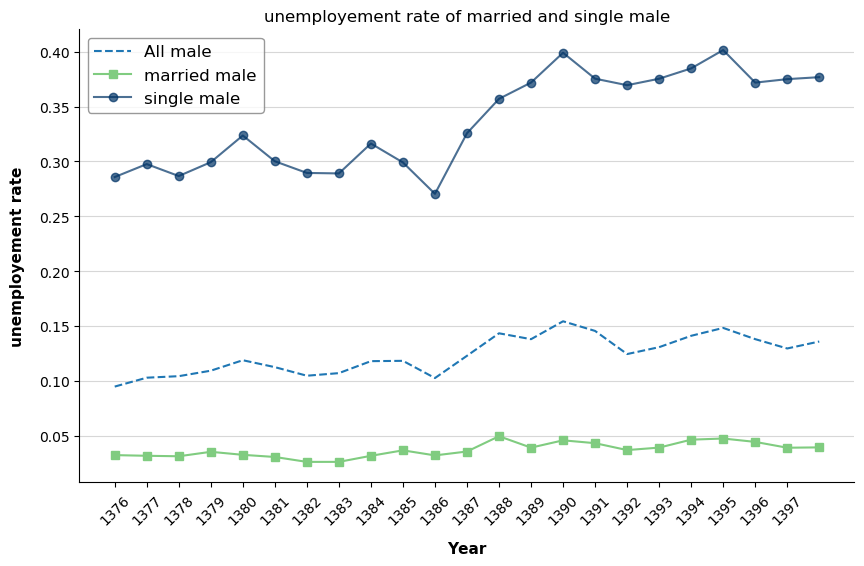

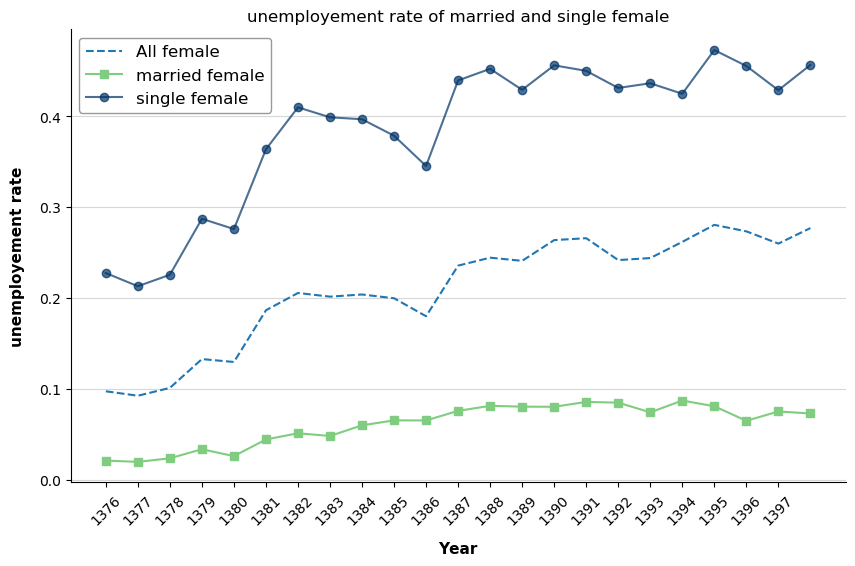

In [48]:
for gender in ['male','female']:
    fig=plt.figure(figsize=(10, 6))
    ax1=fig.add_subplot(1,1,1)

    ax1.plot('year','unemployement','--',
             data=groupYearGender[groupYearGender.gender==genderCode[gender]],
            label=f'All {gender}')

    for index,married in enumerate(['married','single']):

        ax1.plot('year','unemployement',
                data=groupYearGenderMar[(groupYearGenderMar['gender']==genderCode[gender])
                                        &(groupYearGenderMar['married']== married)],
                label=f'{married} {gender}',
                marker= marker[index],
                color=(0,0.2,0.4,0.7) if married=='single' else (0.5,0.8,0.5,1))

    ax1.set_xlabel('Year', fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_ylabel('unemployement rate', fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_title(f'unemployement rate of married and single {gender}')
    ax1.set_xticks(np.arange(76,98))
    ax1.set_xticklabels([year for year in np.arange(1376,1398)],rotation= 45)
    # plt.yticks(np.arange(0,0.3,0.025))
    ax1.grid(axis='y',alpha=0.5)
    ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.show()
    # figure.savefig('./output/')

<br>

## By cohort: everty 5 years from 1350 is a cohort

<br>


In [49]:
data['cohort5']= pd.cut(x=data['birth_y'],bins=np.arange(49,81-5,5),
                       labels=[f'[{year+1+1300+621-1900},{year+5+1300+621-1900}]' for year in np.arange(49,79-5,5)])

groupAgeGenderCohort5=data[(data['age']>=16) & (data['age']<=36)].groupby(
            by=['age','cohort5','gender']).agg(
            {'participation': wm ,'unemployement': wm }
            ).reset_index()

groupAgeGenderCohort5Mar=data[(data['age']>=16) & (data['age']<=35)].groupby(
            by=['age','cohort5','gender','married']).agg(
            {'participation': wm ,'unemployement': wm }
            ).reset_index()

data.drop(columns=['cohort5'], inplace= True)

In [50]:
# gender= 'male'
# #########################
# for gender in ['male', 'female']:
#     for stat in ['participation', 'unemployement']:
#         fig=plt.figure(figsize=(10,7))

#         for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
#             plt.plot('age', stat ,'-o',
#                     data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>=16)
#                                             &(groupAgeGenderCohort5['age']<35)
#                                             &(groupAgeGenderCohort5['cohort5']==cohort)
#                                             &(groupAgeGenderCohort5['gender']== genderCode[gender])],
#                     label=f'cohort {cohort}',
#                     marker=marker[index], linewidth=1)
#         plt.title(f'{stat} rate of {gender}, by cohorts')
#         plt.xlabel('age',fontsize=12)
#         plt.xticks(np.arange(17,36,2))
#         plt.ylabel(f'{stat}',fontsize=12)

#         plt.grid(axis='both',alpha=0.5)
#         plt.legend(loc='best',edgecolor='gray',prop={'size':12})
#         plt.show()

In [51]:
groupAgeGenderCohort5;

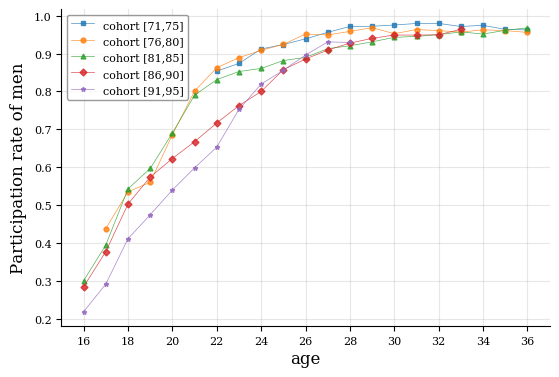

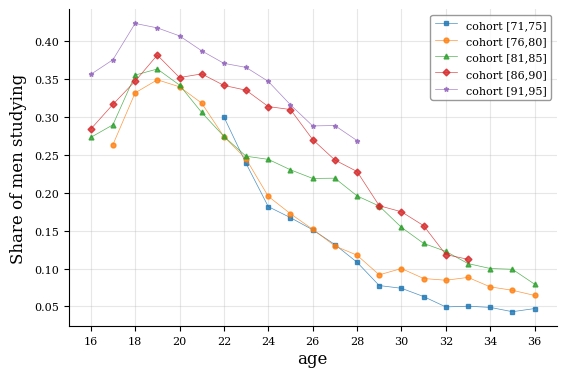

In [52]:
# gender= 'male'
#########################
fSize = 12
tSize = 8
label = {"participation":"Participation rate of men" 
        ,"unemployement":"Share of men studying"}
for gender in ['male']:
    for stat in ['participation',"unemployement"]:
        fig=plt.figure(figsize=(9*0.7,6*0.7))
        plt.rc('font', family='serif')
        plt.rc('xtick',labelsize=tSize)
        plt.rc('ytick',labelsize=tSize)
        ax1=fig.add_subplot(1,1,1)
        for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
            ax1.plot('age', stat ,'-o',
                    data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>=16)
                                            &(groupAgeGenderCohort5['age']<=36)
                                            &(groupAgeGenderCohort5['cohort5']==cohort)
                                            &(groupAgeGenderCohort5['gender']== genderCode[gender])],
                    label=f'cohort {cohort}',
                    marker=marker[index], 
                    linewidth=0.5,
                    markersize=3.5,
                    alpha=0.8)
        # ax1.set_title(f'{stat} rate of {gender}, by cohorts')
        # ax1.set_xlabel('age',fontsize=12)
        
        ax1.set_ylabel(f'{stat}',fontsize=12)
        
        
        ax1.set_xlabel("age",                            fontsize=fSize,labelpad=3)
        ax1.set_ylabel((f"{(label[stat])}"),fontsize=fSize,labelpad=5)
        ax1.set_xticks(np.arange(16,37,2))
        # ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)]
        #                     ,rotation=0,fontsize=10)

        ax1.grid(axis='y',alpha=0.3)
        ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-4},
                   ncol=1,handlelength=2,handleheight=1)
    
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.grid(axis='both',alpha=0.3)
        plt.show()
#         fig.savefig(f"Results/Paper/{stat}_rate_{gender}_different_cohorts.pdf", bbox_inches='tight')
        

In [53]:
# # gender= 'male'
# #########################
# label = {"participation":"نرخ مشارکت در بازار کار" 
#         ,"unemployement":"نرخ بیکاری"}
# for gender in ['male']:
#     for stat in ["participation","unemployement"]:
#         fig=plt.figure(figsize=(9,6))
#         ax1=fig.add_subplot(1,1,1)
#         for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
#             ax1.plot('age', stat ,'-o',
#                     data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>=16)
#                                             &(groupAgeGenderCohort5['age']<=35)
#                                             &(groupAgeGenderCohort5['cohort5']==cohort)
#                                             &(groupAgeGenderCohort5['gender']== genderCode[gender])],
#                     label=f'{cohort}  {farsi("متولدین")}',
#                     marker=marker[index], linewidth=1)

        
#         ax1.set_ylabel(f'{stat}',fontsize=12)
        
        
#         ax1.set_xlabel(farsi("سن"),fontdict={'family': 'B Yas','size': 20},labelpad=17)
#         ax1.set_ylabel(farsi(f"{(label[stat])}"),fontdict={'family': 'B Yas'},
#                        fontsize=20,labelpad=5 ,fontweight='regular')
#         ax1.set_xticks(np.arange(15,36,2))

#         ax1.grid(axis='y',alpha=0.5)
#         ax1.legend(loc="best",edgecolor="gray", prop={'family': 'B Yas',"size":13},
#                    ncol=1,handlelength=2,handleheight=1)
#         ax1.tick_params(labelsize=12)
    
#         ax1.spines['right'].set_visible(False)
#         ax1.spines['top'].set_visible(False)
#         ax1.grid(axis='both',alpha=0.5)
#         plt.show()
# #         fig.savefig(f"Results/1.{stat} rate of  {gender} of defferent cohorts.pdf", bbox_inches='tight')
        

In [54]:
data.drop(columns=["working"],inplace=True , errors="ignore")
data.loc[(data['labor'].isin([1])), 'working']=1
data.loc[(data['labor'].isin([2,3,4,5,6])), 'working']=0
data.loc[(data['age']<16),'working']=np.nan
data['working']= data.working.astype('category')

In [55]:
# data['cohort5']= pd.cut(x=data['birth_y'],bins=np.arange(49,81,5),
#                        labels=[f'[{year+1},{year+5}]' for year in np.arange(49,79,5)])

# groupAgeGenderCohort5=data[(data['age']>=16) & (data['age']<=39)].groupby(
#             by=['age','cohort5','gender']).agg(
#             {'working': wm ,'student':wm }
#             ).reset_index()

# data.drop(columns=['cohort5',"working"], inplace= True)

In [56]:
data['cohort5']= pd.cut(x=data['birth_y'],bins=np.arange(49,81-5,5),
                       labels=[f'{year+1+1300+621-1900}-{year+5+1300+621-1900}' for year in np.arange(49,79-5,5)])

groupAgeGenderCohort5=data[(data['age']>=16) & (data['age']<=39)].groupby(
            by=['age','cohort5','gender']).agg(
            {'working': wm ,'student':wm }
            ).reset_index()

data.drop(columns=['cohort5',"working"], inplace= True)

In [57]:
# # gender= 'male'
# #########################
# label = {"working":"کار" 
#         ,"student":"تحصیل"}
# for gender in ['male']:
#     for stat in ['working',"student"]:
#         fig=plt.figure(figsize=(9,6))
#         ax1=fig.add_subplot(1,1,1)
#         for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
#             ax1.plot('age', stat ,'-o',
#                     data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>=16)
#                                             &(groupAgeGenderCohort5['age']<=35)
#                                             &(groupAgeGenderCohort5['cohort5']==cohort)
#                                             &(groupAgeGenderCohort5['gender']== genderCode[gender])],
#                     label=f'{cohort}  {farsi("متولدین")}',
#                     marker=marker[index], linewidth=1)
# #         ax1.set_title(f'{stat} rate of {gender}, by cohorts')
# #         ax1.set_xlabel('age',fontsize=12)
        
#         ax1.set_ylabel(f'{stat}',fontsize=12)
        
        
#         ax1.set_xlabel(farsi("سن"),fontdict={'family': 'B Yas','size': 20},labelpad=17)
#         ax1.set_ylabel(farsi(f"نسبت کل مردان در حال {(label[stat])}"),fontdict={'family': 'B Yas'},
#                        fontsize=20,labelpad=5 ,fontweight='regular')
#         ax1.set_xticks(np.arange(15,36,2))
# #         ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)]
# #                             ,rotation=0,fontsize=10)

#         ax1.grid(axis='y',alpha=0.5)
#         ax1.legend(loc="best",edgecolor="gray", prop={'family': 'B Yas',"size":13},
#                    ncol=1,handlelength=2,handleheight=1)
#         ax1.tick_params(labelsize=12)
    
#         ax1.spines['right'].set_visible(False)
#         ax1.spines['top'].set_visible(False)
#         ax1.grid(axis='both',alpha=0.5)
#         plt.show()
# #         fig.savefig(f"Results/1.{stat} rate of  {gender} of defferent cohorts.pdf", bbox_inches='tight')
        

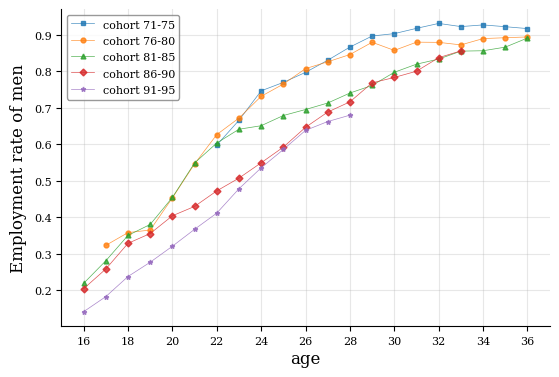

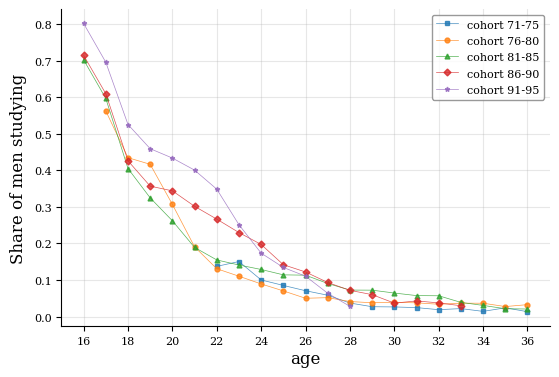

In [58]:
# gender= 'male'
#########################
fSize = 12
tSize = 8
label = {"working":"Employment rate of men" 
        ,"student":"Share of men studying"}
for gender in ['male']:
    for stat in ['working',"student"]:
        fig=plt.figure(figsize=(9*0.7,6*0.7))
        plt.rc('font', family='serif')
        plt.rc('xtick',labelsize=tSize)
        plt.rc('ytick',labelsize=tSize)
        ax1=fig.add_subplot(1,1,1)
        for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
            ax1.plot('age', stat ,'-o',
                    data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>=16)
                                            &(groupAgeGenderCohort5['age']<=36)
                                            &(groupAgeGenderCohort5['cohort5']==cohort)
                                            &(groupAgeGenderCohort5['gender']== genderCode[gender])],
                    label=f'cohort {cohort}',
                    marker=marker[index], 
                    linewidth=0.5,
                    markersize=3.5,
                    alpha=0.8)
        # ax1.set_title(f'{stat} rate of {gender}, by cohorts')
        # ax1.set_xlabel('age',fontsize=12)
        
        ax1.set_ylabel(f'{stat}',fontsize=12)
        
        
        ax1.set_xlabel("age",                            fontsize=fSize,labelpad=3)
        ax1.set_ylabel((f"{(label[stat])}"),fontsize=fSize,labelpad=5)
        ax1.set_xticks(np.arange(16,37,2))
        # ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)]
        #                     ,rotation=0,fontsize=10)

        ax1.grid(axis='y',alpha=0.3)
        ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-4},
                   ncol=1,handlelength=2,handleheight=1)
    
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.grid(axis='both',alpha=0.3)
        plt.show()
#         fig.savefig(f"Results/Paper/{stat}_rate_{gender}_different_cohorts.pdf", bbox_inches='tight')
        

In [59]:
# # gender= 'male'
# #########################
# fSize = 10
# tSize = 6
# label = {"working":"Employment rate of men" 
#         ,"student":"Share of men studying"}
# for gender in ['male']:
#     fig=plt.figure(figsize=(7, 2.5))
#     plt.rc('font', family='serif')
#     plt.rc('xtick',labelsize=tSize)
#     plt.rc('ytick',labelsize=tSize)
#     for stat in ['working',"student"]:
#         if stat == "working":
#             ax1=fig.add_subplot(1,2,1)
#         else:
#             ax1=fig.add_subplot(1,2,2)

#         for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
#             ax1.plot('age', stat ,'-o',
#                     data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>=16)
#                                             &(groupAgeGenderCohort5['age']<=35)
#                                             &(groupAgeGenderCohort5['cohort5']==cohort)
#                                             &(groupAgeGenderCohort5['gender']== genderCode[gender])],
#                     label=f'cohort {cohort}',
#                     marker=marker[index], 
#                     linewidth=0.5,
#                     markersize=3)
#         # ax1.set_title(f'{stat} rate of {gender}, by cohorts')
#         # ax1.set_xlabel('age',fontsize=12)
        
#         ax1.set_ylabel(f'{stat}',fontsize=12)
        
        
#         ax1.set_xlabel("age",                            fontsize=fSize,labelpad=3)
#         ax1.set_ylabel((f"{(label[stat])}"),fontsize=fSize,labelpad=5)
#         ax1.set_xticks(np.arange(15,36,2))
#         # ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)]
#         #                     ,rotation=0,fontsize=10)

#         ax1.grid(axis='y',alpha=0.3)
#         ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-4},
#                    ncol=1,handlelength=2,handleheight=1)
    
#         ax1.spines['right'].set_visible(False)
#         ax1.spines['top'].set_visible(False)
#         ax1.grid(axis='both',alpha=0.5)
#     plt.show()
# #     fig.savefig(f"Results/Paper/{gender}_different_cohorts.pgf", bbox_inches='tight')
        

<br>

### By marital status

*new in version 7*

In [60]:
# data['cohort5']= pd.cut(x=data['birth_y'],bins=np.arange(49,76,5),
#                        labels=[f'[{year+1},{year+5}]' for year in np.arange(49,74,5)])

# groupAgeGenderCohort5Mar=data.groupby(by=['age','cohort5','gender','married']).agg(
#             {'participation': wm ,'unemployement': wm }
#             ).reset_index()

# data.drop(columns=['cohort5'], inplace= True)

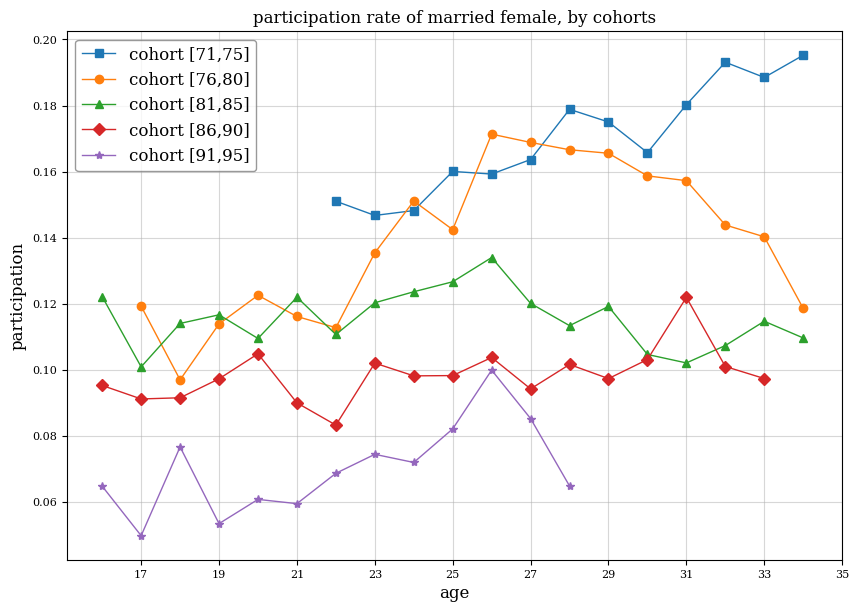

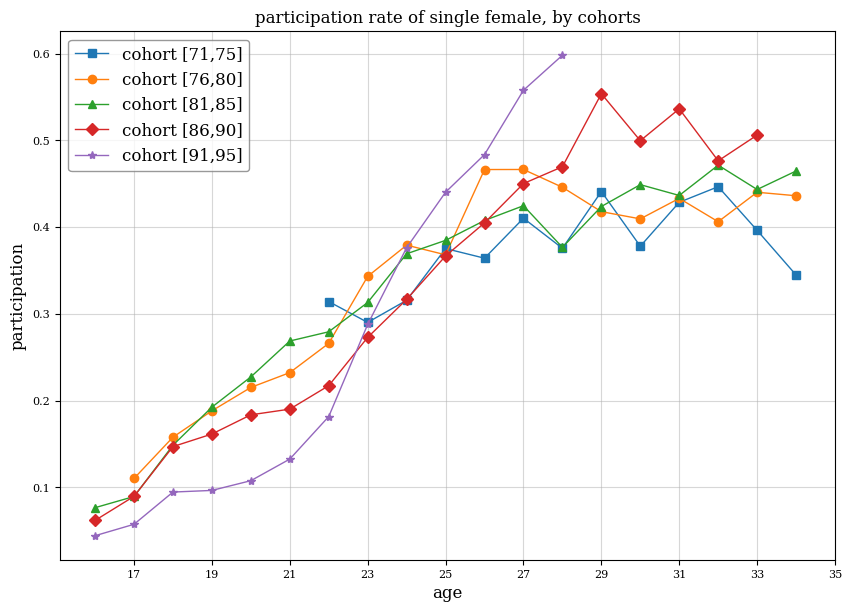

In [61]:
gender= 'female'
#########################
for married in ['married', 'single']:
    for stat in ['participation']:
        fig=plt.figure(figsize=(10,7))

        for index,cohort in enumerate(groupAgeGenderCohort5Mar['cohort5'].unique()):
            plt.plot('age', stat ,'-o',
                    data=groupAgeGenderCohort5Mar[(groupAgeGenderCohort5Mar['age']>=16)
                                            &(groupAgeGenderCohort5Mar['age']<35)
                                            &(groupAgeGenderCohort5Mar['cohort5']==cohort)
                                            &(groupAgeGenderCohort5Mar['gender']== genderCode[gender])
                                            &(groupAgeGenderCohort5Mar['married']==married)],
                    label=f'cohort {cohort}',
                    marker=marker[index], linewidth=1)
        plt.title(f'{stat} rate of {married} {gender}, by cohorts')
        plt.xlabel('age',fontsize=12)
        plt.xticks(np.arange(17,36,2))
        plt.ylabel(f'{stat}',fontsize=12)

        plt.grid(axis='both', alpha=0.5)
        plt.legend(loc='best',edgecolor='gray',prop={'size':12})
        plt.show()

<br>

## By cohort for those born in 60-73

<br>

In [62]:
# cohort: in this case is for every two years since 1360-1373
data['cohort']= pd.cut(x=data['birth_y'],bins=np.arange(59,74,2),
                       labels=[f'[{year+1},{year+2}]' for year in np.arange(59,73,2)])

data.loc[(data.marital==4), 'marriedOnce']=0
data.loc[(data.marital.isin([1,2,3]) ), 'marriedOnce']=1

groupAgeGenderCohort=data[(data['age']>=16) & (data['age']<=30)].groupby(
    by=['gender', 'age','cohort']).agg(
    {'student':wm,'participation':wm, 'marriedOnce':wm}).reset_index()
groupAgeGenderCohortMar=data[(data['age']>=16) & (data['age']<=30)].groupby(
    by=['gender', 'age','cohort', 'married']).agg(
    {'participation':wm}).reset_index()

data.drop(columns=['marriedOnce', 'cohort'], inplace=True)

<br>

*graph:*
**Participation rate of males born between 1360-1373 in their 20s**

<br>

*graph*: **Schooling rate of males born between 1360-1373 in their 20s**

<br>

*graph:*
**share of men married at least once of cohort 60-73 in their 20s**


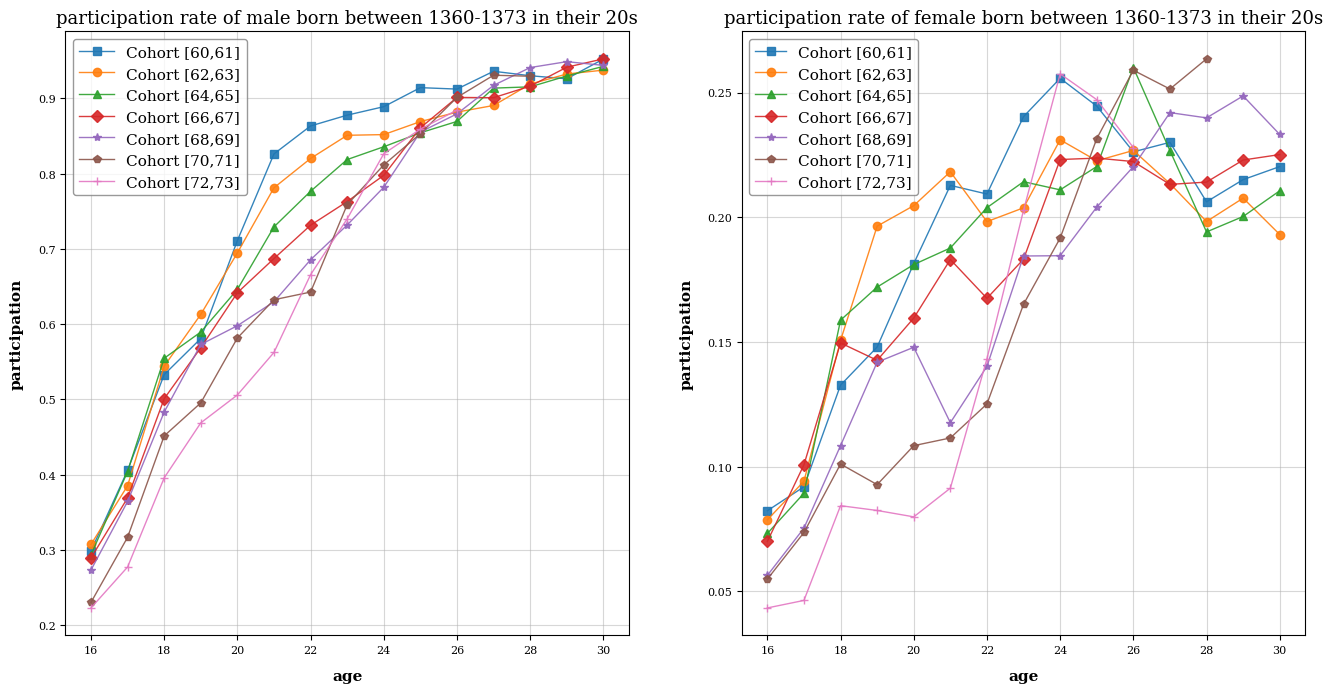

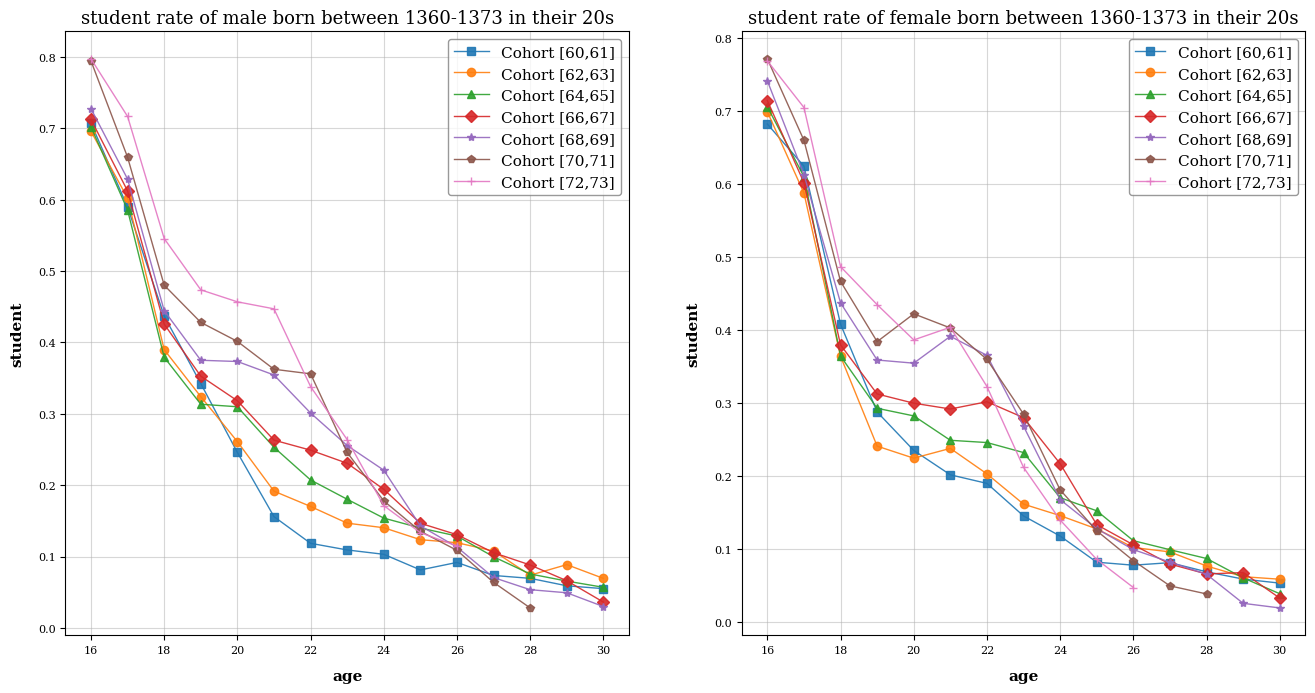

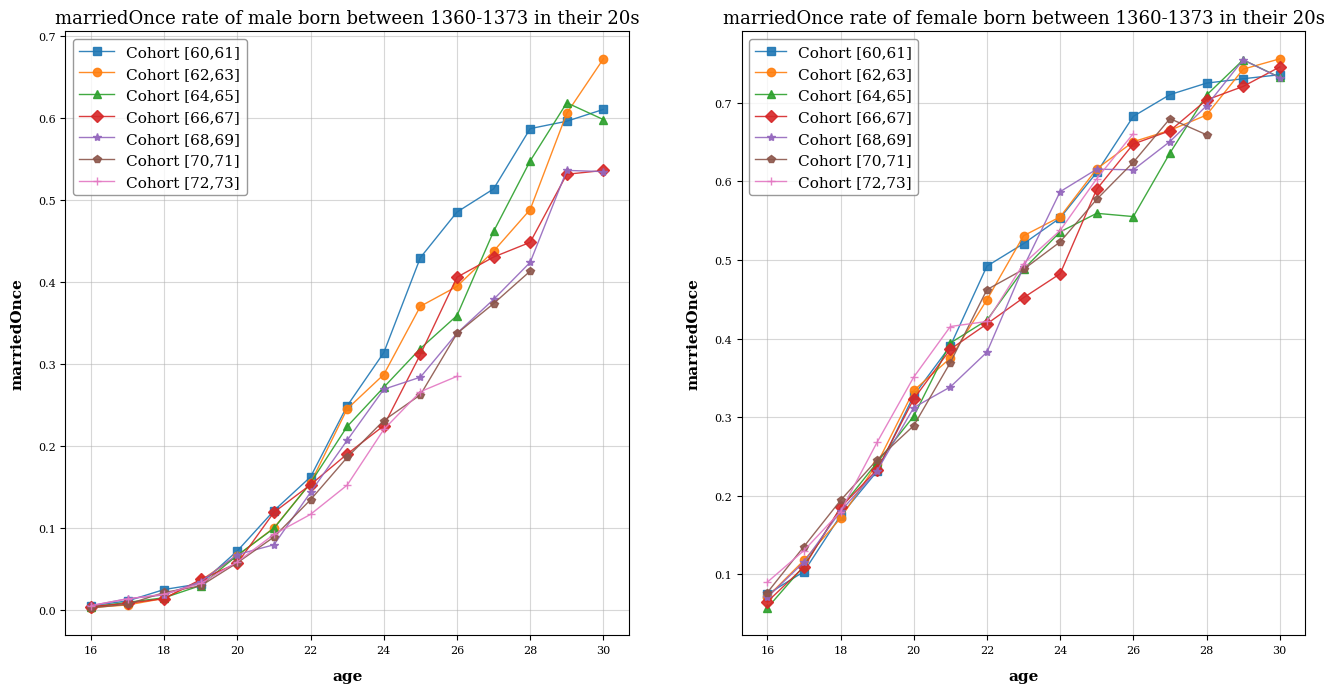

In [63]:
###################
#plot figure
###################

for stat in ['participation', 'student', 'marriedOnce']:
    gender= 'male'
    fig = plt.figure(figsize=(16,8))
    ax1=fig.add_subplot(1,2,1)
    for index,cohort in enumerate(groupAgeGenderCohort['cohort'].unique()):
        ax1.plot('age', stat,
                 data=groupAgeGenderCohort[(groupAgeGenderCohort['gender']== genderCode[gender])
                                           &(groupAgeGenderCohort['cohort']==cohort)]
                 ,label=f'Cohort {cohort}', alpha=0.9,
                 marker=marker[index] , linewidth=1)

    ax1.set_title(f'{stat} rate of {gender} born between 1360-1373 in their 20s',fontsize=13)
    ax1.set_xlabel('age',fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_ylabel(f'{stat}',fontsize=11,labelpad=10,fontweight='bold')
    ax1.grid(axis='both', alpha=0.5)
    ax1.legend(loc='best',prop={'size':11}, edgecolor='gray', handlelength=2.3)
    
    gender= 'female'
    ax2=fig.add_subplot(1,2,2)
    
    for index,cohort in enumerate(groupAgeGenderCohort['cohort'].unique()):
        ax2.plot('age', stat,
                 data=groupAgeGenderCohort[(groupAgeGenderCohort['gender']== genderCode[gender])
                                           &(groupAgeGenderCohort['cohort']==cohort)]
                 ,label=f'Cohort {cohort}', alpha=0.9,
                 marker=marker[index] , linewidth=1)

    ax2.set_title(f'{stat} rate of {gender} born between 1360-1373 in their 20s',fontsize=13)
    ax2.set_xlabel('age',fontsize=11,labelpad=10,fontweight='bold')
    ax2.set_ylabel(f'{stat}',fontsize=11,labelpad=10,fontweight='bold')
    ax2.grid(axis='both', alpha=0.5)
    ax2.legend(loc='best',prop={'size':11}, edgecolor='gray')#, handlelength=2.3)
    plt.show()


<br>

### By marital status

*new in version 7*

<br>

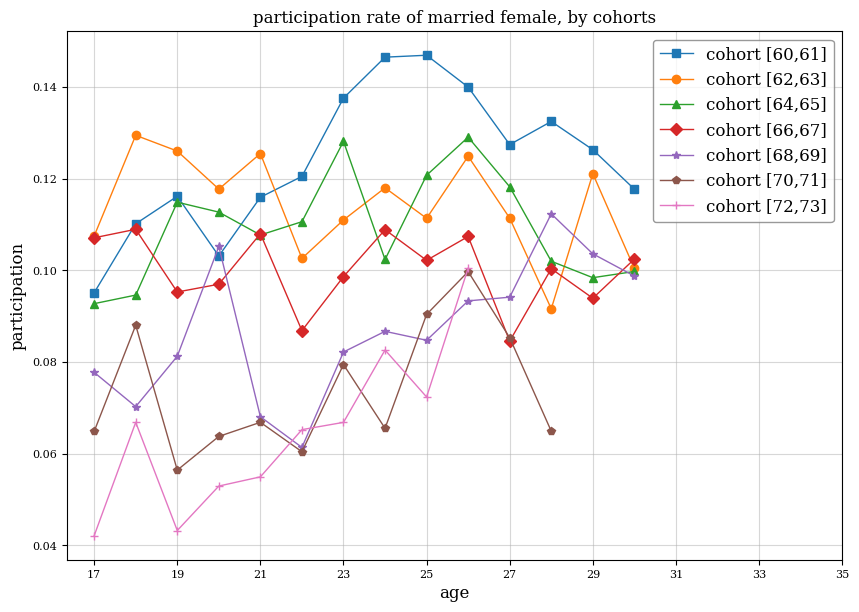

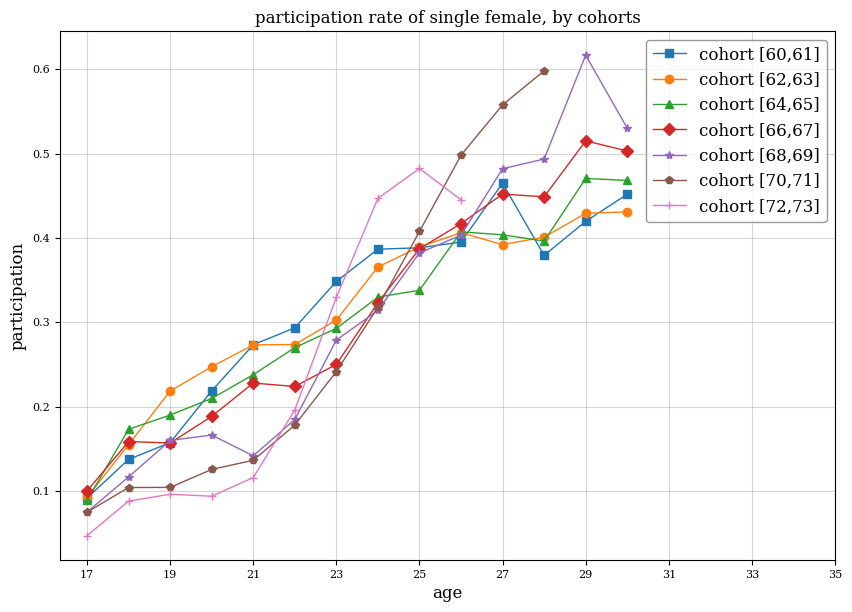

In [64]:
gender= 'female'
#########################
for married in ['married', 'single']:
    for stat in ['participation']:
        fig=plt.figure(figsize=(10,7))

        for index,cohort in enumerate(groupAgeGenderCohortMar['cohort'].unique()):
            plt.plot('age', stat ,'-o',
                    data=groupAgeGenderCohortMar[(groupAgeGenderCohortMar['age']>16)
                                            &(groupAgeGenderCohortMar['age']<35)
                                            &(groupAgeGenderCohortMar['cohort']==cohort)
                                            &(groupAgeGenderCohortMar['gender']== genderCode[gender])
                                            &(groupAgeGenderCohortMar['married']==married)],
                    label=f'cohort {cohort}',
                    marker=marker[index], linewidth=1)
        plt.title(f'{stat} rate of {married} {gender}, by cohorts')
        plt.xlabel('age',fontsize=12)
        plt.xticks(np.arange(17,36,2))
        plt.ylabel(f'{stat}',fontsize=12)

        plt.grid(axis='both', alpha=0.5)
        plt.legend(loc='best',edgecolor='gray',prop={'size':12})
        plt.show()

<br>

# Decision of individuals in each period based on model
<br>

## Defining choice of individual in the each period(=year)

**1.** if person is employed, choice is assigned to the collor type of occuptation, mean:
    
    1. choice is 'blue' if blue collar occupation
    2. choice is 'white' if white collar occupation 
    3. choice is 'military' if in the mandatory military servie

some notes: We first consider occupation of a individuals rather than thier schooling status, althogh
the number of people studying and working at the same time is lower than 2 percent each year.

and also we put asside from data individuals employed in military, but not whom in mandatory military 
service, which is a situation that most of men encounter with during their youth.


**2.** then if person is not employed and report student that year, we assign 'student' to their choice variable. (even when the person did not stduy during the pas week)


**3.** if person is not student but unemployed, choice variable is set to 'unemployed'


**4.** if none of above, choice is 'home' meaning person decided to stay at home.

<br>

In [20]:
# we just consider people between 18 and 65 years old from now.
data= data.loc[(data.age>=16)&(data.age<=65),:]

data.drop(columns=['choice'],inplace=True,errors="ignore")

# define decision of each individual in each year
data.loc[(data.labor== 2) , 'choice']= 'unemployed'


data.loc[(data.labor==5), 'choice']= 'home'
data.loc[(data.labor==3), 'choice']= 'home'


data.loc[(data.student==1),'choice']= 'study'
data.loc[(data.labor==4),'choice']= 'study'

data.loc[(data.collar==1),'choice']= 'blue'
data.loc[(data.collar==0),'choice']= 'white'

data.loc[(data.occupation== 112)
         &(data.year<=95)
         &(data.year>=78)
         &(data.gender==1),'choice']= 'military'
data.loc[(data.occupation== 510)
         &(data.year.isin([96,97,98]))
         &(data.gender==1),'choice']= 'military'
data.loc[(data.occupation== 12)
         &(data.year.isin([76,77]))
         &(data.gender==1),'choice']= 'military'



# change the type of choice to category
data.choice= pd.Categorical(data.choice,
                            categories=['home', 'study', 'unemployed', 'blue', 'white','military'],
                            ordered=True)

# data=data.astype({'choice': 'category'},cat)

<br>

define dummy variable for each choice for calculating weighted average of each decision in each year.

In [21]:
dummy=pd.get_dummies(data['choice'],dtype='float16')
dummy.loc[data.choice.isna(), :] = np.nan
data=pd.concat([data,dummy],axis=1)
del dummy

<br>

## Career decisions by year


In [22]:
groupDataYearGender= data.groupby(by=(['year', 'gender'])).agg( \
                            {'home':wm,'study':wm,'unemployed':wm,'blue':wm,'white':wm,'military':wm}).\
                            reset_index()
groupDataYearGender["home"] = groupDataYearGender.home + groupDataYearGender.unemployed

In [23]:
groupDataYearGender.loc[(groupDataYearGender.gender==1),:]

year gender  home  study  unemployed  blue  white  military
1     76  1.000 0.092  0.127       0.060 0.645  0.126     0.011
3     77  1.000 0.094  0.128       0.065 0.642  0.122     0.015
5     78  1.000 0.096  0.126       0.066 0.638  0.121     0.018
7     79  1.000 0.099  0.125       0.067 0.636  0.127     0.012
9     80  1.000 0.113  0.125       0.076 0.623  0.128     0.012
11    81  1.000 0.114  0.123       0.076 0.623  0.125     0.015
13    82  1.000 0.109  0.110       0.072 0.643  0.123     0.016
15    83  1.000 0.114  0.116       0.073 0.629  0.129     0.012
17    84  1.000 0.124  0.117       0.079 0.617  0.129     0.013
19    85  1.000 0.126  0.117       0.074 0.618  0.127     0.012
21    86  1.000 0.115  0.116       0.060 0.629  0.124     0.016
23    87  1.000 0.139  0.120       0.076 0.606  0.118     0.017
25    88  1.000 0.163  0.120       0.088 0.586  0.115     0.016
27    89  1.000 0.170  0.122       0.088 0.580  0.116     0.013
29    90  1.000 0.189  0.130       0.106 0.561  0.109     0.011
31    91  1.000 0.186  0.124       0.101 0.562  0.113     0.014
33    92  1.000 0.173  0.117       0.085 0.580  0.120     0.011
35    93  1.000 0.180  0.119       0.089 0.568  0.123     0.011
37    94  1.000 0.187  0.110       0.092 0.574  0.118     0.011
39    95  1.000 0.192  0.104       0.096 0.573  0.119     0.011
41    96  1.000 0.187  0.098       0.091 0.577  0.126     0.013
43    97  1.000 0.185  0.093       0.087 0.579  0.130     0.013
45    98  1.000 0.196  0.092       0.090 0.567  0.132     0.013

In [24]:
1.1/4

0.275

In [25]:
(65-15)

50

<br>

*graph*
**Male career decision by year (weighted calculation)**


In [26]:
# ######################################################
# ## English ##
# ######################################################
# # stat={'male': ['study','white','home','military'] ,
# #       'female': ['study','white','blue']}

# # for gender in ['male', 'female']:
# #     fig=plt.figure(figsize=(11, 6.5))
# #     ax1=fig.add_subplot(1,1,1)
# #     for index, choice in enumerate(stat[gender]):
# #         ax1.plot('year',choice, 
# #                 data=groupDataYearGender[groupDataYearGender.gender== genderCode[gender]],
# #                 label=choice , linewidth=0.8, marker=marker[index])    

# #     ax1.set_title(f'career decision of {gender} by year', fontsize= 14)
# #     ax1.set_xlabel('year',fontsize=11,labelpad=10,fontweight='bold')
# #     ax1.set_ylabel('share',fontsize=11,labelpad=10,fontweight='bold')
# #     ax1.set_xticks(np.arange(76,99))
# #     # ax1.set_ylim(-0.024 , 0.92)
# #     # ax1.set_yticks(np.arange(0, 0.91, 0.1))
# #     ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation=45)

# #     ax1.grid(axis='y',alpha=0.5)
# #     lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'size':12}
# #                   , bbox_to_anchor=(0.5, -0.16),ncol=6,handlelength=2)
# #     # Hide the right and top spines
# #     ax1.spines['right'].set_visible(False)
# #     ax1.spines['top'].set_visible(False)
# #     plt.show()

# ######################################################
# ## Farsi ##
# ######################################################

# statFarsi = {"male" :["مشاغل یقه-سفید",
#                 "در حال تحصیل",
#                 "در خانه",
#                 "سربازی"] ,
#         "female":["مشاغل یقه-آبی",
#                 "مشاغل یقه-سفید",
#                 "در حال تحصیل"]}

# stat={'male': ['white','study','home','military'] ,
#       'female': ['blue','white','study']}

# for gender in ['male', 'female']:
#     fig=plt.figure(figsize=(11, 6.5))
#     ax1=fig.add_subplot(1,1,1)
#     for index, choice in enumerate(stat[gender]):
#         ax1.plot('year',choice, 
#                 data=groupDataYearGender[groupDataYearGender.gender== genderCode[gender]],
#                 label=farsi(statFarsi[gender][index])
#                 ,linewidth=0.8, marker=marker[index])    

# #     ax1.set_title(f'career decision of {gender} by year', fontsize= 14)
#     ax1.set_xlabel(farsi('سال شمسی'),fontdict={'family': 'B Yas','size': 20},labelpad=5)
#     ax1.set_ylabel(farsi('نسبت از کل'),fontdict={'family': 'B Yas','size': 20},labelpad=10)
#     ax1.set_xticks(np.arange(76,99))
#     ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation=45)
# #     ax1.tick_params(labelsize=11.5)
#     ax1.grid(axis='y',alpha=0.5)
#     lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'family': 'B Yas','size':14}
#                   , bbox_to_anchor=(0.5, -0.16),ncol=6,handlelength=2)

#     # Hide the right and top spines
#     ax1.spines['right'].set_visible(False)
#     ax1.spines['top'].set_visible(False)
#     plt.show()
# #     fig.savefig(f"Results/career decision of {gender} by year.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [27]:
# ######################################################
# ## Farsi ##
# ######################################################

# statFarsi = {"male" :["مشاغل یقه-سفید",
#                 "در حال تحصیل",
#                 "در خانه",
#                 "سربازی"] ,
#         "female":["مشاغل یقه-آبی",
#                 "مشاغل یقه-سفید",
#                 "در حال تحصیل"]}

# stat={'male': ['white','study','home','military'] ,
#       'female': ['blue','white','study']}

# gender = 'male'

# fig=plt.figure(figsize=(11, 6.5))
# ax1=fig.add_subplot(1,1,1)
# for index, choice in enumerate(stat[gender]):
#     ax1.plot('year',choice, 
#              alpha = 0.8 ,
#             data=groupDataYearGender[groupDataYearGender.gender== genderCode[gender]],
#             label=farsi(statFarsi[gender][index])
#             ,linewidth=0.8, marker=marker[index+1])    

# #     ax1.set_title(f'career decision of {gender} by year', fontsize= 14)
# ax1.set_xlabel(farsi('سال شمسی'),fontdict={'family': 'B Yas','size': 20},labelpad=5)
# ax1.set_ylabel(farsi('نسبت از کل'),fontdict={'family': 'B Yas','size': 20},labelpad=10)
# ax1.set_xticks(np.arange(76,99))
# ax1.set_xticklabels([year for year in np.arange(1376,1399)],rotation=45)
# #     ax1.tick_params(labelsize=11.5)
# ax1.set_ylim(-0.015,0.3)

# ax1.grid(axis='y',alpha=0.5)
# lgd=ax1.legend(loc='upper center',edgecolor='w',prop={'family': 'B Yas','size':14}
#               , bbox_to_anchor=(0.4, -0.16),ncol=6,handlelength=2)


# ax2=ax1.twinx()
# for index, choice in enumerate(["blue"]):
#     ax2.plot('year',choice,
#             dashes = [6,4] ,
#             data=groupDataYearGender[groupDataYearGender.gender== genderCode[gender]],
#             label=farsi("مشاغل یقه-آبی")
#             ,linewidth=0.8, marker=marker[index]
#             ,color = (0,0,0,0.9))

# ax2.set_ylim(0.2,0.7)
# lgd=ax2.legend(loc='upper center',edgecolor='w',prop={'family': 'B Yas','size':14}
#               , bbox_to_anchor=(0.87, -0.16),ncol=6,handlelength=2)
# ax2.set_ylabel(farsi('نسبت مشاغل یقه-آبی از کل'),fontdict={'family': 'B Yas','size': 19},labelpad=10)

# ax2.spines['right'].set_linestyle((0,(6,4)))
# ax1.spines['right'].set_linestyle((0,(6,4)))
# ax2.tick_params(axis='y', colors=(0,0,0,0.9))
# ax2.spines['right'].set_color((0,0,0,0.9))

# # # Hide the right and top spines
# # ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax2.spines['top'].set_visible(False)

# plt.show()
# # fig.savefig(f"Results/career decision of {gender} by year.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


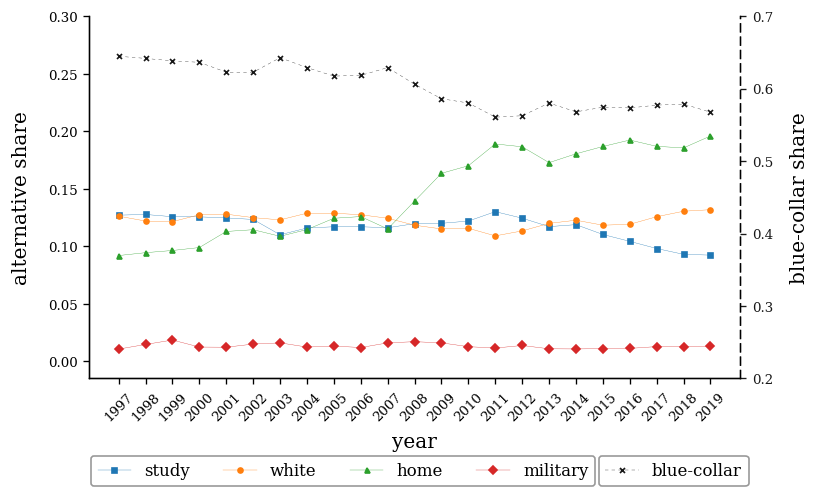

In [28]:
## %matplotlib inline
#####################################################
# English ##
#####################################################
stat={'male': ['study','white','home','military'] ,
      'female': ['study','white','blue']}
fSize = 12
tSize = 8

for gender in ['male']:
    
    fig=plt.figure(figsize=(7, 4))
    plt.rc('font', family='serif')
    plt.rc('xtick',labelsize=tSize)
    plt.rc('ytick',labelsize=tSize)

    ax1=fig.add_subplot(1,1,1)
    
    
    ax2=ax1.twinx()
    for index, choice in enumerate(["blue"]):
        lns = ax2.plot('year',choice,"x",
                dashes = [10,10] ,
                data=groupDataYearGender[groupDataYearGender.gender== genderCode[gender]],
                label="blue-collar"
                ,linewidth=0.2
                ,color = (0,0,0,0.9)
                ,markersize=3)
        
        
    for index, choice in enumerate(stat[gender]):
        one = ax1.plot('year',choice, 
                data=groupDataYearGender[groupDataYearGender.gender== genderCode[gender]],
                label=choice , linewidth=0.2, marker=marker[index],
                markersize=3
                #,color = (0,0,0,0.7)
                      )  
        lns = lns + one

    ax1.set_xlabel('year',             fontsize=fSize,labelpad=5)
    ax1.set_ylabel('alternative share',fontsize=fSize,labelpad=10)
    ax2.set_ylabel('blue-collar share',fontsize=fSize,labelpad=10)

    ax1.set_xticks(np.arange(76,99))
    ax1.set_xticklabels([year+621 for year in np.arange(1376,1399)],rotation=45)
    
    # ax1.set_yticks(np.arange(0,0.31,0.05))
    # ax1.set_yticklabels([f"{share*100:.0f} %" for share in np.arange(0,0.31,0.05)])
    ax1.set_ylim(-0.015,0.3)

    
    
    ax2.spines['right'].set_linestyle((0,(6,4)))
    ax1.spines['right'].set_linestyle((0,(6,4)))
    ax2.tick_params(axis='y', colors=(0,0,0,0.9))
    ax2.spines['right'].set_color((0,0,0,0.9))
    ax2.set_ylim(0.2,0.7)
    
    labs = [l.get_label() for l in lns ]
    lgd=ax2.legend(loc='upper left',edgecolor='gray',prop={'size':10}
                  , bbox_to_anchor=(0.77, -0.19),ncol=6,handlelength=2)
    lgd=ax1.legend(loc='upper right',edgecolor='gray',prop={'size':10}
                  , bbox_to_anchor=(0.79, -0.19),ncol=6,handlelength=2)
    
    
    #ax1.grid(axis='y',alpha=0.5)
    ax2.spines['top'].set_visible(False)
    ax1.spines['top'].set_visible(False)

# plt.savefig(r'Results/Paper/career decision of men by year.pgf',bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

# fig.savefig(f"Results/Paper/career decision of men by year.pdf", bbox_extra_artists=(lgd,), 
#             bbox_inches='tight',dpi=500)


<br>

## Life cycle decisions of different cohort

In [29]:
# change directory to folder output 
# os.chdir("E:\This_Term\Thesis other things\Data\HIES data\output")

In [30]:
########################
## weighted calculation
groupGenderAgeBirth=data[(data['age']>=16)
                  &(data['age']<=40)
                  &(data['birth_y']>=50)].groupby(by=(['age','birth_y','gender'])). \
            agg({'home':wm,'study':wm,'unemployed':wm,'blue':wm,'white':wm,'military':wm}).\
            reset_index()

########################
# unweighted calculation
# groupGenderAgeBirth=data[(data['age']>=16)
#                   &(data['age']<=40)].groupby(by=(['age','birth_y','gender']))['choice']

# groupGenderAgeBirth=groupGenderAgeBirth.value_counts(normalize=True).unstack().reset_index() #\

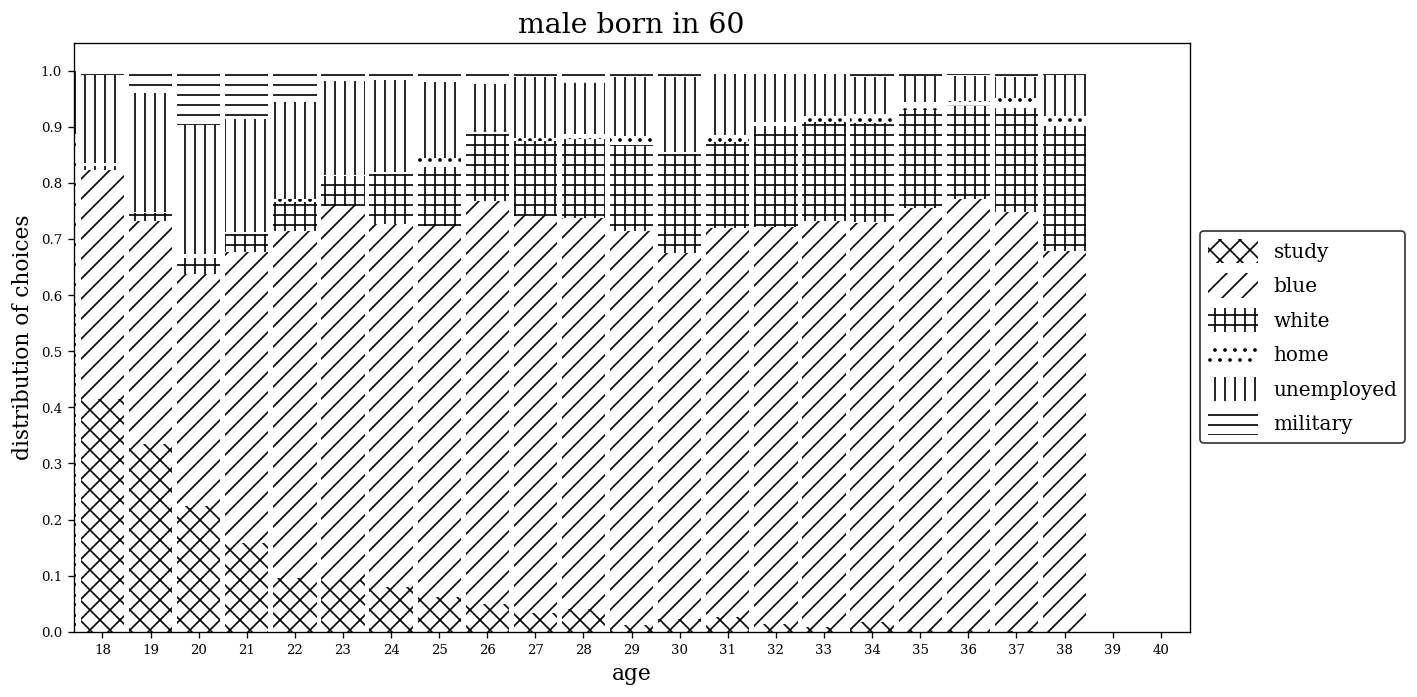

In [31]:
####################################
## Input cohort and gender for graph
# cohort= 60
gender= 'male'

hatch=['xx', '//', '++', '..', '||','--']
choices=['study','blue','white','home', 'unemployed','military']


for cohort in np.arange(60,61,1):
    
    fig=plt.figure(figsize=(12,6.5))
    ax1 = fig.add_subplot(111)
    group1=groupGenderAgeBirth[(groupGenderAgeBirth.birth_y.isin([cohort]))
                              &(groupGenderAgeBirth.gender==genderCode[gender])]
    
    for index, choice in enumerate(choices):
         ax1.bar(group1.age,group1[choice],
                label= choices[index] ,
                width=0.9, 
                color='w', 
                hatch=hatch[index],
                bottom=group1[choices[0:index]].sum(axis=1),
                alpha = 0.8)       

    ax1.set_title(f'{gender} born in {cohort}',fontsize=17)
    ax1.set_xlabel('age',fontsize=13)
    ax1.set_ylabel('distribution of choices',fontsize=13)
    ax1.set_xticks(np.arange(18,41,1))
    ax1.set_xlim(17.4,40.6)
    ax1.set_yticks(np.arange(0,1.001,0.1))#,fontweight='bold')
    lgd=ax1.legend(loc='center left',edgecolor='black',prop={'size':12}
              , bbox_to_anchor=(1, 0.5),ncol=1, handlelength=2.5,handleheight=1.5)


    plt.show()
#     fig.savefig(f"\Male borin in {cohort}.png", bbox_extra_artists=(lgd,)
#                 , bbox_inches='tight')
#     plt.close()

In [32]:
# groupGenderAgeBirth[(groupGenderAgeBirth.age==23)
#                     &(groupGenderAgeBirth.gender==1)]

<br>

## Cohort Analysis

<br>

### Every two year

In [28]:
# cohort: in this case is for every two years since 1360-1373
data['cohort']= pd.cut(x=data['birth_y'],bins=np.arange(59,74,2),
                       labels=[f'[{year+1},{year+2}]' for year in np.arange(59,73,2)])

groupAgeGenderCohort=data[(data['age']>=16) & (data['age']<=35)].groupby(by=['gender', 'age','cohort']).agg({
        'study':wm,'unemployed':wm,'blue':wm,'white':wm,'military':wm,'home':wm}).reset_index()


data.drop(columns=['cohort'], inplace=True)

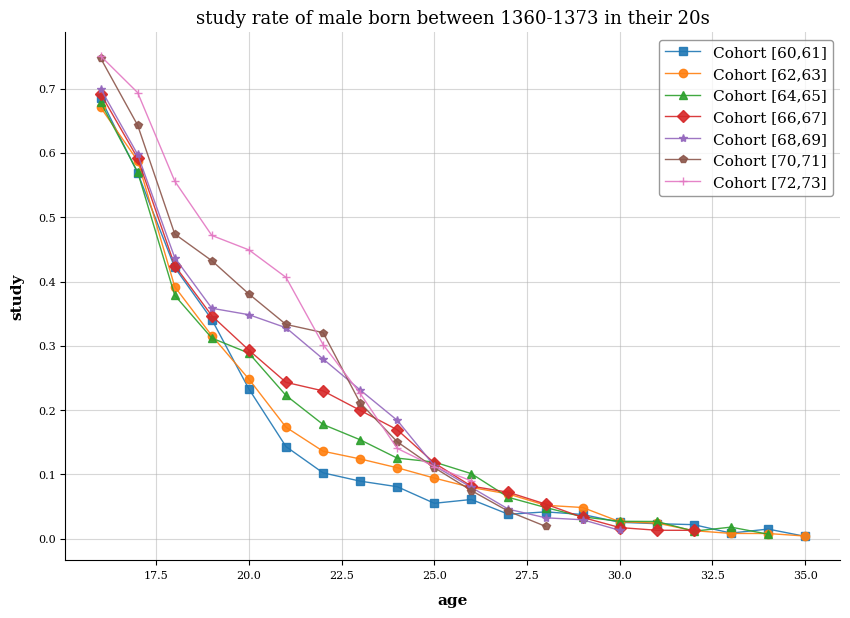

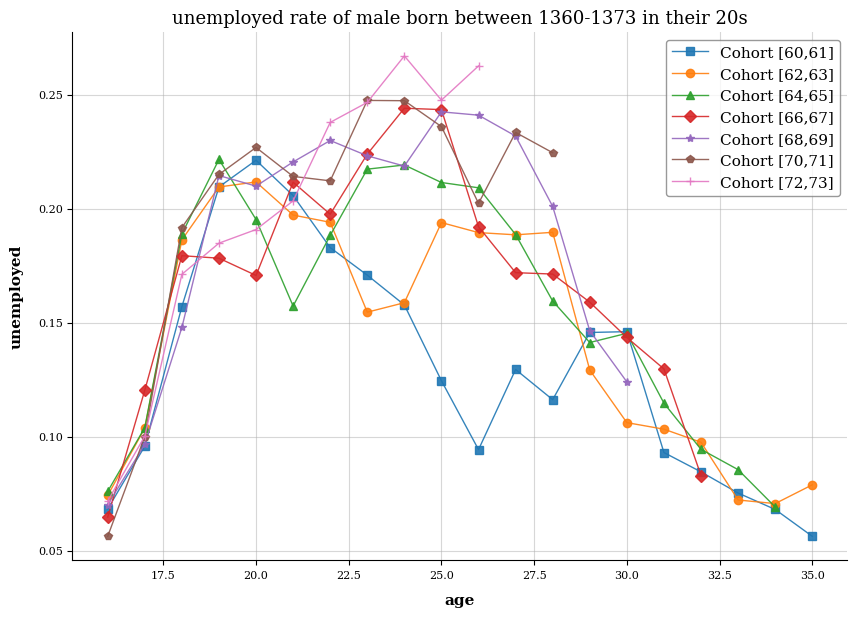

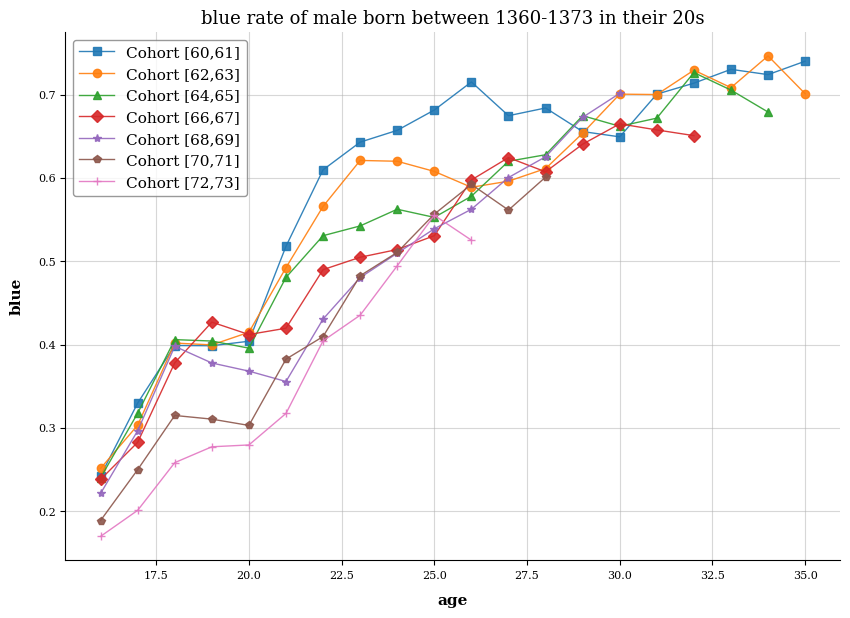

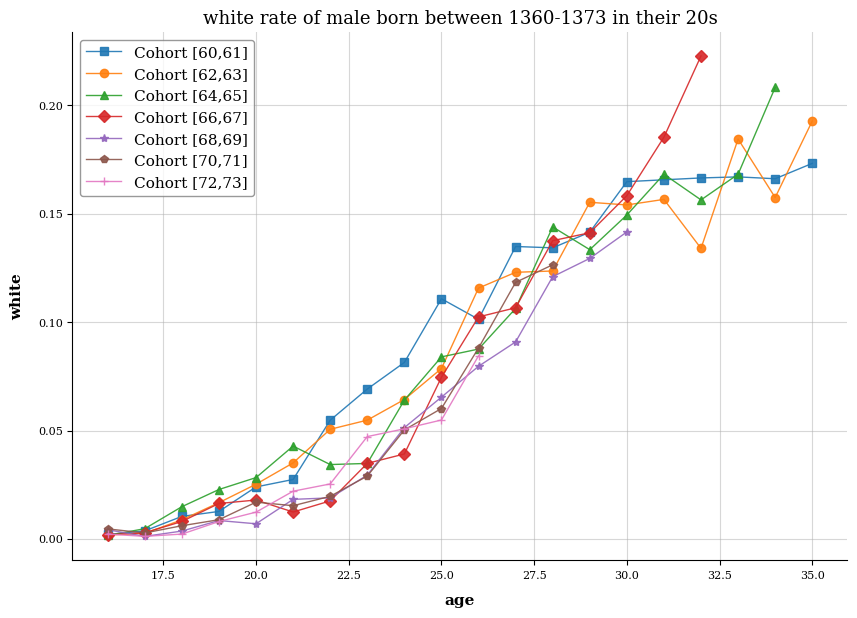

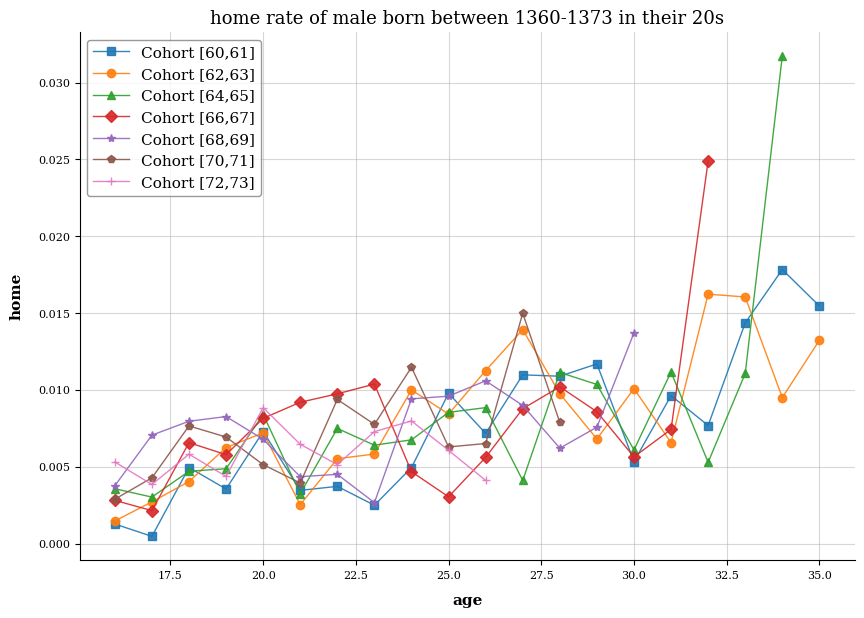

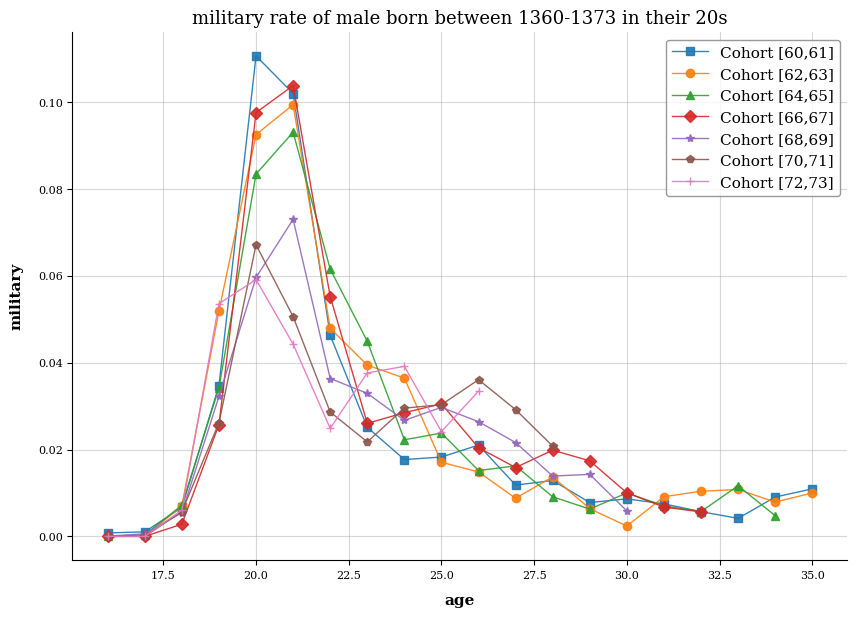

In [76]:

###################
#plot figure
###################

for stat in ['study', 'unemployed','blue', 'white','home','military']:
    gender= 'male'
    fig = plt.figure(figsize=(10,7))
    ax1=fig.add_subplot(1,1,1)
    for index,cohort in enumerate(groupAgeGenderCohort['cohort'].unique()):
        ax1.plot('age', stat,
                 data=groupAgeGenderCohort[(groupAgeGenderCohort['gender']== genderCode[gender])
                                           &(groupAgeGenderCohort['cohort']==cohort)]
                 ,label=f'Cohort {cohort}', alpha=0.9,
                 marker=marker[index] , linewidth=1)

    ax1.set_title(f'{stat} rate of {gender} born between 1360-1373 in their 20s',fontsize=13)
    ax1.set_xlabel('age',fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_ylabel(f'{stat}',fontsize=11,labelpad=10,fontweight='bold')
    ax1.grid(axis='both',alpha=0.5)
    ax1.legend(loc='best',prop={'size':11}, edgecolor='gray', handlelength=2.3)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
#     gender= 'female'
#     ax2=fig.add_subplot(1,2,2)
    
#     for index,cohort in enumerate(groupAgeGenderCohort['cohort'].unique()):
#         ax2.plot('age', stat,
#                  data=groupAgeGenderCohort[(groupAgeGenderCohort['gender']== genderCode[gender])
#                                            &(groupAgeGenderCohort['cohort']==cohort)]
#                  ,label=f'Cohort {cohort}', alpha=0.9,
#                  marker=marker[index] , linewidth=1)

#     ax2.set_title(f'{stat} rate of {gender} born between 1360-1373 in their 20s',fontsize=13)
#     ax2.set_xlabel('age',fontsize=11,labelpad=10,fontweight='bold')
#     ax2.set_ylabel(f'{stat}',fontsize=11,labelpad=10,fontweight='bold')
#     ax2.grid(axis='both',alpha=0.5)
#     ax2.legend(loc='best',prop={'size':11}, edgecolor='gray')#, handlelength=2.3)
#     # Hide the right and top spines
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
    plt.show()


In [30]:
groupAgeGenderCohort[groupAgeGenderCohort.gender==1].groupby(by=['cohort']).agg({'military':'sum'})/2

military
cohort           
[60,61]     0.231
[62,63]     0.243
[64,65]     0.229
[66,67]     0.233
[68,69]     0.189
[70,71]     0.173
[72,73]     0.161

### Every five year

In [31]:
data['cohort5']= pd.cut(x=data.loc[:,'birth_y'],bins=np.arange(49,81,5),
                       labels=[f'[{year+1},{year+5}]' for year in np.arange(49,79,5)])

groupAgeGenderCohort5=data.groupby(by=['age','cohort5','gender']).agg(
            {'study':wm,'unemployed':wm,'blue':wm,'white':wm,'military':wm,'home':wm }
            ).reset_index()

data.drop(columns=['cohort5'], inplace= True)

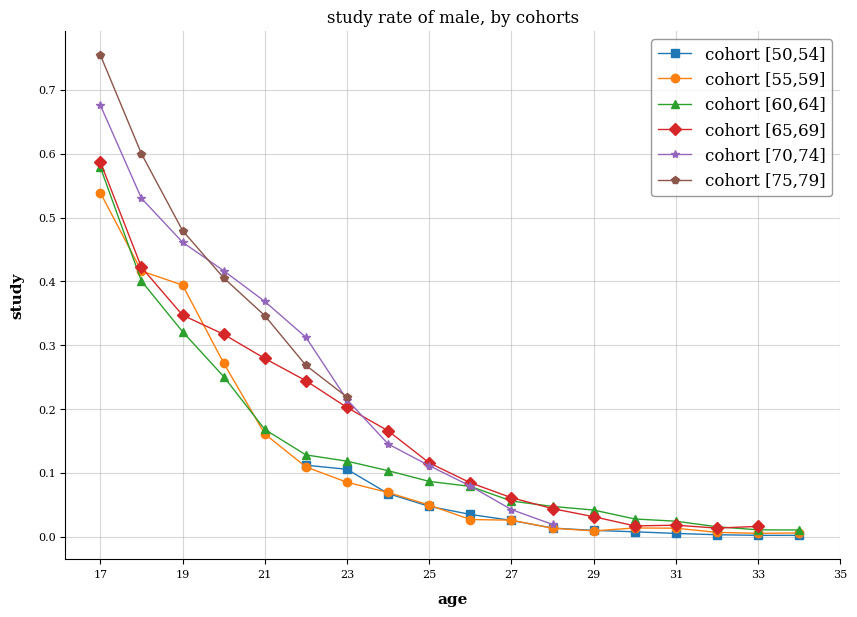

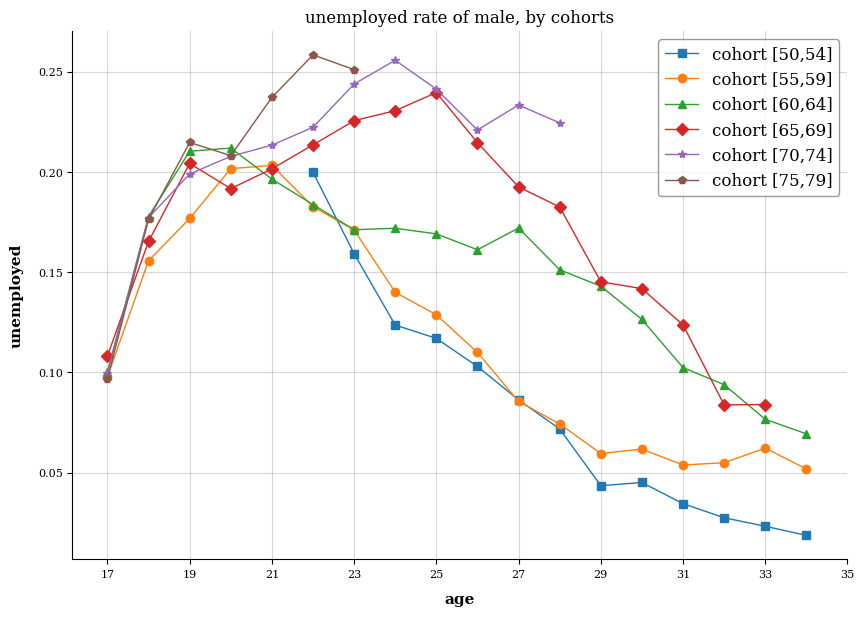

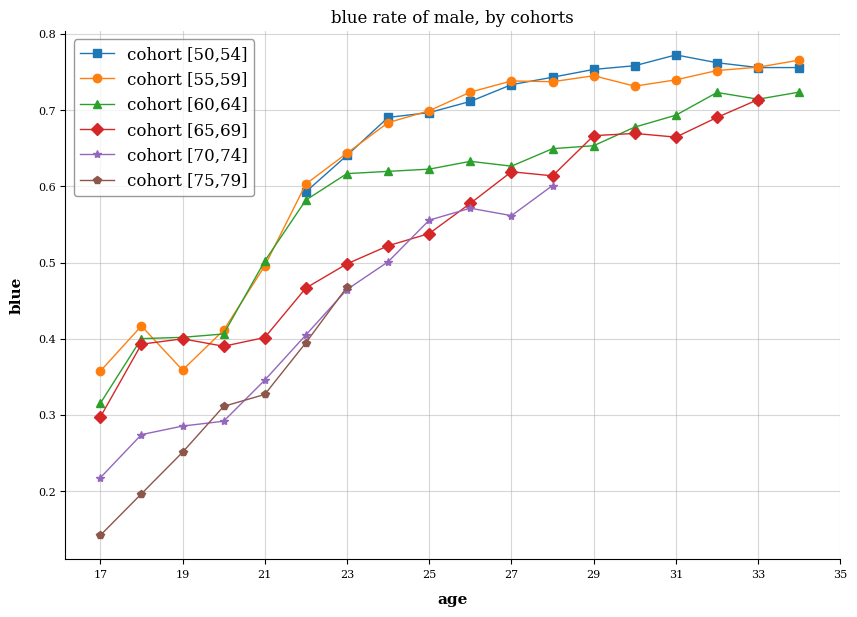

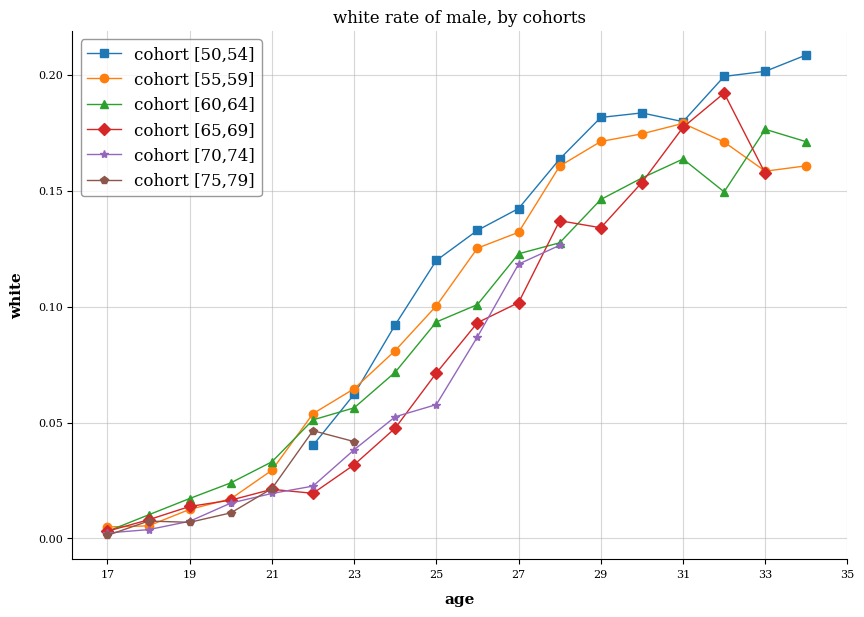

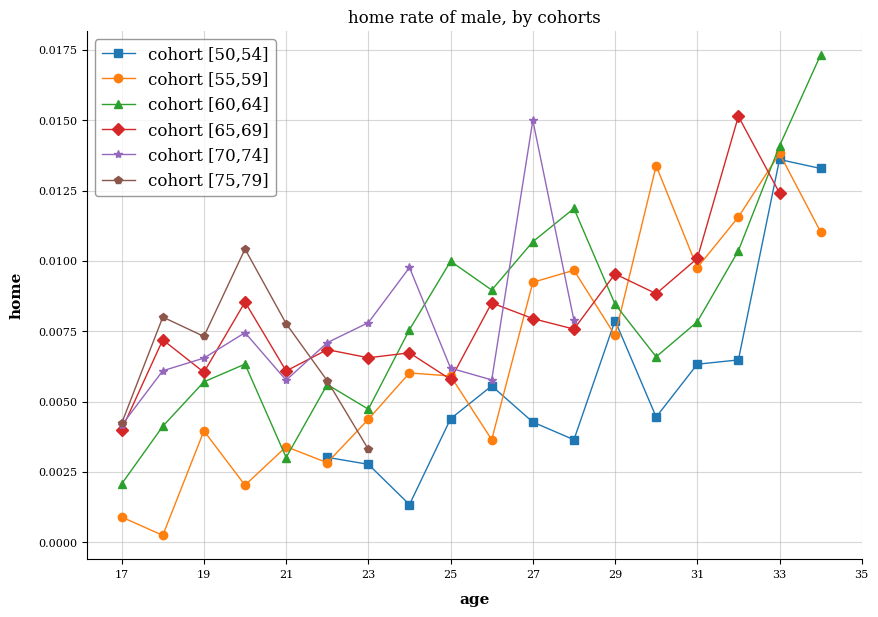

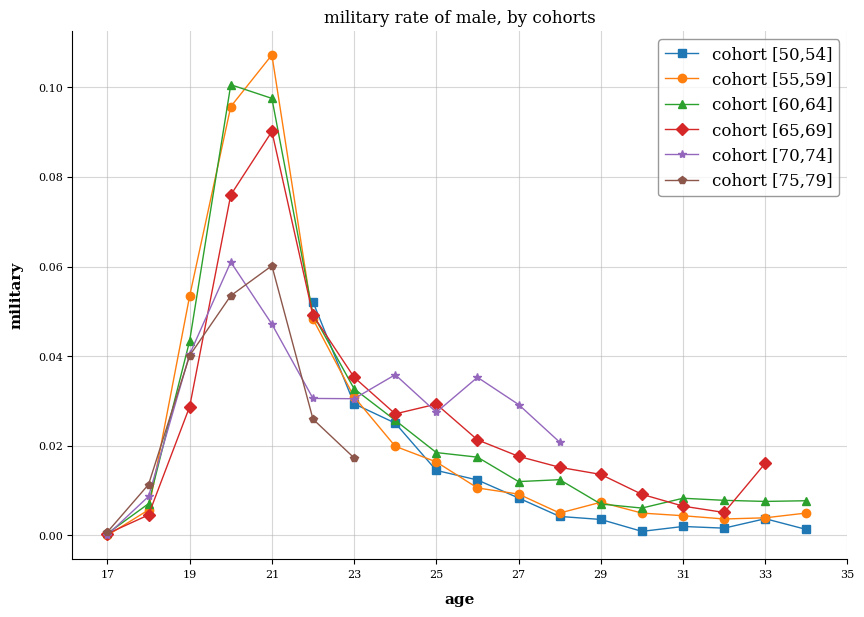

In [79]:
gender= 'male'
#########################

for stat in ['study', 'unemployed','blue', 'white','home','military']:
    fig = plt.figure(figsize=(10,7))
    ax1=fig.add_subplot(1,1,1)

    for index,cohort in enumerate(groupAgeGenderCohort5['cohort5'].unique()):
        plt.plot('age', stat ,'-o',
                data=groupAgeGenderCohort5[(groupAgeGenderCohort5['age']>16)
                                        &(groupAgeGenderCohort5['age']<35)
                                        &(groupAgeGenderCohort5['cohort5']==cohort)
                                        &(groupAgeGenderCohort5['gender']== genderCode[gender])],
                label=f'cohort {cohort}',
                marker=marker[index], linewidth=1)
    ax1.set_title(f'{stat} rate of {gender}, by cohorts')
    ax1.set_xlabel('age',fontsize=11,labelpad=10,fontweight='bold')
    ax1.set_xticks(np.arange(17,36,2))
    ax1.set_ylabel(f'{stat}',fontsize=11,labelpad=10,fontweight='bold')

    ax1.grid(axis='both',alpha=0.5)
    ax1.legend(loc='best',edgecolor='gray',prop={'size':12})
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.show()

In [36]:
groupAgeGenderCohort5[groupAgeGenderCohort5.gender==1].groupby(by=['cohort5']).agg({'military':'sum'})/2

military
cohort5          
[50,54]     0.125
[55,59]     0.254
[60,64]     0.246
[65,69]     0.223
[70,74]     0.183
[75,79]     0.105

In [ ]:
# data.drop(columns=['home','study','unemployed','blue','white','military'],inplace=True)

<br>

# Wage and salary income 


<br>

In [43]:
data.drop(columns=['cpi'], inplace=True, errors="ignore")
cpi= pd.DataFrame(data={'year':np.arange(76,99),
                       'cpi':[5.298, 6.258, 7.516, 8.463, 9.427, 10.915,
                              12.624, 14.544, 16.048, 17.955, 21.265, 26.66,
                              29.527, 33.188, 40.321, 52.635, 70.916, 81.948,
                              91.714, 100, 109.6, 137.3, 185.3 ]})

data= pd.merge(data, cpi, on=['year'], how='left')
data=data.astype({'cpi':'float16'})

In [44]:
######################
# real income and also equivalent income is created hear:
data['realIncome']= data.income1/ data.cpi * 100 
data.loc[(data.realIncome<=0), 'realIncome'] = np.nan


data['totalHour']= data.day*data.hour
data.loc[(data.totalHour<=15), 'totalHour']= np.nan

data.loc[(data.year<=83)&(data.gender==0)&(data.totalHour.notna()), 'totalHour']= np.nan #38.5
data.loc[(data.year<=83)&(data.gender==1)&(data.totalHour.notna()), 'totalHour']= np.nan #50

data['equivalentIncome'] = data.realIncome * 40/(data.totalHour)

# data['LogEquivalentIncome'] = np.log(data.equivalentIncome)

In [45]:
data[data.year==98].realIncome.describe()

count        22174.000
mean     103757312.000
std       79680280.000
min         117894.742
25%       45344128.000
50%       89068824.000
75%      142510128.000
max     1943319808.000
Name: realIncome, dtype: float64

estimate working time of individuals based on their charectristics:

In [46]:
# EUSHours = pd.read_csv("E:\This_Term\Thesis other things\Data\hourEstimated.csv")

# EUSHours["gender"]=EUSHours.gender.map({"male":1, "female":0})


# hourEstimated=data.groupby(
#     by=['birth_y','gender','year','educated','collar','married']).agg({
#     'totalHour':wm}).reset_index()

# hourEstimated.rename(columns={"totalHour":"hourEstimated"}, inplace=True)

# data.drop(columns=["hourEstimated"],inplace=True)
# data=pd.merge(data,hourEstimated
#         ,on=['birth_y','gender','year','educated','collar','married']
#         ,how="left")

# data.loc[(data.year<84), "hourEstimated"]= data.EUSEstimated

# data.loc[(data.hourEstimated<=0),"hourEstimated"]=np.nan
data['equivalentIncomeTest'] = data.realIncome #* 40 /data.hourEstimated

<br>

## By year and gender

**log average earning by gedner**

<br>

In [84]:
incomeYearGender=data.groupby(by=['gender','year']).agg({
    'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()
incomeYearGender['LogEquivalentIncome']=np.log(incomeYearGender.equivalentIncome)

## test new idea
# incomeYearGender['equivalentIncomeTest']=incomeYearGender.realIncome* 40/ \
#     incomeYearGender.totalHour
incomeYearGender['LogEquivalentIncomeTest']=np.log(incomeYearGender.equivalentIncomeTest)

######################
# incomeYearGenderRU=data.groupby(by=['gender','year','RU']).agg({
#     'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()
# incomeYearGenderRU['LogEquivalentIncome']=np.log(incomeYearGenderRU.equivalentIncome)

## test new idea
# incomeYearGenderRU['equivalentIncomeTest']=incomeYearGenderRU.realIncome* 40/ \
#     incomeYearGenderRU.totalHour
# incomeYearGenderRU['LogEquivalentIncomeTest']=np.log(incomeYearGenderRU.equivalentIncomeTest)

*graph:* **log earning of men and women, both actual and equivalent one**

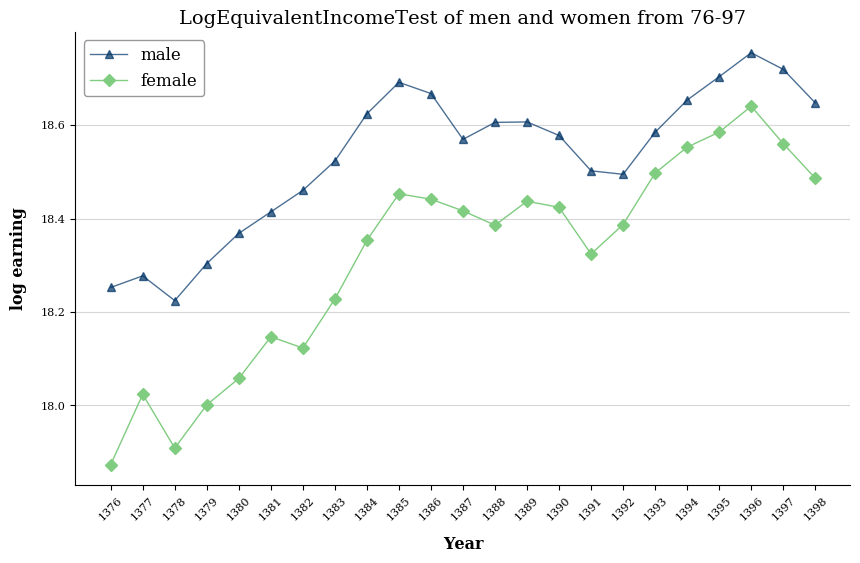

In [85]:
earning = "LogEquivalentIncomeTest"
# for earning in ["LogEquivalentIncome","LogEquivalentIncomeTest"]:
fig=plt.figure(figsize=(10,6))

ax1=fig.add_subplot(1,1,1)
#     for index,gender in enumerate(['male','female']):
#         ax1.scatter('year', earning,
#                 data=incomeYearGender[(incomeYearGender.gender== genderCode[gender])
#                                       &(incomeYearGender.year>=84)],
#                 label=f'{gender} actual earning',
#                 color=(0,0.2,0.4,0.7) if gender=='male' else (0.5,0.8,0.5,1) ,
#                 marker=marker[index], linewidth=1 )

for index,gender in enumerate(['male','female']):
    ax1.plot('year', earning,
            data=incomeYearGender[(incomeYearGender.gender== genderCode[gender])],
            label=f'{gender}',
            color=(0,0.2,0.4,0.7) if gender=='male' else (0.5,0.8,0.5,1) ,
            marker=marker[index+2], linewidth=1 )



ax1.set_title(f'{earning} of men and women from 76-97', fontsize=14)
ax1.set_xlabel('Year', fontsize=11.5, fontweight= 'bold',labelpad=10)
ax1.set_ylabel('log earning', fontsize=11.5, fontweight= 'bold',labelpad=10)
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
# ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y', alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()
# figure.savefig('./output/')

<br>

## By year, gender, occupation

<br>

In [86]:
incomeYearGenderCollar=data.groupby(by=['gender','year','collar']).agg({
    'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()
incomeYearGenderCollar['LogEquivalentIncome']=np.log(incomeYearGenderCollar.equivalentIncome)
incomeYearGenderCollar['LogEquivalentIncomeTest']=np.log(incomeYearGenderCollar.equivalentIncomeTest)

#*********************
# incomeYearGenderCollarRU=data.groupby(by=['gender','year','collar','RU']).agg({
#     'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()
# incomeYearGenderCollarRU['LogEquivalentIncome']=np.log(incomeYearGenderCollarRU.equivalentIncome)
# incomeYearGenderCollarRU['LogEquivalentIncomeTest']=np.log(
#     incomeYearGenderCollarRU.equivalentIncomeTest)

*graph:* **log equivalent earning by gender and occupation** 

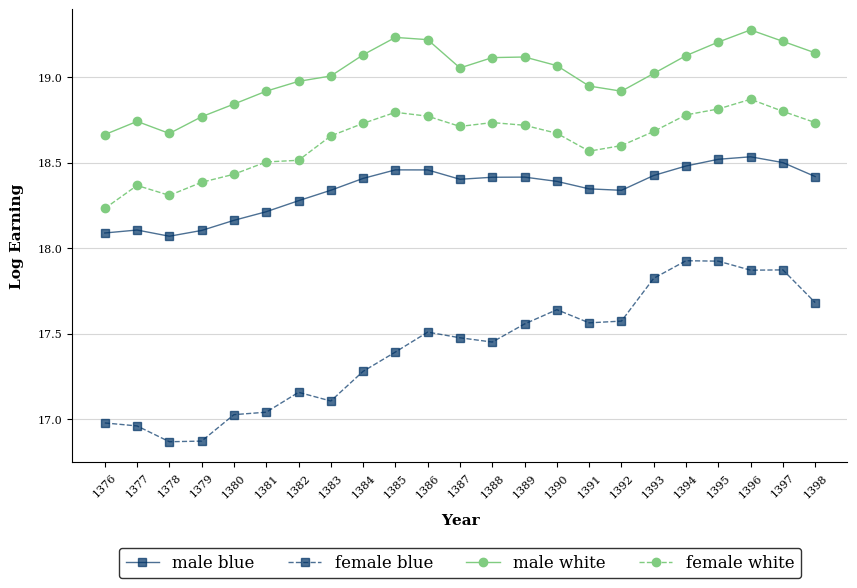

In [87]:
fig=plt.figure(figsize=(10,6))

ax1=fig.add_subplot(1,1,1)

for index,collar in enumerate(['blue','white']):
#     for gender in ['male','female']:   
#         ax1.scatter('year','LogEquivalentIncome',
#                 data=incomeYearGenderCollar[(incomeYearGenderCollar.gender== genderCode[gender])
#                                            &(incomeYearGenderCollar.collar== collarCode[collar])],
#                 color=(0,0.2,0.4,0.7) if collar=='blue' else (0.5,0.8,0.5,1) ,
#                 marker=marker[index+2], linewidth=1,
#                 label=f'')

      
    for gender in ['male','female']:   
        ax1.plot('year','LogEquivalentIncomeTest',f'{"--" if gender=="female" else ""}' ,
                data=incomeYearGenderCollar[(incomeYearGenderCollar.gender== genderCode[gender])
                                           &(incomeYearGenderCollar.collar== collarCode[collar])],
                label=f'{gender} {collar}',
                color=(0,0.2,0.4,0.7) if collar=='blue' else (0.5,0.8,0.5,1) ,
                marker=marker[index], linewidth=1 )

        
# ax1.vlines(x=83, ymin=7, ymax=8.2, linewidth=0.7 , linestyles='dashed', alpha=0.5)
    
ax1.set_xlabel('Year', fontsize=11, fontweight='bold',labelpad=10)
ax1.set_ylabel('Log Earning', fontsize=11, fontweight= 'bold',labelpad=10)
ax1.set_title('')
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xlim(75,99)
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
# ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y', alpha=0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
              , bbox_to_anchor=(0.5, -0.17),ncol=4,handlelength=2)
# ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
plt.show()
# figure.savefig('./output/')

<br>

## By year, gender, education

<br>

In [88]:
incomeYearGenderEduc=data.groupby(by=['gender','year','educated']).agg({
    'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()
incomeYearGenderEduc['LogEquivalentIncome']=np.log(incomeYearGenderEduc.equivalentIncome)
incomeYearGenderEduc['LogEquivalentIncomeTest']=np.log(incomeYearGenderEduc.equivalentIncomeTest)
######################
# incomeYearGenderEducRU=data.groupby(by=['gender','year','educated','RU']).agg({
#     'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()
# incomeYearGenderEducRU['LogEquivalentIncome']=np.log(incomeYearGenderEducRU.equivalentIncome)
# incomeYearGenderEducRU['LogEquivalentIncomeTest']=np.log(
#     incomeYearGenderEducRU.equivalentIncomeTest)

*graph:* **log equivalent earning by gender and education** 

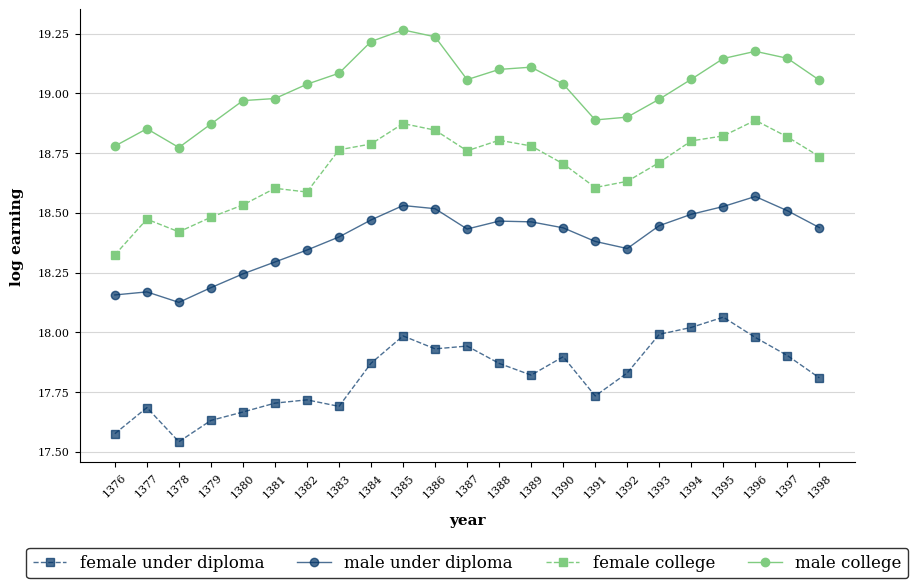

In [89]:
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(1,1,1)

for educ in [0, 1]:
    
#     for index,gender in enumerate(['female', 'male']):
#         ax1.scatter('year','LogEquivalentIncome',
#                  data=incomeYearGenderEduc[(incomeYearGenderEduc.gender== genderCode[gender])
#                                            &(incomeYearGenderEduc.educated== educ)
#                                            &(incomeYearGenderEduc.year>=84)],
#                  label=f'',
#                  color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1) ,
#                  marker=marker[index], linewidth=1 )
    
    for index,gender in enumerate(['female', 'male']):
        ax1.plot('year','LogEquivalentIncomeTest',
                 f'{"--" if gender=="female" else ""}' ,
                 data=incomeYearGenderEduc[(incomeYearGenderEduc.gender== genderCode[gender])
                                           &(incomeYearGenderEduc.educated== educ)],
                 label=f'{gender} {"college" if educ==1 else "under diploma"}',
                 color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1) ,
                 marker=marker[index], linewidth=1 )

# ax1.vlines(x=83, ymin=7, ymax=8.2, linewidth=0.7 , linestyles='dashed', alpha=0.5)
    
ax1.set_xlabel('year', fontsize=11, fontweight='bold',labelpad=10)
ax1.set_ylabel('log earning', fontsize=11, fontweight= 'bold',labelpad=10)
ax1.set_title('')
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation=45)
# ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y',alpha=0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
              , bbox_to_anchor=(0.5, -0.17),ncol=4,handlelength=2)
plt.show()
# figure.savefig('./output/')

## By cohort

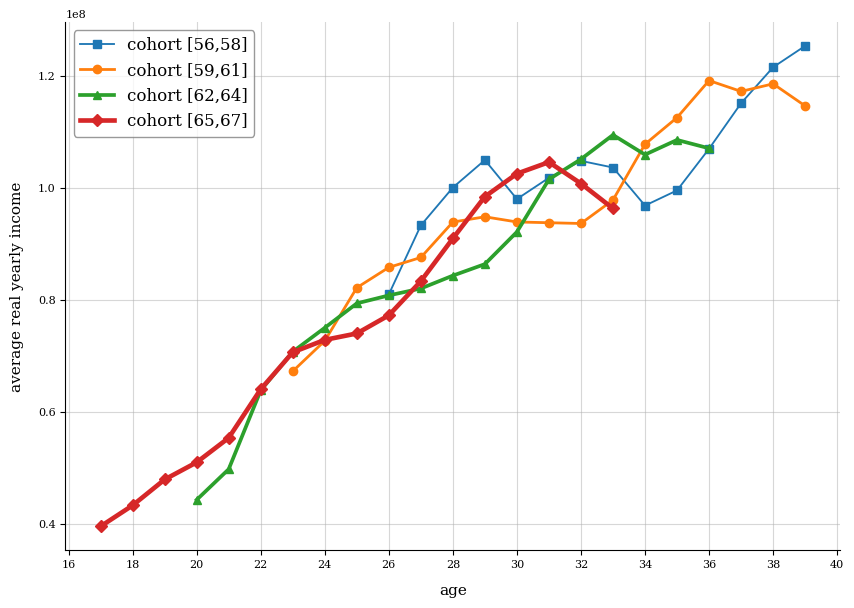

In [90]:
data['cohort5']= pd.cut(x=data['birth_y'],bins=np.arange(55,70,3),
                       labels=[f'[{year+1},{year+3}]' for year in np.arange(55,67,3)])

incomeCohort=data.groupby(["cohort5","gender","age"]).agg({
    "equivalentIncome":"mean","realIncome":"mean"
    }).reset_index()

# incomeCohort.loc[(incomeCohort.equivalentIncome.notna())]

fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(1,1,1)

for index,cohort in enumerate(incomeCohort.cohort5.unique()):
    ax1.plot("age","equivalentIncome",
        data= incomeCohort.loc[(incomeCohort.cohort5==cohort)
                               &(incomeCohort.gender==1)
                               &(incomeCohort.age<40),:],
        marker=marker[index],
        label=f"cohort {cohort}",
        linewidth=(index+2)/1.5)
    

# ax1.set_title(f'{stat} rate of {gender}, by cohorts')
ax1.set_xlabel('age',fontsize=11,labelpad=10,fontweight='regular')
ax1.set_xticks(np.arange(16,41,2))
ax1.set_ylabel(f'average real yearly income',fontsize=11,labelpad=10,fontweight='regular')

ax1.grid(axis='both',alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':12})
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
    

plt.show()

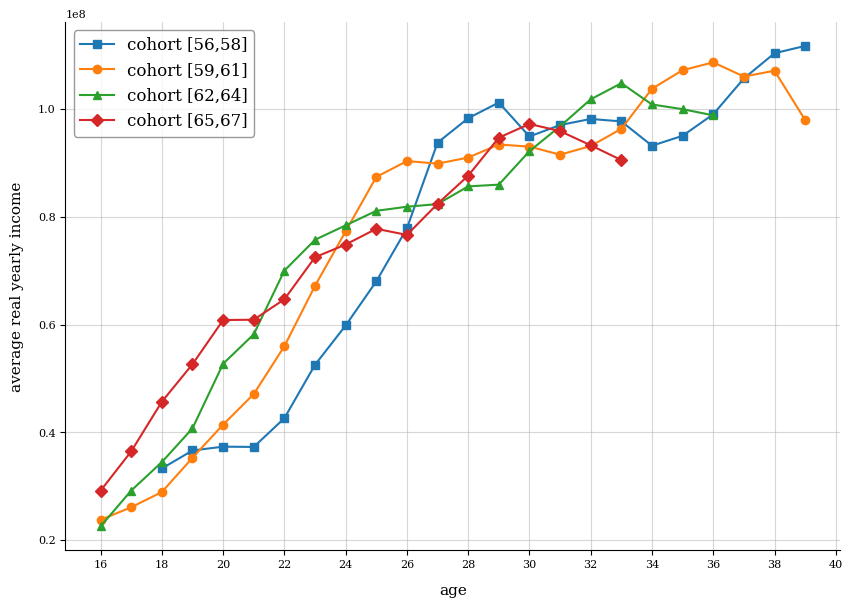

In [91]:
data['cohort5']= pd.cut(x=data['birth_y'],bins=np.arange(55,70,3),
                       labels=[f'[{year+1},{year+3}]' for year in np.arange(55,67,3)])

incomeCohort=data.groupby(["cohort5","gender","age","collar"]).agg({
    "equivalentIncome":"mean","realIncome":"mean"
    }).reset_index()

# incomeCohort.loc[(incomeCohort.equivalentIncome.notna())]

fig=plt.figure(figsize=(10,7))
ax1=fig.add_subplot(1,1,1)

for index,cohort in enumerate(incomeCohort.cohort5.unique()):
    ax1.plot("age","realIncome",
        data= incomeCohort.loc[(incomeCohort.cohort5==cohort)
                               &(incomeCohort.gender==1)
                               &(incomeCohort.collar==1)
#                                &(incomeCohort.educated==0)
                               &(incomeCohort.age<40),:],
        marker=marker[index],
        label=f"cohort {cohort}",
#         linewidth=(index+2)/1.5,
            )
    

# ax1.set_title(f'{stat} rate of {gender}, by cohorts')
ax1.set_xlabel('age',fontsize=11,labelpad=10,fontweight='regular')
ax1.set_xticks(np.arange(16,41,2))
ax1.set_ylabel(f'average real yearly income',fontsize=11,labelpad=10,fontweight='regular')

ax1.grid(axis='both',alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':12})
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
    

plt.show()

## calculating error of estimating working hours of people

*new in version 7*

<br>


In [ ]:
# wageCount=data[(data.year>=84)
#                ].groupby(by=['birth_y','gender','year','educated','collar']).agg({
#     'equivalentIncome': 'count'}).reset_index()
# wageCount["tedad"]=wageCount.equivalentIncome
# wageCount.drop(columns=["equivalentIncome"],inplace=True)

In [ ]:
# wageCount.loc[(wageCount.tedad>=15),:]

In [ ]:
# wageMoment=data[(data.year>=84)
#                ].groupby(by=['birth_y','gender','year','educated','collar']).agg({
#     'equivalentIncome': wm,'equivalentIncomeTest': wm}).reset_index()


# wageMoment = pd.merge(wageMoment,wageCount,
#                       on=['birth_y','gender','year','educated','collar']
#                      ,how="left")
# wageMoment= wageMoment.loc[(wageMoment.tedad>15),:]

# wageMomet=wageMoment.loc[(wageMoment.equivalentIncome>0)
#                          &(wageMoment.equivalentIncome>0),:]
# wageMoment.dropna(inplace=True)

# wageMoment['LogEquivalentIncome']=np.log(wageMoment.equivalentIncome)

# ## test new idea
# wageMoment['LogEquivalentIncomeTest']=np.log(wageMoment.equivalentIncomeTest)

In [ ]:
# wageMoment

In [ ]:
# wageMoment=wageMoment[(wageMoment.equivalentIncome.notna())
#                      &(wageMoment.equivalentIncome!=0)
#                      &(wageMoment.gender==1)
#                      &(wageMoment.birth_y.isin([62,63,64]))]
# wageMoment['age']= wageMoment.year - wageMoment.birth_y
# wageMoment.reset_index(drop=True,inplace=True)

In [ ]:
# total = len(wageMoment)
# for error in np.arange(0.05,0.5,0.05):
#     percent=len(wageMoment.loc[
#        (abs((wageMoment.equivalentIncome- wageMoment.equivalentIncomeTest)/wageMoment.equivalentIncome))<error])/total*100
#     error= error*100
#     print("%.1f" %percent, f'percent of moment have error lower than' ,"%.0f" %error ,'percent')

<br>

But it is more important that this approach can measure wage gap of different groups of peoplse well:


In [ ]:
# error=np.zeros((10000,2))
# for i in np.arange(0,10000):
#     a=np.random.randint(0,len(wageMoment))
#     b=np.random.randint(0,len(wageMoment))
#     error[i,0] = (wageMoment.loc[a,'equivalentIncome']- wageMoment.loc[b ,'equivalentIncome'])/wageMoment.loc[a,'equivalentIncome']
#     error[i,1] = (wageMoment.loc[a,'equivalentIncomeTest']- wageMoment.loc[b ,'equivalentIncomeTest'])/wageMoment.loc[a,'equivalentIncomeTest']

# error = pd.DataFrame(error,columns=['dif','difTest'])
# error['error']= (error.dif - error.difTest)/error.dif
    

In [ ]:
# total = len(error)
# for i in np.arange(0.05,0.5,0.05):
#     percent=len(error.loc[abs(error.error)<i])/total*100
#     i= i*100
#     print("%.1f" %percent, f'percent of moment have error lower than' ,"%.0f" %i ,'percent')

<br>

# Earning of individuals (both wage and non wage incomes)


<br>

In [ ]:
# filepath should be set to where all raw data are stored
filepath='E:/This_Term/Thesis other things/Data/HIES data/data'
os.chdir(filepath)

# data=pd.DataFrame([])
income=pd.DataFrame([])

for year in np.arange(76,99):
    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'+
                      'DBQ= '+ filepath +'\Outfile-'+ str(year)+'.mdb')
    for area in ['U', 'R']:

        ## reading income object from data for each year ##
        
        if year<=83:
            query='select * from ' + area + str(year) + 'P4S1'
        else:
            query='select * from ' + area + str(year) + 'P4S01'

        dfIncome = pd.read_sql(query, conn)
        
        if year<=83:
            colnames=dfIncome.filter(regex=re.compile("add|col01|col03|col13|col04", re.IGNORECASE)).columns
            dfIncome=dfIncome[colnames]
            dfIncome.columns=['household', 'person','occupation','job', 'income1']
            dfIncome['day']= np.nan
            dfIncome['hour']= np.nan
        else:
            colnames=dfIncome.filter(regex=re.compile("add|col01|col03|col15|col06|col07|col04", re.IGNORECASE)).columns
            dfIncome=dfIncome[colnames]
            dfIncome.columns=['household', 'person', 'occupation','job','hour','day' ,'income1']
        
        dfIncome=dfIncome.apply(pd.to_numeric, errors='coerce')
        dfIncome=dfIncome.astype({'occupation':'float16', 'income1':'float64'})
                
        
        dfIncome['year']=year
        if area=='U':
            dfIncome['RU']= 1
        else:
            dfIncome['RU']= 0
        income = pd.concat([income, dfIncome])
                
        
        ## reading income object from data for each year ##

        if year<=83:
            query='select * from ' + area + str(year) + 'P4S2'
        else:
            query='select * from ' + area + str(year) + 'P4S02'

        dfIncome2 = pd.read_sql(query, conn)
        
        if year<=83:
            colnames=dfIncome2.filter(regex=re.compile("add|col01|col03|col13|col04", re.IGNORECASE)).columns
            dfIncome2=dfIncome2[colnames]
            dfIncome2.columns=['household', 'person','occupation','job', 'income2']
            dfIncome2['day']= 5
            dfIncome2['hour']= 8
        else:
            colnames=dfIncome2.filter(regex=re.compile("add|col01|col03|col15|col06|col07|col04", re.IGNORECASE)).columns
            dfIncome2=dfIncome2[colnames]
            dfIncome2.columns=['household', 'person', 'occupation','job','hour','day' ,'income2']
        
        dfIncome2=dfIncome2.apply(pd.to_numeric, errors='coerce')
        dfIncome2=dfIncome2.astype({'occupation':'float16', 'income2':'float64'})        
        
        
        
        dfIncome2['year']=year
        if area=='U':
            dfIncome2['RU']= 1
        else:
            dfIncome2['RU']= 0
        income = pd.concat([income, dfIncome2])
        
        
del dfIncome, dfIncome2


In [ ]:
# income 

In [ ]:
income= pd.merge(income, 
                 data[['household','person','year','RU','gender',
                       'birth_y','age','educated','weight','marital']],
                 on=['household','person','year','RU'], 
                 how='left')

income=income.astype({'person':'category','job':'float16','day':'float16', 'hour':'float16',
              'RU':'category'})

income.info(memory_usage='deep')

In [ ]:
## define new varibles ##

# collar is occupation type of emplyed individual
income.loc[(income.occupation<5000)
         &(income.occupation>=1000)&
         (income.year>77) , 'collar']= 0 # white-collar 
income.loc[(income.occupation>=5000)&(income.year>77), 'collar']= 1 #blue collar
income.loc[(income.occupation<1000)&(income.year>77),'collar']= 2 # military

income.loc[(income.occupation<500)
         &(income.occupation>=100)&
         (income.year<=77) , 'collar']= 0 # white-collar 
income.loc[(income.occupation>=500)&(income.year<=77), 'collar']= 1 #blue collar
income.loc[(income.occupation<100)&(income.year<=77),'collar']= 2 # military
income['collar']= income.collar.astype('category')

income['income']= income[['income1','income2']].sum(axis=1)

income= pd.merge(income, cpi, on=['year'], how='left')

income['realIncome']= income.income/ income.cpi * 100 

income.loc[(income.realIncome<=0), 'realIncome'] = np.nan
# income['LogIncome'] = np.log(income.realIncome)

income['totalHour']= income.day * income.hour
income.loc[(income.totalHour==0), 'totalHour']= np.nan
income.loc[(income.year<=83)&(income.gender==0)&(income.totalHour.notna()), 'totalHour']= np.nan#38.5
income.loc[(income.year<=83)&(income.gender==1)&(income.totalHour.notna()), 'totalHour']= np.nan#50


income['equivalentIncome'] = income.realIncome #*40/income.totalHour
# income['LogEquivalentIncome'] = np.log(income.equivalentIncome)

In [ ]:
income;

<br>

## By year and gender

**average log earning by gedner**

<br>

In [ ]:
# incomeYearGender=income.groupby(by=['gender','year']).agg({
#     'LogIncome': wmincome,'LogEquivalentIncome':wmincome}).reset_index()

# incomeYearGenderRU=income.groupby(by=['gender','year','RU']).agg({
#     'LogIncome': wmincome,'LogEquivalentIncome':wmincome}).reset_index()

incomeYearGender=income.groupby(by=['gender','year']).agg({
    'equivalentIncome': wmincome,'realIncome': wmincome,'totalHour':wmincome}).reset_index()
incomeYearGender['LogEquivalentIncome']=np.log(incomeYearGender.equivalentIncome)

## test new idea
# incomeYearGender['equivalentIncomeTest']=incomeYearGender.realIncome* 40/ \
#     incomeYearGender.totalHour
# incomeYearGender['LogEquivalentIncomeTest']=np.log(incomeYearGender.equivalentIncomeTest)

######################
# incomeYearGenderRU=income.groupby(by=['gender','year','RU']).agg({
#     'equivalentIncome': wmincome,'realIncome': wmincome,'totalHour':wmincome}).reset_index()
# incomeYearGenderRU['LogEquivalentIncome']=np.log(incomeYearGenderRU.equivalentIncome)

# ## test new idea
# incomeYearGenderRU['equivalentIncomeTest']=incomeYearGenderRU.realIncome* 40/ \
#     incomeYearGenderRU.totalHour
# incomeYearGenderRU['LogEquivalentIncomeTest']=np.log(incomeYearGenderRU.equivalentIncomeTest)

*graph:* **log earning of men and women, both actual and equivalent one**

In [ ]:
earning = "LogEquivalentIncome"
# for earning in ["LogEquivalentIncome","LogEquivalentIncomeTest"]:
fig=plt.figure(figsize=(10,6))

ax1=fig.add_subplot(1,1,1)
#     for index,gender in enumerate(['male','female']):
#         ax1.scatter('year', earning,
#                 data=incomeYearGender[(incomeYearGender.gender== genderCode[gender])
#                                       &(incomeYearGender.year>=84)],
#                 label=f'{gender} actual earning',
#                 color=(0,0.2,0.4,0.7) if gender=='male' else (0.5,0.8,0.5,1) ,
#                 marker=marker[index], linewidth=1 )

for index,gender in enumerate(['male','female']):
    ax1.plot('year', earning,
            data=incomeYearGender[(incomeYearGender.gender== genderCode[gender])],
            label=f'{gender}',
            color=(0,0.2,0.4,0.7) if gender=='male' else (0.5,0.8,0.5,1) ,
            marker=marker[index+2], linewidth=1 )



ax1.set_title(f'{earning} of men and women from 76-97', fontsize=14)
ax1.set_xlabel('Year', fontsize=11.5, fontweight= 'bold',labelpad=10)
ax1.set_ylabel('log earning', fontsize=11.5, fontweight= 'bold',labelpad=10)
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
# ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y', alpha=0.5)
ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()
# figure.savefig('./output/')

<br>

## By year, gender, occupation

<br>

In [ ]:
# incomeYearGenderCollar=income.groupby(by=['gender','collar','year']).agg({
#     'LogIncome': wmincome,'LogEquivalentIncome':wmincome}).reset_index()

# incomeYearGenderCollarRU=income.groupby(by=['gender','collar','year','RU']).agg({
#     'LogIncome': wmincome,'LogEquivalentIncome':wmincome}).reset_index()

######################
incomeYearGenderCollar=income.groupby(by=['gender','year','collar']).agg({
    'equivalentIncome': wmincome,'realIncome': wmincome,'totalHour':wmincome}).reset_index()
incomeYearGenderCollar['LogEquivalentIncome']=np.log(incomeYearGenderCollar.equivalentIncome)

## test new idea
# incomeYearGenderCollar['equivalentIncomeTest']=incomeYearGenderCollar.realIncome* 40/ \
#     incomeYearGenderCollar.totalHour
# incomeYearGenderCollar['LogEquivalentIncomeTest']=np.log(incomeYearGenderCollar.equivalentIncomeTest)

######################
# incomeYearGenderCollarRU=income.groupby(by=['gender','year','collar','RU']).agg({
#     'equivalentIncome': wmincome,'realIncome': wmincome,'totalHour':wmincome}).reset_index()
# incomeYearGenderCollarRU['LogEquivalentIncome']=np.log(incomeYearGenderCollarRU.equivalentIncome)

# ## test new idea
# incomeYearGenderCollarRU['equivalentIncomeTest']=incomeYearGenderCollarRU.realIncome* 40/ \
#     incomeYearGenderCollarRU.totalHour
# incomeYearGenderCollarRU['LogEquivalentIncomeTest']=np.log(
#     incomeYearGenderCollarRU.equivalentIncomeTest)

*graph:* **log equivalent earning by gender and occupation** 

In [ ]:
fig=plt.figure(figsize=(10,6))

ax1=fig.add_subplot(1,1,1)

for index,collar in enumerate(['blue','white']):
#     for gender in ['male','female']:   
#         ax1.scatter('year','LogEquivalentIncome',
#                 data=incomeYearGenderCollar[(incomeYearGenderCollar.gender== genderCode[gender])
#                                            &(incomeYearGenderCollar.collar== collarCode[collar])],
#                 color=(0,0.2,0.4,0.7) if collar=='blue' else (0.5,0.8,0.5,1) ,
#                 marker=marker[index+2], linewidth=1,
#                 label=f'')

      
    for gender in ['male','female']:   
        ax1.plot('year','LogEquivalentIncome',f'{"--" if gender=="female" else ""}' ,
                data=incomeYearGenderCollar[(incomeYearGenderCollar.gender== genderCode[gender])
                                           &(incomeYearGenderCollar.collar== collarCode[collar])],
                label=f'{gender} {collar}',
                color=(0,0.2,0.4,0.7) if collar=='blue' else (0.5,0.8,0.5,1) ,
                marker=marker[index], linewidth=1 )

        
# ax1.vlines(x=83, ymin=7, ymax=8.2, linewidth=0.7 , linestyles='dashed', alpha=0.5)
    
ax1.set_xlabel('Year', fontsize=11, fontweight='bold',labelpad=10)
ax1.set_ylabel('Log Earning', fontsize=11, fontweight= 'bold',labelpad=10)
ax1.set_title('')
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xlim(75,99)
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation= 45)
# ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y', alpha=0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
              , bbox_to_anchor=(0.5, -0.17),ncol=4,handlelength=2)
# ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
plt.show()
# figure.savefig('./output/')

<br>

## By year, gender, education

<br>

In [ ]:
# incomeYearGenderEduc=income.groupby(by=['gender','educated','year']).agg({
#     'LogIncome': wmincome,'LogEquivalentIncome':wmincome}).reset_index()
# incomeYearGenderEducRU=income.groupby(by=['gender','educated','year','RU']).agg({
#     'LogIncome': wmincome,'LogEquivalentIncome':wmincome}).reset_index()
######################
incomeYearGenderEduc=income.groupby(by=['gender','year','educated']).agg({
    'equivalentIncome': wmincome,'realIncome': wmincome,'totalHour':wmincome}).reset_index()
incomeYearGenderEduc['LogEquivalentIncome']=np.log(incomeYearGenderEduc.equivalentIncome)

## test new idea
# incomeYearGenderEduc['equivalentIncomeTest']=incomeYearGenderEduc.realIncome* 40/ \
#     incomeYearGenderEduc.totalHour
# incomeYearGenderEduc['LogEquivalentIncomeTest']=np.log(incomeYearGenderEduc.equivalentIncomeTest)

# ######################
# incomeYearGenderEducRU=income.groupby(by=['gender','year','educated','RU']).agg({
#     'equivalentIncome': wmincome,'realIncome': wmincome,'totalHour':wmincome}).reset_index()
# incomeYearGenderEducRU['LogEquivalentIncome']=np.log(incomeYearGenderEducRU.equivalentIncome)

# ## test new idea
# incomeYearGenderEducRU['equivalentIncomeTest']=incomeYearGenderEducRU.realIncome* 40/ \
#     incomeYearGenderEducRU.totalHour
# incomeYearGenderEducRU['LogEquivalentIncomeTest']=np.log(
#     incomeYearGenderEducRU.equivalentIncomeTest)

*graph:* **log equivalent earning by gender and education** 

In [ ]:
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(1,1,1)

for educ in [0, 1]:
    
#     for index,gender in enumerate(['female', 'male']):
#         ax1.scatter('year','LogEquivalentIncome',
#                  data=incomeYearGenderEduc[(incomeYearGenderEduc.gender== genderCode[gender])
#                                            &(incomeYearGenderEduc.educated== educ)
#                                            &(incomeYearGenderEduc.year>=84)],
#                  label=f'',
#                  color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1) ,
#                  marker=marker[index], linewidth=1 )
    
    for index,gender in enumerate(['female', 'male']):
        ax1.plot('year','LogEquivalentIncome',
                 f'{"--" if gender=="female" else ""}' ,
                 data=incomeYearGenderEduc[(incomeYearGenderEduc.gender== genderCode[gender])
                                           &(incomeYearGenderEduc.educated== educ)],
                 label=f'{gender} {"college" if educ==1 else "under diploma"}',
                 color=(0,0.2,0.4,0.7) if educ==0 else (0.5,0.8,0.5,1) ,
                 marker=marker[index], linewidth=1 )

# ax1.vlines(x=83, ymin=7, ymax=8.2, linewidth=0.7 , linestyles='dashed', alpha=0.5)
    
ax1.set_xlabel('year', fontsize=11, fontweight='bold',labelpad=10)
ax1.set_ylabel('log earning', fontsize=11, fontweight= 'bold',labelpad=10)
ax1.set_title('')
ax1.set_xticks(np.arange(76,99,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1399,1)],rotation=45)
# ax1.set_yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y',alpha=0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
              , bbox_to_anchor=(0.5, -0.17),ncol=4,handlelength=2)
plt.show()
# figure.savefig('./output/')

<br>

## Estimating working hours of people:

<br>

we need to find a way to calculate the wage of individual at years **before 1384**, since in the survey they didn'nt asked for it.

<br>

In [ ]:
# data=data.astype({'marital':'float16'})

In [ ]:
# import statsmodels.api as sm # import statsmodels 

# X = data[['gender','RU','collar','age','income1','marital']] ## X usually means our input variables (or independent variables)
# y = data['totalHour'] ## Y usually means our output/dependent variable
# X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# # Note the difference in argument order
# model = sm.OLS(y, X,missing='drop').fit() ## sm.OLS(output, input)
# # predictions = model.predict(X)

# # Print out the statistics
# print(model.summary())

# Moment Conditions

## each choice distribution conditions:

In [63]:
cohort = [60,61,62,63,64,65]
cohort = np.arange(50,70)
# cohort = [66,67,68,69,70,71]

sample = data.loc[
           (data.birth_y.isin(cohort))
          &(data.gender==1), :]

In [64]:

choiceMoment=sample.groupby(by=(["age"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()

choiceMoment["home"] = choiceMoment.home+choiceMoment.unemployed

choiceMoment = choiceMoment.loc[:,["age","home","study","white","blue","military","choice"]]
# choiceMoment.to_csv(r"C:\Users\claudioq\Dropbox\Labor\Codes\Moments\choiceMoment.csv"
#                         ,index=False,header=False)

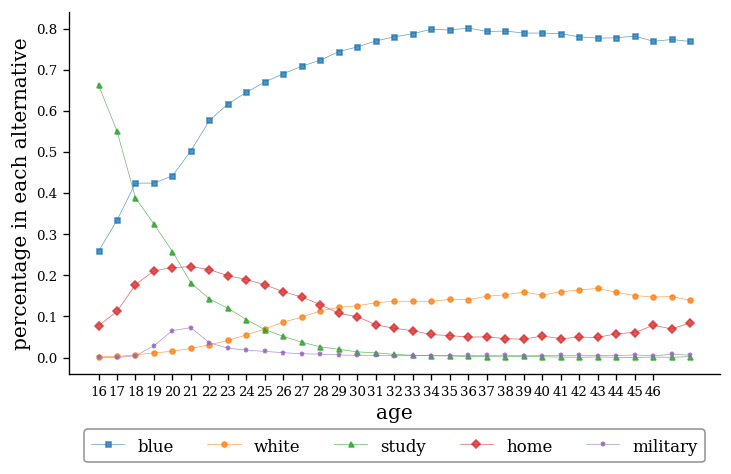

In [66]:
fSize = 12
tSize = 8

fig= plt.figure(figsize=(7,4))
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)
ax1=fig.add_subplot(1,1,1)

for index,choice in enumerate(["blue","white","study","home","military"]):
    ax1.plot("age",choice
            ,data=choiceMoment.loc[(choiceMoment.age<=80),:]
            ,marker=marker[index]
            ,label=f"{choice}"
            ,markersize=3
            ,alpha=0.75
            ,linewidth= 0.4
            )

#     ax1.set_title(f'career decision of {gender} by year', fontsize= 14)
ax1.set_xlabel('age',fontsize=fSize,labelpad=3)
ax1.set_ylabel('percentage in each alternative',fontsize=fSize,labelpad=3)
ax1.set_xticks(np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1-2))
ax1.set_xticklabels([age for age in 
                     np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1-2).astype(np.int)])
# ax1.set_ylim(-0.04 , 0.82)
# ax1.set_yticks(np.arange(0.0,0.81,0.1))
# ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)

# ax1.grid(axis='y',alpha=0.5)
lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'size':fSize-2}
              , bbox_to_anchor=(0.5, -0.13),ncol=6,handlelength=2,handleheight=1.4)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.show()

# fig.savefig(f"Results/Paper/choice share of cohort 60.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')




In [67]:
# ######################################################
# ## Farsi ##
# ######################################################

# fig= plt.figure(figsize=(11,7))
# ax1=fig.add_subplot(1,1,1)
# labelFarsi = ["مشاغل یقه-آبی",
#         "مشاغل یقه-سفید",
#         "در حال تحصیل",
#         "در خانه",
#         "سربازی"]
# for index,choice in enumerate(["blue","white","study","home","military"]):
#     ax1.plot("age",choice
#             ,data=choiceMoment.loc[(choiceMoment.age<=36),:]
#             ,marker=marker[index]
#             ,label=f"{farsi(labelFarsi[index])}"
#             ,markersize=7
#             ,alpha=0.85
#             )

# ax1.set_xlabel(farsi("سن"),fontdict={'family': 'B Yas','size': 20},labelpad=20)
# ax1.set_ylabel(farsi("مقدار نستبی از کل مردان "),fontdict={'family': 'B Yas'},
#                fontsize=20,labelpad=10,fontweight='regular')
# ax1.set_xticks(np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1-2))
# ax1.set_xticklabels([age for age in np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1-2).astype(np.int)]
#                     ,rotation=0,fontsize=10)
# # ax1.set_ylim(-0.04 , 0.82)
# # ax1.set_yticks(np.arange(0.0,0.81,0.1))
# # ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)

# ax1.grid(axis='y',alpha=0.5)
# lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'family': 'B Yas','size':16}
#               , bbox_to_anchor=(0.88, 0.74),ncol=1,handlelength=1.5,handleheight=1)
# # Hide the right and top spines
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)

# plt.show()

# # fig.savefig(f"Results/choice share of cohort 60.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [68]:
choiceMoment["home"] =choiceMoment["home"] *100
choiceMoment["study"] =choiceMoment["study"]*100
choiceMoment["white"] =choiceMoment["white"]*100
choiceMoment["blue"] = choiceMoment["blue"]*100
choiceMoment["military"] =choiceMoment["military"]*100
choiceMoment.loc[(choiceMoment.age<=36),:]

age   home  study  white   blue  military  choice
0  16.000  7.723 66.250  0.177 25.828     0.016   18643
1  17.000 11.234 55.062  0.260 33.406     0.030   19967
2  18.000 17.703 38.781  0.661 42.406     0.438   21491
3  19.000 21.109 32.469  1.114 42.438     2.887   15970
4  20.000 21.891 25.781  1.538 44.188     6.578   17683
5  21.000 22.109 18.109  2.227 50.281     7.258   19718
6  22.000 21.391 14.242  3.100 57.656     3.576   23260
7  23.000 19.906 11.984  4.152 61.656     2.289   23420
8  24.000 18.969  9.227  5.531 64.500     1.776   23534
9  25.000 17.688  6.793  6.965 67.062     1.500   24468
10 26.000 16.000  5.141  8.633 69.062     1.185   22444
11 27.000 14.711  3.732  9.820 70.875     0.917   22781
12 28.000 12.867  2.613 11.367 72.312     0.827   22008
13 29.000 10.727  2.000 12.227 74.438     0.640   18748
14 30.000  9.945  1.376 12.609 75.562     0.520   22313
15 31.000  7.973  1.167 13.328 77.000     0.527   16888
16 32.000  7.105  0.749 13.711 78.000     0.469   17486
17 33.000  6.523  0.561 13.688 78.750     0.494   14975
18 34.000  5.609  0.435 13.688 79.812     0.456   14246
19 35.000  5.348  0.382 14.148 79.625     0.487   15200
20 36.000  4.984  0.264 14.086 80.125     0.521   12484

In [69]:
choiceMoment=sample[(sample.age>=22)].groupby(by=(["age","educated"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
choiceMoment= choiceMoment[choiceMoment.choice>100]

choiceMoment2=data[(data.age<22)
          &(data.birth_y.isin(cohort))
          &(data.gender==1)].groupby(by=(["age"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
choiceMoment2= choiceMoment2[choiceMoment2.choice>100]
choiceMoment2["educated"] = -1

choiceMoment = pd.concat([choiceMoment2,choiceMoment])
del choiceMoment2

choiceMoment["home"] = choiceMoment.home+choiceMoment.unemployed



choiceMoment = choiceMoment.loc[:,["age","educated","home","study","white","blue","military"]]
# choiceMoment.to_csv(r"C:\Users\claudioq\Dropbox\Labor\Codes\Moments\choiceMoment2.csv"
#                         ,index=False,header=False)

In [70]:
choiceMoment

age  educated  home  study  white  blue  military
0  16.000    -1.000 0.077  0.663  0.002 0.258     0.000
1  17.000    -1.000 0.112  0.551  0.003 0.334     0.000
2  18.000    -1.000 0.177  0.388  0.007 0.424     0.004
3  19.000    -1.000 0.211  0.325  0.011 0.424     0.029
4  20.000    -1.000 0.219  0.258  0.015 0.442     0.066
5  21.000    -1.000 0.221  0.181  0.022 0.503     0.073
0  22.000     0.000 0.237  0.020  0.025 0.680     0.038
1  22.000     1.000 0.113  0.691  0.056 0.115     0.025
2  23.000     0.000 0.207  0.014  0.032 0.728     0.020
3  23.000     1.000 0.165  0.574  0.083 0.140     0.038
4  24.000     0.000 0.183  0.008  0.038 0.761     0.011
5  24.000     1.000 0.220  0.438  0.127 0.168     0.047
6  25.000     0.000 0.159  0.006  0.042 0.787     0.006
7  25.000     1.000 0.250  0.316  0.182 0.199     0.053
8  26.000     0.000 0.136  0.004  0.049 0.806     0.005
9  26.000     1.000 0.254  0.230  0.230 0.245     0.040
10 27.000     0.000 0.122  0.003  0.049 0.822     0.004
11 27.000     1.000 0.246  0.166  0.287 0.270     0.031
12 28.000     0.000 0.105  0.001  0.054 0.834     0.005
13 28.000     1.000 0.223  0.121  0.344 0.290     0.023
14 29.000     0.000 0.088  0.001  0.056 0.852     0.003
15 29.000     1.000 0.186  0.095  0.390 0.309     0.020
16 30.000     0.000 0.085  0.001  0.056 0.854     0.003
17 30.000     1.000 0.165  0.068  0.433 0.318     0.016
18 31.000     0.000 0.067  0.001  0.058 0.871     0.003
19 31.000     1.000 0.135  0.058  0.466 0.326     0.014
20 32.000     0.000 0.062  0.001  0.059 0.875     0.003
21 32.000     1.000 0.110  0.040  0.505 0.331     0.015
22 33.000     0.000 0.059  0.001  0.057 0.879     0.004
23 33.000     1.000 0.095  0.027  0.550 0.315     0.013
24 34.000     0.000 0.053  0.001  0.058 0.885     0.003
25 34.000     1.000 0.071  0.024  0.570 0.321     0.015
26 35.000     0.000 0.053  0.000  0.061 0.884     0.002
27 35.000     1.000 0.058  0.023  0.598 0.302     0.019
28 36.000     0.000 0.049  0.000  0.055 0.893     0.004
29 36.000     1.000 0.056  0.014  0.620 0.296     0.014
30 37.000     0.000 0.052  0.000  0.059 0.885     0.003
31 37.000     1.000 0.039  0.010  0.653 0.280     0.017
32 38.000     0.000 0.047  0.000  0.061 0.889     0.004
33 38.000     1.000 0.040  0.010  0.681 0.255     0.015
34 39.000     0.000 0.048  0.000  0.063 0.884     0.003
35 39.000     1.000 0.025  0.014  0.685 0.267     0.010
36 40.000     0.000 0.056  0.000  0.065 0.876     0.003
37 40.000     1.000 0.034  0.009  0.681 0.260     0.016
38 41.000     0.000 0.048  0.000  0.061 0.887     0.003
39 41.000     1.000 0.033  0.007  0.728 0.216     0.016
40 42.000     0.000 0.053  0.000  0.064 0.881     0.002
41 42.000     1.000 0.037  0.005  0.720 0.214     0.023
42 43.000     0.000 0.052  0.000  0.061 0.883     0.004
43 43.000     1.000 0.035  0.008  0.765 0.182     0.010
44 44.000     0.000 0.062  0.000  0.054 0.880     0.003
45 44.000     1.000 0.040  0.003  0.756 0.184     0.017
46 45.000     0.000 0.064  0.000  0.054 0.879     0.003
47 45.000     1.000 0.048  0.002  0.717 0.209     0.024
48 46.000     0.000 0.079  0.000  0.054 0.864     0.003
49 46.000     1.000 0.086  0.009  0.696 0.201     0.009
50 47.000     0.000 0.070  0.000  0.055 0.873     0.003
51 47.000     1.000 0.071  0.004  0.644 0.245     0.036
52 48.000     0.000 0.077  0.001  0.052 0.866     0.004
53 48.000     1.000 0.129  0.008  0.669 0.177     0.016

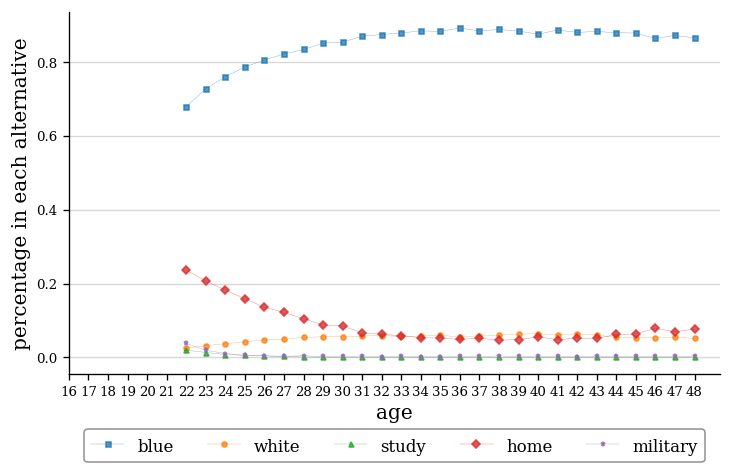

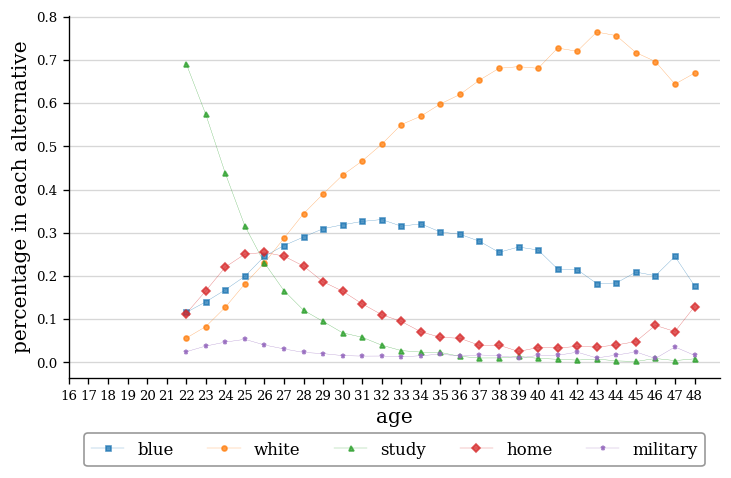

In [71]:

for educated in [0,1]:
    fig= plt.figure(figsize=(7,4))
    plt.rc('font', family='serif')
    plt.rc('xtick',labelsize=tSize)
    plt.rc('ytick',labelsize=tSize)
    ax1=fig.add_subplot(1,1,1)

    for index,choice in enumerate(["blue","white","study","home","military"]):
        ax1.plot("age",choice
                ,data=choiceMoment.loc[(choiceMoment.educated==educated),:]
                ,marker=marker[index]
                ,label=f"{choice}"
                ,markersize=3
                ,alpha=0.75
                ,linewidth= 0.2
                )

#     ax1.set_title(f'career decision of {gender} by year', fontsize= 14)
    ax1.set_xlabel('age',fontsize=fSize,labelpad=3,fontweight='regular')
    ax1.set_ylabel('percentage in each alternative',fontsize=fSize,labelpad=3,fontweight='regular')
    ax1.set_xticks(np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1))
    ax1.set_xticklabels([age for age in 
                         np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1).astype(np.int)])
    # ax1.set_ylim(-0.04 , 0.82)
    # ax1.set_yticks(np.arange(0.0,0.81,0.1))
    # ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)

    ax1.grid(axis='y',alpha=0.5)
    lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'size':fSize-2}
                  , bbox_to_anchor=(0.5, -0.13),ncol=6,handlelength=2,handleheight=1.4)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    plt.show()

    # fig.savefig(f"choice share of cohort 60.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


## wage moment conditions

In [72]:
# wm is weighted mean function required for grouping when data have missingv value
# since python don't have average function like R, we create this function

import math
def wmDev(x):
    x = x.sort_values()
    x = x[2:-2]
    variance = x.var()
    return (math.sqrt(variance))

def wm(x):
    x = x.sort_values()
    x = x[2:-2]
    mean = x.mean()
    return mean
    

### wageMomnet1: by collar

In [73]:
wageSize=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
         ,:].groupby(by=['age','educated','collar']).agg({
        'realIncome': "count", 'equivalentIncome': "count"}).reset_index() 
wageSize.rename(columns={"equivalentIncome":"tedad"},inplace=True)

wageMoment=data[(data.collar!=2)
                &(data.equivalentIncome.notna())
        &(data.age<=65)
        &(data.birth_y.isin(cohort))
        &(data.gender==1)].groupby(by=['age','collar']).agg({
        'equivalentIncome':wm}).reset_index() 

wageMoment = pd.merge(wageMoment,wageSize,on=["age","collar"],how="left")
del wageSize

wageMoment = wageMoment.loc[(wageMoment.tedad>80),:]
wageMoment['income']= wageMoment.equivalentIncome#* 40 / wageMoment.totalHour['<lambda>']

wageMoment = wageMoment.loc[:,["age","collar","income"]]

wageDev=data[(data.collar!=2)
             &(data.equivalentIncome.notna())
        &(data.age<=65)
        &(data.birth_y.isin(cohort))
        &(data.gender==1)].groupby(by=['age','educated','collar']).agg({
         "equivalentIncome":wmDev}).reset_index() 
# wageDev["equivalentIncome"] = np.sqrt(wageDev.equivalentIncome)
wageDev.rename(columns={"equivalentIncome":"deviation"},inplace=True)

# wageMoment = pd.merge(wageMoment, wageDev,on=["age","educated","collar"],how="left")


# wageMoment.to_csv(r"C:\Users\claudioq\Dropbox\Labor\Codes\Moments\wageMoment.csv",
#                   index=False,header=False)
wageMoment

age collar        income
2   16.000  1.000  36353956.000
8   17.000  1.000  40949820.000
14  18.000  1.000  46598016.000
20  19.000  1.000  52178424.000
26  20.000  1.000  57834708.000
..     ...    ...           ...
181 46.000  0.000 243725344.000
182 46.000  1.000 100863384.000
187 47.000  0.000 231150096.000
188 47.000  1.000  95725800.000
194 48.000  1.000  90587192.000

[105 rows x 3 columns]

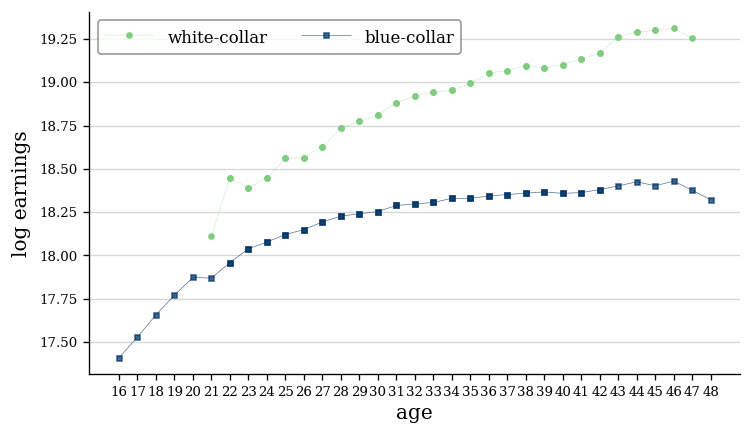

In [75]:
wageMoment["logIncome"]= np.log(wageMoment.income)
label={0:"white-collar",1:"blue-collar",2:"conscription"}
labelEduc={1:"educated",0:"not educated"}

fig= plt.figure(figsize=(7,4))
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)
ax1=fig.add_subplot(1,1,1)


ax1.plot("age","logIncome"
        ,dashes=[5, 2] 
        ,data=wageMoment.loc[(wageMoment.collar==0)
                             ,:]
        ,marker=marker[1]
        ,label=f"white-collar"
        ,markersize=3
        ,color= (0.5,0.8,0.5,1)
        ,linewidth= 0.2
        )

line1=ax1.plot("age","logIncome"
        ,dashes=[1,0]
        ,data=wageMoment.loc[(wageMoment.collar==1)
                             ,:]
        ,marker=marker[0]
        ,label=f"blue-collar"
        ,markersize=3
        ,color=(0,0.2,0.4,0.7)
        ,linewidth= 0.4
        )


ax1.set_xlabel('age',fontsize=fSize,labelpad=3,fontweight='regular')
ax1.set_ylabel('log earnings',fontsize=fSize,labelpad=5,fontweight='regular')
ax1.set_xticks(np.arange(wageMoment.age.min(),wageMoment.age.max()+1))
ax1.set_xticklabels([age for age in 
                     np.arange(wageMoment.age.min(),wageMoment.age.max()+1).astype(np.int)])
# ax1.set_ylim(16.85 , 19.6)
# ax1.set_yticks(np.arange(17,19.6,0.5))
# ax1.set_yticklabels(np.arange(17,19.6,0.5) , fontsize=12)

ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-2},ncol=2,handlelength=3,handleheight=1.5)
# lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
#               , bbox_to_anchor=(0.5, -0.12),ncol=6,handlelength=2)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()
# fig.savefig(f"income cohort 60.pdf", bbox_inches='tight')


### wageMoment2: by collar and educated 

In [76]:
wageSize=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
        ,:].groupby(by=['age','educated','collar']).agg({
        'realIncome': "count", 'equivalentIncome': "count"}).reset_index() 
wageSize.rename(columns={"equivalentIncome":"tedad"},inplace=True)

wageMoment=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
        ,:].groupby(by=['age','educated','collar']).agg({
        'equivalentIncome':wm}).reset_index() 

wageMoment = pd.merge(wageMoment,wageSize,on=["age","educated","collar"],how="left")
del wageSize

wageMoment = wageMoment.loc[(wageMoment.tedad>80),:]
wageMoment['income']= wageMoment.equivalentIncome#* 40 / wageMoment.totalHour['<lambda>']

wageMoment = wageMoment.loc[:,["age","educated","collar","income"]]

wageDev=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
              &(sample.age<65)
        ,:].groupby(by=['age','educated','collar']).agg({
         "equivalentIncome":wmDev}).reset_index() 
# wageDev["equivalentIncome"] = np.sqrt(wageDev.equivalentIncome)
wageDev.rename(columns={"equivalentIncome":"deviation"},inplace=True)

wageMoment = pd.merge(wageMoment, wageDev,on=["age","educated","collar"],how="left")


# wageMoment.to_csv(r"C:\Users\claudioq\Dropbox\Labor\Codes\Moments\wageMoment2.csv",
#                   index=False,header=False)
wageMoment

age  educated collar        income     deviation
0   16.000     0.000  1.000  36353956.000  27592540.000
1   17.000     0.000  1.000  40945152.000  29427974.000
2   18.000     0.000  1.000  46692956.000  31552082.000
3   19.000     0.000  1.000  52184948.000  34016068.000
4   20.000     0.000  1.000  57880056.000  36208404.000
..     ...       ...    ...           ...           ...
100 46.000     0.000  1.000  98353888.000  49645624.000
101 46.000     1.000  0.000 271424992.000 111892056.000
102 47.000     0.000  1.000  90814376.000  46610244.000
103 47.000     1.000  0.000 257941104.000 108968272.000
104 48.000     0.000  1.000  87825456.000  41104344.000

[105 rows x 5 columns]

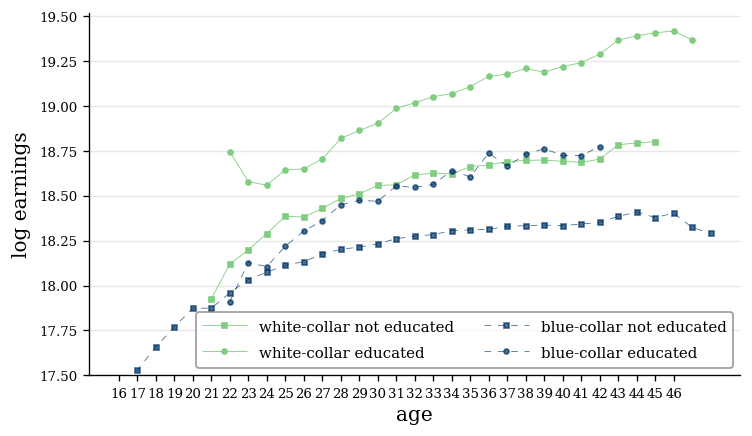

In [78]:
#####################################################
# English ##
#####################################################

wageMoment["logIncome"]= np.log(wageMoment.income)
label={0:"white-collar",1:"blue-collar",2:"conscription"}
labelEduc={1:"educated",0:"not educated"}

fSize = 12
tSize = 8

fig= plt.figure(figsize=(7,4))
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)
ax1=fig.add_subplot(1,1,1)

for educated in [0,1]:
    ax1.plot("age","logIncome"
            ,dashes=[8, 0] #if educated ==1 else [1,0]
            ,data=wageMoment.loc[(wageMoment.collar==0)
                                 &(wageMoment.educated==educated)
                                 &(wageMoment.age<=63),:]
            ,marker=marker[educated]
            ,label=f"white-collar {labelEduc[educated]}"
            ,markersize=3
            ,color= (0.5,0.8,0.5,1)
            ,linewidth= 0.5
            )
for educated in [0,1]:
    line1=ax1.plot("age","logIncome"
            ,dashes=[8, 8] #if educated ==0 else [1,0]
            ,data=wageMoment.loc[(wageMoment.collar==1)
                                 &(wageMoment.educated==educated)
                                 &(wageMoment.age<=63),:]
            ,marker=marker[educated]
            ,label=f"blue-collar {labelEduc[educated]}"
            ,markersize=3
            ,color=(0,0.2,0.4,0.7)
            ,linewidth= 0.5
            )

ax1.set_xlabel('age',         fontsize=fSize,labelpad=3)
ax1.set_ylabel('log earnings',fontsize=fSize,labelpad=5)
ax1.set_xticks(np.arange(wageMoment.age.min(),wageMoment.age.max()+1-2))
ax1.set_xticklabels([age for age in 
                     np.arange(wageMoment.age.min(),wageMoment.age.max()+1-2).astype(np.int)])

ax1.grid(axis='y',alpha=0.3)
ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-3},ncol=2,handlelength=3,handleheight=1.5)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(bottom=17.5)
plt.show()
# fig.savefig(f"Results/Paper/income cohort 60.pdf", bbox_inches='tight')

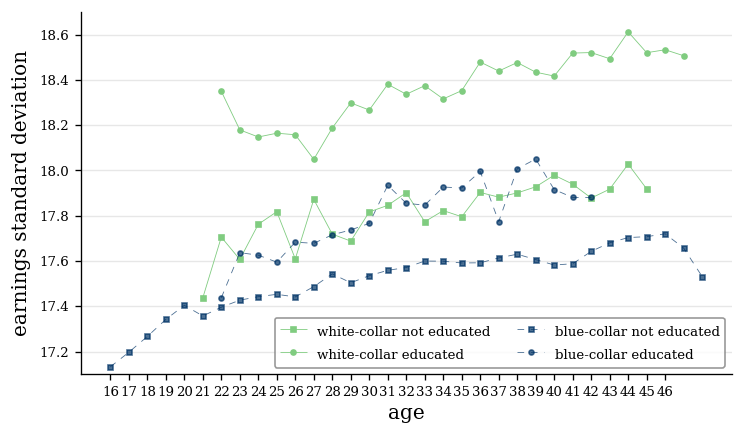

In [80]:
## English ##
#####################################################
wageMoment["logDev"]= np.log(wageMoment.deviation)
label={0:"white-collar",1:"blue-collar",2:"conscription"}
labelEduc={1:"educated",0:"not educated"}

fig= plt.figure(figsize=(7,4))
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)
ax1=fig.add_subplot(1,1,1)

for educated in [0,1]:
    ax1.plot("age","logDev"
            ,dashes=[8, 0] #if educated ==1 else [1,0]
            ,data=wageMoment.loc[(wageMoment.collar==0)
                                 &(wageMoment.educated==educated)
                                 &(wageMoment.age<=63),:]
            ,marker=marker[educated]
            ,label=f"white-collar {labelEduc[educated]}"
            ,markersize=3
            ,color= (0.5,0.8,0.5,1)
            ,linewidth= 0.5
            )
for educated in [0,1]:
    line1=ax1.plot("age","logDev"
            ,dashes=[8, 8] #if educated ==0 else [1,0]
            ,data=wageMoment.loc[(wageMoment.collar==1)
                                 &(wageMoment.educated==educated)
                                 &(wageMoment.age<=63),:]
            ,marker=marker[educated]
            ,label=f"blue-collar {labelEduc[educated]}"
            ,markersize=3
            ,color=(0,0.2,0.4,0.7)
            ,linewidth= 0.5
                  )

ax1.set_xlabel('age',                        fontsize=fSize,labelpad=3)
ax1.set_ylabel('earnings standard deviation',fontsize=fSize,labelpad=5)
ax1.set_xticks(np.arange(wageMoment.age.min(),wageMoment.age.max()+1-2))
ax1.set_xticklabels([age for age in 
                     np.arange(wageMoment.age.min(),wageMoment.age.max()+1-2).astype(np.int)])

ax1.grid(axis='y',alpha=0.3)
ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-4},ncol=2,handlelength=2,handleheight=1.5)
# lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
#               , bbox_to_anchor=(0.5, -0.12),ncol=6,handlelength=2)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(17.1,18.7)
plt.show()
fig.savefig(f"Results/Paper/income deviation cohort 60.pdf", bbox_inches='tight')

## The SMM weighting matrix (bootstrap the sample)

In [35]:
sample.reset_index(inplace=True,drop=True)

In [92]:
wageSize=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
        ,:].groupby(by=['age','educated','collar']).agg({
        'equivalentIncome': "count"}).reset_index() 
wageSize.rename(columns={"equivalentIncome":"tedad"},inplace=True)

wageMoment=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
        ,:].groupby(by=['age','educated','collar']).agg({
        'equivalentIncome':wm}).reset_index() 

wageMoment = pd.merge(wageMoment,wageSize,on=["age","educated","collar"],how="left")
del wageSize

wageMoment = wageMoment.loc[(wageMoment.tedad>80),:]
wageMoment['income']= wageMoment.equivalentIncome#* 40 / wageMoment.totalHour['<lambda>']

wageMoment = wageMoment.loc[:,["age","educated","collar","income"]]

wageDev=sample.loc[(sample.collar!=2)
              &(sample.equivalentIncome.notna())
              &(sample.age<65)
        ,:].groupby(by=['age','educated','collar']).agg({
         "equivalentIncome":wmDev}).reset_index() 
# wageDev["equivalentIncome"] = np.sqrt(wageDev.equivalentIncome)
wageDev.rename(columns={"equivalentIncome":"deviation"},inplace=True)

wageMoment = pd.merge(wageMoment, wageDev,on=["age","educated","collar"],how="left")


# wageMoment.to_csv(r"C:\Users\claudioq\Dropbox\Labor\Codes\Moments\wageMoment2.csv",
#                   index=False,header=False)
wageMoment

age  educated collar        income    deviation
0  19.000     0.000  1.000  47765052.000 29034700.000
1  20.000     0.000  1.000  52645712.000 34047720.000
2  21.000     0.000  1.000  56005144.000 33542744.000
3  22.000     0.000  0.000  72835024.000 50794772.000
4  22.000     0.000  1.000  61967152.000 37153756.000
..    ...       ...    ...           ...          ...
58 36.000     1.000  1.000 140517760.000 66516148.000
59 37.000     0.000  1.000  91473800.000 42456220.000
60 37.000     1.000  0.000 202668112.000 94577720.000
61 38.000     0.000  1.000  90055528.000 40562956.000
62 38.000     1.000  0.000 185609520.000 77339200.000

[63 rows x 5 columns]

In [90]:
%%time
for num_boots in np.arange(1,300):
    sampleSize = sample.shape[0]
    bootstrapSize = round(sampleSize*0.8)

    bootstrapIndex = np.random.randint(0,sampleSize,size=bootstrapSize)
    bootstrapSample = sample.loc[bootstrapIndex,:]


    wageMomentBoot=bootstrapSample.loc[(bootstrapSample.collar!=2)
                  &(bootstrapSample.equivalentIncome.notna())
            ,:].groupby(by=['age','educated','collar']).agg({
            'equivalentIncome':wm}).reset_index() 

    wageMomentBoot.columns = ["age","educated","collar",f"incomeBoot{num_boots}"]

    wageMoment = pd.merge(wageMoment,wageMomentBoot,on=["age","educated","collar"],how="left")
    

#= calculating the variance of the bootstrapped data
colnames=wageMoment.filter(regex=re.compile("incomeBoot", re.IGNORECASE)).columns
wageMoment["incomeVarBootStrap"] = np.sqrt(wageMoment[colnames].var(axis=1))

# specifying the outputs
wageMoment = wageMoment.loc[:,["age","educated","collar","income","incomeVarBootStrap","deviation"]]
wageMoment;

CPU times: user 35 s, sys: 16.1 ms, total: 35 s
Wall time: 35 s


age  educated collar        income  incomeVarBootStrap    deviation
0  19.000     0.000  1.000  47765052.000         2131198.500 29034700.000
1  20.000     0.000  1.000  52645712.000         1698074.500 34047720.000
2  21.000     0.000  1.000  56005144.000         1202549.125 33542744.000
3  22.000     0.000  0.000  72835024.000         6535835.500 50794772.000
4  22.000     0.000  1.000  61967152.000         1012172.562 37153756.000
..    ...       ...    ...           ...                 ...          ...
58 36.000     1.000  1.000 140517760.000         6894550.000 66516148.000
59 37.000     0.000  1.000  91473800.000         1571538.000 42456220.000
60 37.000     1.000  0.000 202668112.000         8647722.000 94577720.000
61 38.000     0.000  1.000  90055528.000         2254151.750 40562956.000
62 38.000     1.000  0.000 185609520.000         9697790.000 77339200.000

[63 rows x 6 columns]

In [377]:
%%time
for num_boots in np.arange(1,300):
    sampleSize = sample.shape[0]
    bootstrapSize = round(sampleSize*0.8)

    bootstrapIndex = np.random.randint(0,sampleSize,size=bootstrapSize)
    bootstrapSample = sample.loc[bootstrapIndex,:]


    wageMomentBoot=bootstrapSample.loc[(bootstrapSample.collar!=2)
                  &(bootstrapSample.equivalentIncome.notna())
            ,:].groupby(by=['age','educated','collar']).agg({
            'equivalentIncome':wmDev}).reset_index() 

    wageMomentBoot.columns = ["age","educated","collar",f"deviationBoot{num_boots}"]

    wageMoment = pd.merge(wageMoment,wageMomentBoot,on=["age","educated","collar"],how="left")
    

#= calculating the variance of the bootstrapped data
colnames=wageMoment.filter(regex=re.compile("deviationBoot", re.IGNORECASE)).columns
wageMoment["deviationVarBootStrap"] = np.sqrt(wageMoment[colnames].var(axis=1))

# specifying the outputs
wageMoment = wageMoment.loc[:,["age","educated","collar","income","incomeVarBootStrap","deviation","deviationVarBootStrap"]]
wageMoment.head()

CPU times: user 40.4 s, sys: 23.7 ms, total: 40.5 s
Wall time: 40.5 s


age  educated collar       income  incomeVarBootStrap    deviation  \
0 19.000     0.000  1.000 47765052.000         2261888.000 29034700.000   
1 20.000     0.000  1.000 52645712.000         1576950.875 34047720.000   
2 21.000     0.000  1.000 56005144.000         1084998.750 33542744.000   
3 22.000     0.000  0.000 72835024.000         6480395.000 50794772.000   
4 22.000     0.000  1.000 61967152.000         1038470.500 37153756.000   

   deviationVarBootStrap  
0            1511058.750  
1            2942776.500  
2            1189647.125  
3            5081177.000  
4            3168571.750

In [381]:
# wageMoment.to_csv("/home/ehsan/Dropbox/Labor/Codes/Moments/wageMomentStdBoot.csv",header=None,index=False)

In [93]:
choiceMoment=sample[(sample.age>=22)].groupby(by=(["age","educated"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
choiceMoment= choiceMoment[choiceMoment.choice>100]

choiceMoment2=data[(data.age<22)
          &(data.birth_y.isin(cohort))
          &(data.gender==1)].groupby(by=(["age"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
choiceMoment2= choiceMoment2[choiceMoment2.choice>100]
choiceMoment2["educated"] = -1

choiceMoment = pd.concat([choiceMoment2,choiceMoment])
del choiceMoment2

choiceMoment["home"] = choiceMoment.home+choiceMoment.unemployed



choiceMoment = choiceMoment.loc[:,["age","educated","home","study","white","blue","military"]]
choiceMoment.head()

age  educated  home  study  white  blue  military
0 16.000    -1.000 0.078  0.655  0.001 0.265     0.000
1 17.000    -1.000 0.110  0.547  0.002 0.340     0.000
2 18.000    -1.000 0.177  0.381  0.008 0.428     0.005
3 19.000    -1.000 0.217  0.306  0.014 0.432     0.031
4 20.000    -1.000 0.222  0.237  0.018 0.454     0.069

In [41]:
%%time
for num_boots in np.arange(1,300):
    
    sampleSize = sample.shape[0]
    bootstrapSize = round(sampleSize*0.8)

    bootstrapIndex = np.random.randint(0,sampleSize,size=bootstrapSize)
    bootstrapSample = sample.loc[bootstrapIndex,:]

    
    
    
    choiceMomentBoot=bootstrapSample[(bootstrapSample.age>=22)].groupby(by=(["age","educated"])).agg( 
                {'home':"mean",'study':"mean",'unemployed':"mean"
                 ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()

    choiceMoment2=bootstrapSample[(bootstrapSample.age<22)
              ].groupby(by=(["age"])).agg( 
                {'home':"mean",'study':"mean",'unemployed':"mean"
                 ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
    choiceMoment2["educated"] = -1

    choiceMomentBoot = pd.concat([choiceMoment2,choiceMomentBoot])
    del choiceMoment2

    choiceMomentBoot["home"] = choiceMomentBoot.home+choiceMomentBoot.unemployed

    choiceMomentBoot = choiceMomentBoot.loc[:,["age","educated","home","study","white","blue","military"]]
    

    choiceMomentBoot.columns = ["age","educated",f"homeBoot{num_boots}",f"studyBoot{num_boots}",
                                f"whiteBoot{num_boots}",f"blueBoot{num_boots}",f"militaryBoot{num_boots}"]

    choiceMoment = pd.merge(choiceMoment,choiceMomentBoot,on=["age","educated"],how="left")
    



CPU times: user 27 s, sys: 23.6 ms, total: 27 s
Wall time: 27 s


In [42]:
choiceMoment.head()

age  educated  home  study  white  blue  military  homeBoot1  studyBoot1  \
0 16.000    -1.000 0.078  0.655  0.001 0.265     0.000      0.074       0.663   
1 17.000    -1.000 0.110  0.547  0.002 0.340     0.000      0.112       0.542   
2 18.000    -1.000 0.177  0.381  0.008 0.428     0.005      0.172       0.380   
3 19.000    -1.000 0.217  0.306  0.014 0.432     0.031      0.214       0.292   
4 20.000    -1.000 0.222  0.237  0.018 0.454     0.069      0.219       0.235   

   whiteBoot1  ...  homeBoot298  studyBoot298  whiteBoot298  blueBoot298  \
0       0.002  ...        0.080         0.650         0.002        0.268   
1       0.003  ...        0.112         0.540         0.002        0.345   
2       0.008  ...        0.171         0.384         0.007        0.434   
3       0.013  ...        0.226         0.306         0.013        0.428   
4       0.017  ...        0.235         0.229         0.019        0.448   

   militaryBoot298  homeBoot299  studyBoot299  whiteBoot299  blueBoot299  \
0            0.000        0.076         0.657         0.002        0.266   
1            0.000        0.108         0.544         0.002        0.345   
2            0.004        0.179         0.377         0.008        0.431   
3            0.027        0.220         0.296         0.014        0.440   
4            0.069        0.227         0.238         0.016        0.455   

   militaryBoot299  
0            0.000  
1            0.001  
2            0.006  
3            0.031  
4            0.065  

[5 rows x 1502 columns]

In [46]:
# alt = "home"
for alt in ["home","study","white","blue","military"]:
    #= calculating the variance of the bootstrapped data
    colnames=choiceMoment.filter(regex=re.compile(f"{alt}Boot", re.IGNORECASE)).columns
    choiceMoment[f"{alt}VarBootStrap"] = np.sqrt(choiceMoment[colnames].var(axis=1))

# specifying the outputs
choiceMoment = choiceMoment.loc[:,[
    "age","educated"
    ,"home","study","white","blue","military"
    ,f"homeVarBootStrap",f"studyVarBootStrap",f"whiteVarBootStrap",f"blueVarBootStrap",f"militaryVarBootStrap"]]
choiceMoment.head()

age  educated  home  study  white  blue  military  homeVarBootStrap  \
0 16.000    -1.000 0.078  0.655  0.001 0.265     0.000             0.003   
1 17.000    -1.000 0.110  0.547  0.002 0.340     0.000             0.003   
2 18.000    -1.000 0.177  0.381  0.008 0.428     0.005             0.005   
3 19.000    -1.000 0.217  0.306  0.014 0.432     0.031             0.006   
4 20.000    -1.000 0.222  0.237  0.018 0.454     0.069             0.005   

   studyVarBootStrap  whiteVarBootStrap  blueVarBootStrap  \
0              0.015              0.000             0.005   
1              0.007              0.000             0.006   
2              0.006              0.001             0.007   
3              0.007              0.001             0.007   
4              0.006              0.002             0.008   

   militaryVarBootStrap  
0                 0.000  
1                 0.000  
2                 0.001  
3                 0.002  
4                 0.003

In [47]:
# choiceMoment.head()
choiceMoment.to_csv("/home/ehsan/Dropbox/Labor/Codes/Moments/choiceMomentStdBoot.csv",header=None,index=False)

In [36]:
educatedShare = sample[(sample.age>=24)
       &(sample.age<=32)].groupby(["age"]).agg({"educated":"mean"}).reset_index()
educatedShare

age  educated
0 24.000     0.195
1 25.000     0.204
2 26.000     0.214
3 27.000     0.220
4 28.000     0.222
5 29.000     0.218
6 30.000     0.206
7 31.000     0.212
8 32.000     0.204

In [37]:
%%time
for num_boots in np.arange(1,500):
    
    sampleSize = sample.shape[0]
    bootstrapSize = round(sampleSize*0.8)

    bootstrapIndex = np.random.randint(0,sampleSize,size=bootstrapSize)
    bootstrapSample = sample.loc[bootstrapIndex,:]

    educatedShareBoot = bootstrapSample[(bootstrapSample.age>=24)
       &(bootstrapSample.age<=32)].groupby(["age"]).agg({"educated":"mean"}).reset_index()
    
    
    educatedShareBoot.columns = ["age",f"educatedBoot{num_boots}"]

    educatedShare = pd.merge(educatedShare,educatedShareBoot,on=["age"],how="left")
    



CPU times: user 35 s, sys: 7.96 ms, total: 35 s
Wall time: 35 s


In [38]:
educatedShare = educatedShare.dropna(axis=1)

# alt = "home"
for alt in ["educated"]:
    #= calculating the variance of the bootstrapped data
    colnames=educatedShare.filter(regex=re.compile(f"{alt}Boot", re.IGNORECASE)).columns
    educatedShare[f"{alt}VarBootStrap"] = np.sqrt(educatedShare[colnames].var(axis=1))

# specifying the outputs
educatedShare = educatedShare.loc[:,[
    "age","educated","educatedVarBootStrap"]]
educatedShare.head()

age  educated  educatedVarBootStrap
0 24.000     0.195                 0.005
1 25.000     0.204                 0.004
2 26.000     0.214                 0.005
3 27.000     0.220                 0.005
4 28.000     0.222                 0.005

In [39]:
educatedShare.to_csv("/home/ehsan/Dropbox/Labor/Codes/Moments/educatedShareStdBoot.csv",header=None,index=False)

### Stata data output for regression analysis of the Mincer wage equation

In [114]:
# wageSize=data[(data.collar!=2)
#               &(data.equivalentIncome.notna())
#         &(data.birth_y.isin(cohort))
#         &(data.gender==1)].groupby(by=['age','educated','collar']).agg({
#          'equivalentIncome': "count"}).reset_index() 
# wageSize.rename(columns={"equivalentIncome":"tedad"},inplace=True)

# wageSizeAll=data[
#         (data.birth_y.isin(cohort))
#         &(data.gender==1)].groupby(by=['age']).agg({
#          'birth_y': "count"}).reset_index() 
# wageSizeAll.rename(columns={"birth_y":"All"},inplace=True)


# wageSize = pd.merge(wageSize,wageSizeAll,on=["age"])
# wageSize["share"] = wageSize.tedad / wageSize.All * 100

# wageSize.loc[(wageSize.collar==0)&(wageSize.educated==0)]

In [115]:
# data.loc[(data.birth_y.isin(cohort))
#         &(data.age==31)
#         &(data.collar==0)
#         &(data.educated==0)
#         &(data.equivalentIncome>600000000), : ]

In [116]:
# col = ["household"
#       ,"person"
#       ,"age"
#       ,"education"
#       ,"educLevel"
#       ,"choice"
#       ,"labor"
#       ,"equivalentIncome"
#       ,"realIncome"
#       ,"RU"
#       ,"weight"]
# data.loc[(data.gender==1)
#          &(data.birth_y.isin([60,61,62,63,64,65]))
#          &(data.choice.isin(["blue","white"]))
#           ,col].to_csv(r"C:\Users\claudioq\Desktop\wage.csv")

# Result of julia code estimation

In [4]:
#Importing required libraries
import pyodbc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
# import pyreadr
import re

import warnings # this will avoid showing warning in notebook
warnings.filterwarnings('ignore')

# set display format of dataframe
pd.options.display.float_format = '{:.3f}'.format
marker=['s','o','^','D','*','p', '+']
genderCode={'male':1, 'female':0}
collarCode={'white':0,'blue':1,'military':2}

# !pip install python-bidi
# !pip install arabic_reshaper
# from bidi.algorithm import get_display
# import arabic_reshaper

def farsi(x):
    reshaped_text = arabic_reshaper.reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text


%matplotlib inline

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 110

In [5]:
# import matplotlib as mpl
# mpl.use("pgf")
# pgf_with_rc_fonts = {
#     "pgf.texsystem": "pdflatex"
# }
# mpl.rcParams.update(pgf_with_rc_fonts)

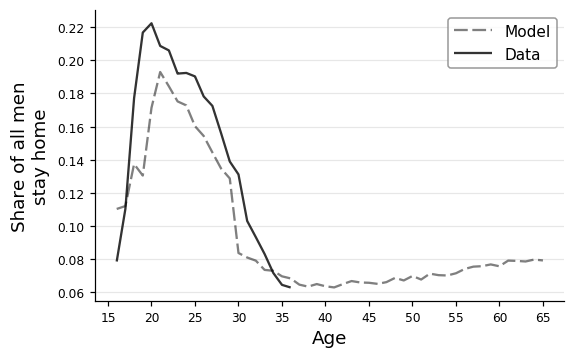

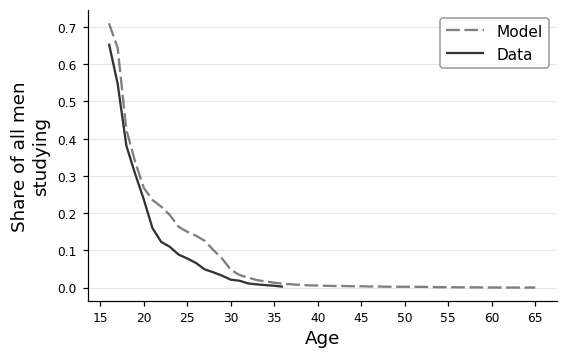

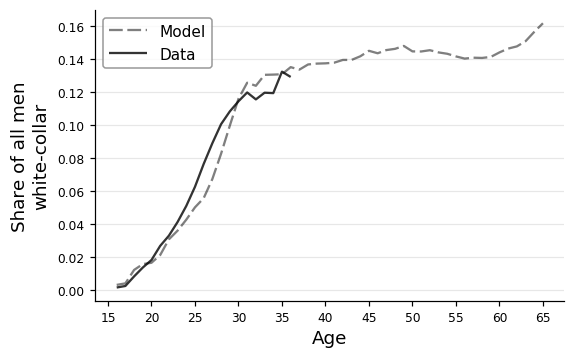

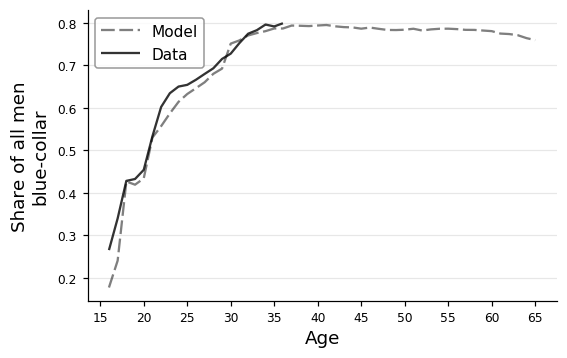

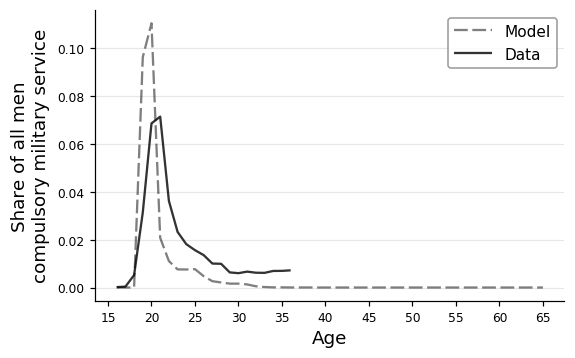

In [6]:
try:
    sim = pd.read_csv(r"/home/sabouri/Labor/CodeOutput/sim.csv",
                               header=None)
except:
    sim = pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/data/sim.csv",
                               header=None)

sim.columns = ["age","education","x3","x4","choice","income","educated","x5","type","Emax"] 
sim;


choiceMomentSim =sim.groupby(["age"])["choice"].value_counts(normalize=True).unstack().reset_index()
choiceMomentSim.fillna(0,inplace=True)
choiceMomentSim.columns = ["age","home","study","white","blue","mil"]
# choiceMomentSim
try:
    choiceMomentData= pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/choiceMoment.csv",header=None)
except:
    choiceMomentData= pd.read_csv(r"/home/sabouri/Labor/DataMoments/choiceMoment.csv",header=None)
choiceMomentData.columns = ["age","home","study","white","blue","mil"]
# choiceMomentData = choiceMoment
# choiceMomentData.rename(columns={"military":"mil"},inplace=True)
;


ageMax = 65

alternative = [
    "stay home"
    ,"studying"
    ,"white-collar"
    ,"blue-collar"
    ,"compulsory military service"
]
fSize = 12
tSize = 8

ind = 0

for ind,alter in enumerate(["home","study","white","blue","mil"]):
    fig= plt.figure(figsize=(5.5,3.5))
    plt.rc('font', family='sans')
    plt.rc('xtick',labelsize=tSize)
    plt.rc('ytick',labelsize=tSize)
    ax1=fig.add_subplot(1,1,1)
    ax1.plot("age", alter
            ,dashes= [6,2]
            ,data=choiceMomentSim.loc[(choiceMomentSim.age<=ageMax), :]
            ,label= "Model" #f"share of {alternative[ind]} in the model"
            ,markersize=3
            ,color= (0.0,0.0,0.0,0.5) #(0.5,0.8,0.5,1)
            ,linewidth= 1.5)

    ax1.plot("age", alter
            ,dashes= [1,0]
            ,data=choiceMomentData.loc[(choiceMomentData.age<=36), :]
            ,label= "Data" #f"share of {alternative[ind]} in the data"
            ,markersize=3
            ,color= (0.0,0.0,0.0,0.8)#(0,0.2,0.4,0.7)
            ,linewidth= 1.5)


    ax1.set_xlabel("Age" ,              fontsize=fSize,labelpad=3)
    ax1.set_ylabel("Share of all men\n"+alternative[ind] ,fontsize=fSize,labelpad=5)
    ax1.set_xticks(np.arange(15,ageMax+1,5))
    ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)] )
    ax1.grid(axis='y',alpha=0.3)
    ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-2}, ncol=1,handlelength=2.5,handleheight=1)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
#     fig.savefig(f"Results/Paper/1{alter}.pgf", bbox_inches='tight')
#     fig.savefig(f"../../Reports/English version/Latex/Figures/1{alter}.pdf", bbox_inches='tight')
    
    plt.show()
    ;

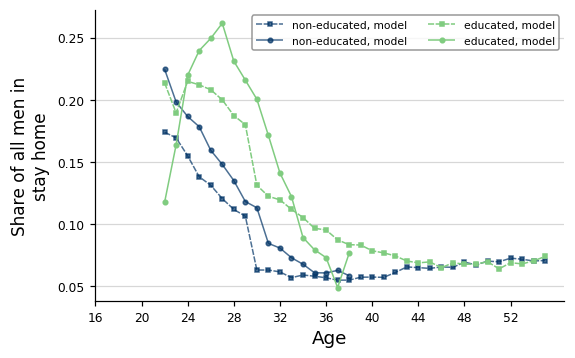

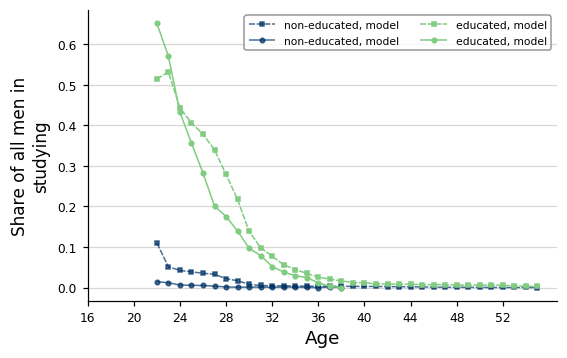

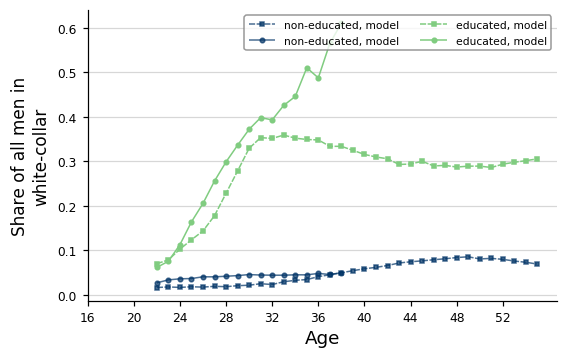

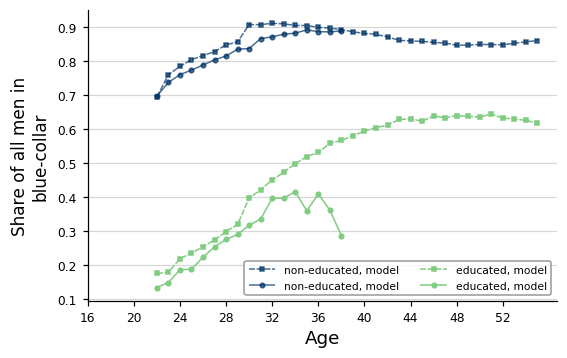

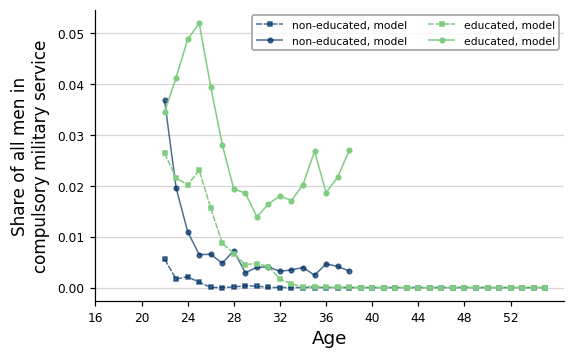

In [7]:
choiceMomentSim = sim.loc[(sim.age>=10),:].groupby(["age","educated"])["choice"].value_counts(normalize=True).unstack().reset_index()
choiceMomentSim.fillna(0,inplace=True)
choiceMomentSim.columns = ["age","educated","home","study","white","blue","mil"]
choiceMomentSim = choiceMomentSim.fillna(0)
choiceMomentSim = choiceMomentSim.loc[(choiceMomentSim.age>=22),:]
choiceMomentSim
;

try:
    choiceMomentData= pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/choiceMoment2.csv",header=None)
except:
    choiceMomentData= pd.read_csv(r"/home/sabouri/Labor/DataMoments/choiceMoment2.csv",header=None)
choiceMomentData.columns = ["age","educated","home","study","white","blue","mil"]
choiceMomentData.head()


ageMax = 55

alternative = [
    "stay home"
    ,"studying"
    ,"white-collar"
    ,"blue-collar"
    ,"compulsory military service"
]
educLabel = [
    "non-educated"
    ,"educated"
]

ind = 0

for ind,alter in enumerate(["home","study","white","blue","mil"]):
    fig= plt.figure(figsize=(5.5,3.5))
    ax1=fig.add_subplot(1,1,1)
    for educated in [0,1]:
        ax1.plot("age", alter,"s",markersize=3
                ,dashes= [4,1]
                ,data=choiceMomentSim.loc[(choiceMomentSim.age<=ageMax)&(choiceMomentSim.educated==educated), :]
                ,label= educLabel[educated]+", model"
                ,color= (0,0.2,0.4,0.7) if educated==0 else (0.5,0.8,0.5,1)
                ,linewidth= 1)

        ax1.plot("age", alter,"o",markersize=3
                ,dashes= [1,0]
                ,data=choiceMomentData.loc[(choiceMomentData.educated==educated),:]
                ,label= educLabel[educated]+", model"
                ,color= (0,0.2,0.4,0.7) if educated==0 else (0.5,0.8,0.5,1)
                ,linewidth= 1)


    ax1.set_xlabel("Age",fontsize=fSize,labelpad=3)
    ax1.set_ylabel("Share of all men in\n"+alternative[ind],fontsize=fSize-1,labelpad=5)
    ax1.set_xticks(np.arange(16,ageMax+1,4))
    ax1.set_xticklabels([age for age in np.arange(16,ageMax+1,4).astype(np.int)] )

    ax1.grid(axis='y',alpha=0.5)
    ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-5}, ncol=2,handlelength=2.5,handleheight=1)
    # Hide the right and top spines
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
#     fig.savefig(f"Results/SimResult/1.{ind+1} {alter} {ageMax}.jpg", bbox_inches='tight')
    plt.show()
    ;

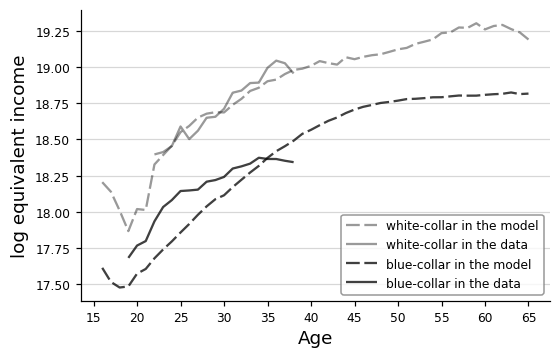

In [8]:
wageMomentSim =sim.loc[(sim.choice.isin([3,4])), :].groupby(["age","choice"]).agg({"income":"mean"}).reset_index() 
wageMomentSim["collar"]=wageMomentSim.choice.map({3:0,4:1})
wageMomentSim["logIncome"]= np.log(wageMomentSim.income)
wageMomentSim ;

try:
    wageMomentData= pd.read_csv(r"/home/sabouri/Labor/DataMoments/wageMoment.csv",header=None)
except:
    wageMomentData= pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/wageMoment.csv",header=None)

wageMomentData.columns = ["age","collar","income"]
wageMomentData["logIncome"]= np.log(wageMomentData.income)

wageMomentData ;


ageMax = 65

alternative = ["white-collar",
              "blue-collar"]
fSize = 12
tSize = 8
# for collar in [0,1]:
collar = 0 
fig= plt.figure(figsize=(5.5,3.5))
plt.rc('font', family='sans')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)
ax1=fig.add_subplot(1,1,1)
ax1.plot("age", "logIncome"
        ,dashes= [6,2]
        ,data=wageMomentSim.loc[(wageMomentSim.collar==collar)&(wageMomentSim.age<=ageMax), :]
        ,label= alternative[collar] + " in the model"
        ,markersize=3
        ,color= (0.0,0.0,0.0,0.4)
        ,linewidth= 1.5)

ax1.plot("age", "logIncome"
        ,dashes= [1,0]
        ,data=wageMomentData.loc[(wageMomentData.collar==collar)&(wageMomentData.age<=ageMax), :]
        ,label= alternative[collar] + " in the data"
        ,markersize=3
        ,color= (0.0,0.0,0.0,0.4)
        ,linewidth= 1.5)

collar = 1
ax1.plot("age", "logIncome"
        ,dashes= [6,2]
        ,data=wageMomentSim.loc[(wageMomentSim.collar==collar)&(wageMomentSim.age<=ageMax), :]
        ,label= alternative[collar] + " in the model"
        ,markersize=3
        ,color= (0.0,0.0,0.0,0.75)
        ,linewidth= 1.5)

ax1.plot("age", "logIncome"
        ,dashes= [1,0]
        ,data=wageMomentData.loc[(wageMomentData.collar==collar)&(wageMomentData.age<=ageMax), :]
        ,label= alternative[collar] + " in the data"
        ,markersize=3
        ,color= (0.0,0.0,0.0,0.75)
        ,linewidth= 1.5)



ax1.set_xlabel("Age",fontsize=fSize,labelpad=3)
ax1.set_ylabel("log equivalent income",fontsize=fSize,labelpad=4)
ax1.set_xticks(np.arange(15,ageMax+1,5))
ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)])

ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-4},
           ncol=1,handlelength=2.5,handleheight=1)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()
# fig.savefig(f"Results/Paper/2log mean income {ageMax}.pgf", bbox_inches='tight')
# fig.savefig(f"../../Reports/English version/Latex/Figures/2log mean income {ageMax}.pdf", bbox_inches='tight')



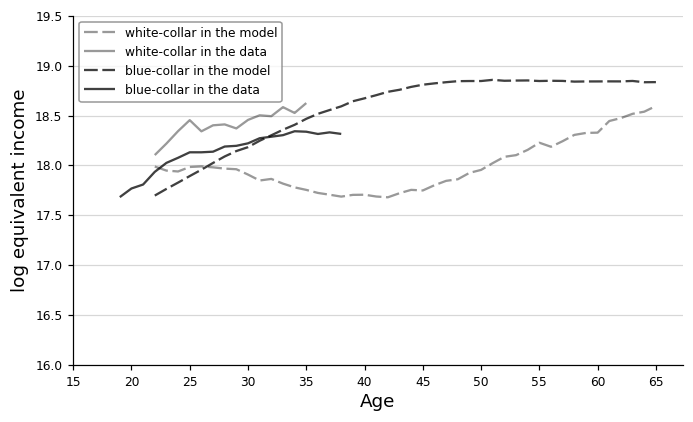

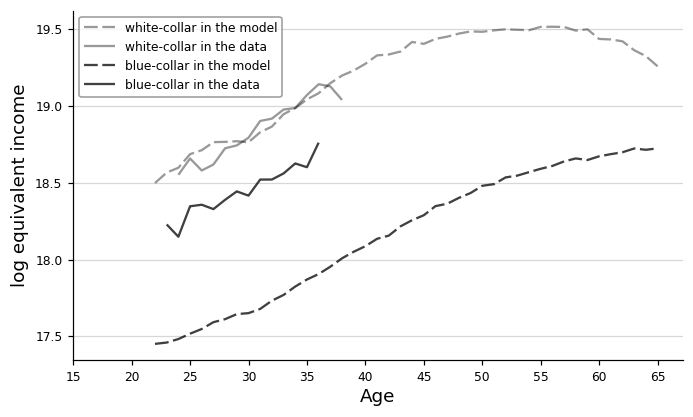

In [9]:
wageMomentSim =sim.loc[(sim.choice.isin([3,4])), :].groupby(["age","choice","educated"]).agg({"income":"mean"}).reset_index() 
wageMomentSim["collar"]=wageMomentSim.choice.map({3:0,4:1})
wageMomentSim["logIncome"]= np.log(wageMomentSim.income)
wageMomentSim ;

try:
    wageMomentData= pd.read_csv(r"/home/sabouri/Labor/DataMoments/wageMoment2.csv",header=None)
except:
    wageMomentData= pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/wageMoment2.csv",header=None)

wageMomentData.columns = ["age","educated","collar","income","deviation"]
wageMomentData["logIncome"]= np.log(wageMomentData.income)

wageMomentData 


ageMax = 65

alternative = ["white-collar",
              "blue-collar"]
fSize = 12
tSize = 8
# for collar in [0,1]:


# educated = 0
for educated in [0,1]:
    fig= plt.figure(figsize=(5.5*1.3,3.5*1.2))
    plt.rc('font', family='sans')
    plt.rc('xtick',labelsize=tSize)
    plt.rc('ytick',labelsize=tSize)
    ax1=fig.add_subplot(1,1,1)
    
    collar = 0 
    ax1.plot("age", "logIncome"
            ,dashes= [6,2]
            ,data=wageMomentSim.loc[(wageMomentSim.collar==collar)&(wageMomentSim.age<=ageMax)
                                    &(wageMomentSim.educated==educated), :]
            ,label= alternative[collar] + " in the model"
            ,markersize=3
            ,color= (0.0,0.0,0.0,0.4)
            ,linewidth= 1.5)

    ax1.plot("age", "logIncome"
            ,dashes= [1,0]
            ,data=wageMomentData.loc[(wageMomentData.collar==collar)&(wageMomentData.age<=ageMax)
                                     &(wageMomentData.educated==educated), :]
            ,label= alternative[collar] + " in the data"
            ,markersize=3
            ,color= (0.0,0.0,0.0,0.4)
            ,linewidth= 1.5)

    collar = 1
    ax1.plot("age", "logIncome"
            ,dashes= [6,2]
            ,data=wageMomentSim.loc[(wageMomentSim.collar==collar)&(wageMomentSim.age<=ageMax)
                                    &(wageMomentSim.educated==educated), :]
            ,label= alternative[collar] + " in the model"
            ,markersize=3
            ,color= (0.0,0.0,0.0,0.75)
            ,linewidth= 1.5)

    ax1.plot("age", "logIncome"
            ,dashes= [1,0]
            ,data=wageMomentData.loc[(wageMomentData.collar==collar)&(wageMomentData.age<=ageMax)
                                     &(wageMomentData.educated==educated), :]
            ,label= alternative[collar] + " in the data"
            ,markersize=3
            ,color= (0.0,0.0,0.0,0.75)
            ,linewidth= 1.5)



    ax1.set_xlabel("Age",fontsize=fSize,labelpad=3)
    ax1.set_ylabel("log equivalent income",fontsize=fSize,labelpad=4)
    ax1.set_xticks(np.arange(15,ageMax+1,5))
    ax1.set_xticklabels([age for age in np.arange(15,ageMax+1,5).astype(np.int)])

    ax1.grid(axis='y',alpha=0.5)
    ax1.legend(loc="best",edgecolor="gray", prop={"size":fSize-4},
               ncol=1,handlelength=2.5,handleheight=1)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    if educated == 0:
        ax1.set_ylim(16,19.5)
    plt.show()
    # fig.savefig(f"Results/Paper/2log mean income {ageMax}.pdf", bbox_inches='tight')


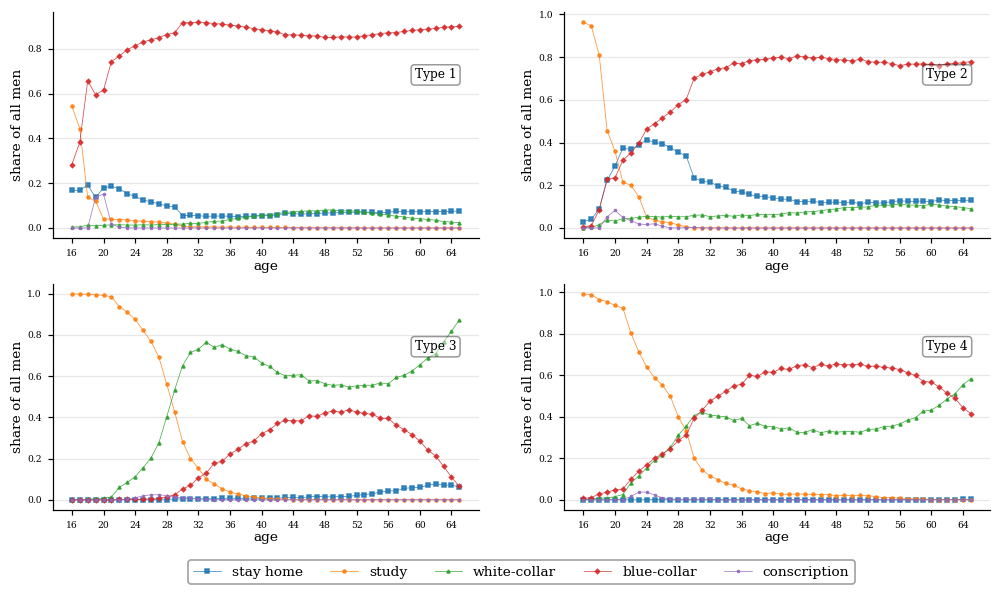

In [10]:
fSize = 9
tSize = 6

fig= plt.figure(figsize=(11,6))
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)

for type in [1,2,3,4]:
    choiceMomentSim =sim.loc[(sim.type==type),:].groupby(["age"])["choice"].value_counts(normalize=True).unstack().reset_index()
    choiceMomentSim.fillna(0,inplace=True)
    choiceMomentSim.columns = ["age","home","study","white","blue","mil"]
    choiceMomentSim

    labelFarsi = [
        "stay home",
        "study",
        "white-collar",
        "blue-collar",
        "conscription"
    ]
    
    ax1=fig.add_subplot(2,2,type)

    for index,choice in enumerate(["home","study","white","blue","mil"]):
        ax1.plot("age",choice
                ,data=choiceMomentSim
                ,label=f"{labelFarsi[index]}"
                ,linewidth=0.5
                ,marker=marker[index]
                ,markersize=2
                ,alpha=0.85)
                # , color = (0.0,0.0,0.0, 0.7))
    props = dict(boxstyle='round', facecolor='w', alpha=0.4)
    ax1.text(0.85, 0.75, f"Type {type}", transform=ax1.transAxes, fontsize=fSize-1,
        verticalalignment='top', bbox=props)
    ax1.set_xlabel("age",fontsize=fSize,labelpad=1)
    ax1.set_ylabel("share of all men",fontsize=fSize,labelpad=2)
    ax1.set_xticks(np.arange(choiceMomentSim.age.min(),choiceMomentSim.age.max()+1,4))
    ax1.set_xticklabels([age for age in 
                         np.arange(choiceMomentSim.age.min(),choiceMomentSim.age.max()+1,4).astype(np.int)])
    # ax1.set_ylim(-0.04 , 0.82)
    # ax1.set_yticks(np.arange(0.0,0.81,0.1))
    # ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)
    ax1.grid(axis='y',alpha=0.3)
    if type == 3 :
        lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'size':fSize}
                      , bbox_to_anchor=(1.1, -0.19),ncol=6,handlelength=2)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    

plt.show()
# fig.savefig(f"Results/Paper/type.pgf", bbox_inches='tight')
# fig.savefig(f"../../Reports/English version/Latex/Figures/type.pdf", bbox_inches='tight')


In [11]:
sim.loc[(sim.age==16),:].type.value_counts(normalize=True)#[1]

1.000   0.618
2.000   0.207
3.000   0.089
4.000   0.085
Name: type, dtype: float64

In [12]:
sim.loc[(sim.age==30),:].groupby(["type"])["choice"].value_counts(normalize=True).unstack().reset_index()

choice  type   1.0   2.0   3.0   4.0   5.0
0      1.000 0.056 0.009 0.017 0.918   nan
1      2.000 0.236 0.001 0.059 0.701 0.003
2      3.000 0.004 0.283 0.651 0.053 0.010
3      4.000   nan 0.201 0.406 0.392 0.002

## Heterogeneity between Endowment 

In [13]:
try:
    sim = pd.read_csv(r"/home/sabouri/Labor/CodeOutput/sim.csv",
                               header=None)
except:
    sim = pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/data/sim.csv",
                               header=None)

sim.columns = ["age","education","x3","x4","choice","income","educated","x5","type","Emax"] 
sim;



sim["military"] = "group one: participate"
sim.loc[(sim.x5.isna()),"military"] = "group two: Do not participate"
sim = sim.astype({"military":"category"})

sim["id"] = sim.index // 50

sim = pd.merge(sim,sim.loc[(sim.age==16),["id","education"]],on=["id"],how="left",suffixes=["","_16"])

sim["educ16"] = "10 years"
sim.loc[(sim.education_16<10),"educ16"] = "9 years or less"
sim = sim.astype({"educ16":"category"})

sim["Emax"] = sim.Emax #/1e7

In [14]:
sim.loc[(sim.age==16),:].groupby(["educ16"]).type.value_counts(normalize=True)#[1]

educ16           type 
10 years         1.000   0.533
                 2.000   0.211
                 4.000   0.134
                 3.000   0.122
9 years or less  1.000   0.720
                 2.000   0.203
                 3.000   0.051
                 4.000   0.026
Name: type, dtype: float64

* schooling and experiences at age 30 of different type and initial schooling and military status

In [15]:
sim.loc[(sim.age==30),:].groupby(["educ16","military","type"]).agg(
    {"education":"mean","x3":"mean","x4":"mean","Emax":"mean"})

education    x3     x4  \
educ16          military                      type                            
10 years        group one: participate        1.000     11.972 0.247  9.784   
                                              2.000     12.792 0.645  4.897   
                                              3.000     21.500 1.461  0.039   
                                              4.000     20.594 1.598  0.809   
                group two: Do not participate 1.000     11.992 0.320 11.701   
                                              2.000     12.664 0.732  6.719   
                                              3.000     21.695 3.137  0.154   
                                              4.000     20.193 2.358  2.447   
9 years or less group one: participate        1.000      7.541 0.073  8.777   
                                              2.000     12.696 0.394  3.163   
                                              3.000     19.802 0.160  0.000   
                                              4.000     19.122 0.366  0.146   
                group two: Do not participate 1.000      7.556 0.093 10.626   
                                              2.000     12.557 0.486  4.584   
                                              3.000     20.218 1.141  0.029   
                                              4.000     18.313 1.215  1.813   

                                                              Emax  
educ16          military                      type                  
10 years        group one: participate        1.000 1490423451.779  
                                              2.000  624436617.032  
                                              3.000 1935459015.176  
                                              4.000 1989435609.490  
                group two: Do not participate 1.000 1556685914.366  
                                              2.000  661920356.232  
                                              3.000 1912658758.268  
                                              4.000 2013545841.650  
9 years or less group one: participate        1.000 1170772844.654  
                                              2.000  573487686.150  
                                              3.000 1554920922.260  
                                              4.000 1616128157.003  
                group two: Do not participate 1.000 1225782304.801  
                                              2.000  604200067.588  
                                              3.000 1688291362.640  
                                              4.000 1667607645.910

In [16]:
aa = sim.loc[(sim.age==40),:].groupby(["type"]).agg(
    {"x3":"mean"})

# aa["Emax"] = np.log(aa.Emax)

aa

x3
type       
1.000 0.557
2.000 1.201
3.000 9.722
4.000 5.980

* schooling and experiences at age 30 of different type and initial schooling and military status

In [17]:
going = sim.loc[(sim.age==16)&(sim.military=="group one: participate"),:].groupby(["educ16","type"]).agg({"Emax":"mean"}).reset_index()
notGoing = sim.loc[(sim.age==16)&(sim.military=="group two: Do not participate"),:].groupby(["educ16","type"]).agg({"Emax":"mean"}).reset_index()

Emax16 = pd.merge(notGoing,going,on=["educ16","type"],suffixes=["NotGoing","Going"])

Emax16["EmaxNotGoing"] = np.log(Emax16.EmaxNotGoing)
Emax16["EmaxGoing"] = np.log(Emax16.EmaxGoing)

Emax16["diffPercent"] = (Emax16.EmaxNotGoing-Emax16.EmaxGoing)#/Emax16.EmaxNotGoing*100

Emax16

educ16  type  EmaxNotGoing  EmaxGoing  diffPercent
0         10 years 1.000        20.670     20.539        0.131
1         10 years 2.000        20.100     19.985        0.115
2         10 years 3.000        21.154     21.099        0.055
3         10 years 4.000        21.000     20.924        0.076
4  9 years or less 1.000        20.539     20.409        0.131
5  9 years or less 2.000        20.109     20.019        0.090
6  9 years or less 3.000        21.227     21.197        0.030
7  9 years or less 4.000        21.037     20.982        0.055

In [18]:
going = sim.loc[(sim.age==16)&(sim.military=="group one: participate"),:].groupby(["educ16"]).agg({"Emax":"mean"}).reset_index()
notGoing = sim.loc[(sim.age==16)&(sim.military=="group two: Do not participate"),:].groupby(["educ16"]).agg({"Emax":"mean"}).reset_index()

Emax16 = pd.merge(notGoing,going,on=["educ16"],suffixes=["NotGoing","Going"])

Emax16["diffPercent"] = (Emax16.EmaxNotGoing-Emax16.EmaxGoing)/Emax16.EmaxNotGoing*100

Emax16

educ16  EmaxNotGoing     EmaxGoing  diffPercent
0         10 years 993138842.316 817564396.768       17.679
1  9 years or less 833720049.228 711060725.624       14.712

In [19]:
going = sim.loc[(sim.age==16)&(sim.military=="group one: participate"),:].Emax.mean()
notGoing = sim.loc[(sim.age==16)&(sim.military=="group two: Do not participate"),:].Emax.mean()
print(going)
print(notGoing)

766215237.8031534
920797852.1691769


In [20]:
(notGoing-going)/notGoing

0.16787899103138035

In [21]:
# sim.loc[(sim.military=="group one: participate")].shape[0] / sim.shape[0]   
sim.loc[(sim.age==16),:].military.value_counts(normalize=True)

group two: Do not participate   0.862
group one: participate          0.138
Name: military, dtype: float64

In [22]:
# sim["mil"] = 1
# sim.loc[(sim.x5.isna()),"mil"] = 0

# sim.loc[(sim.age==16),:].groupby(["type","educ16"]).agg({"mil":"mean"}) 
# #.military.value_counts(normalize=True)

In [23]:
sim.loc[(sim.age==40),:].educated.mean()

# sim.groupby(["age"]).agg({"educated":"mean"})

0.30624

## Compulsory conscription effect on life-time earning

<br>

### Life-time utitlity

<br>

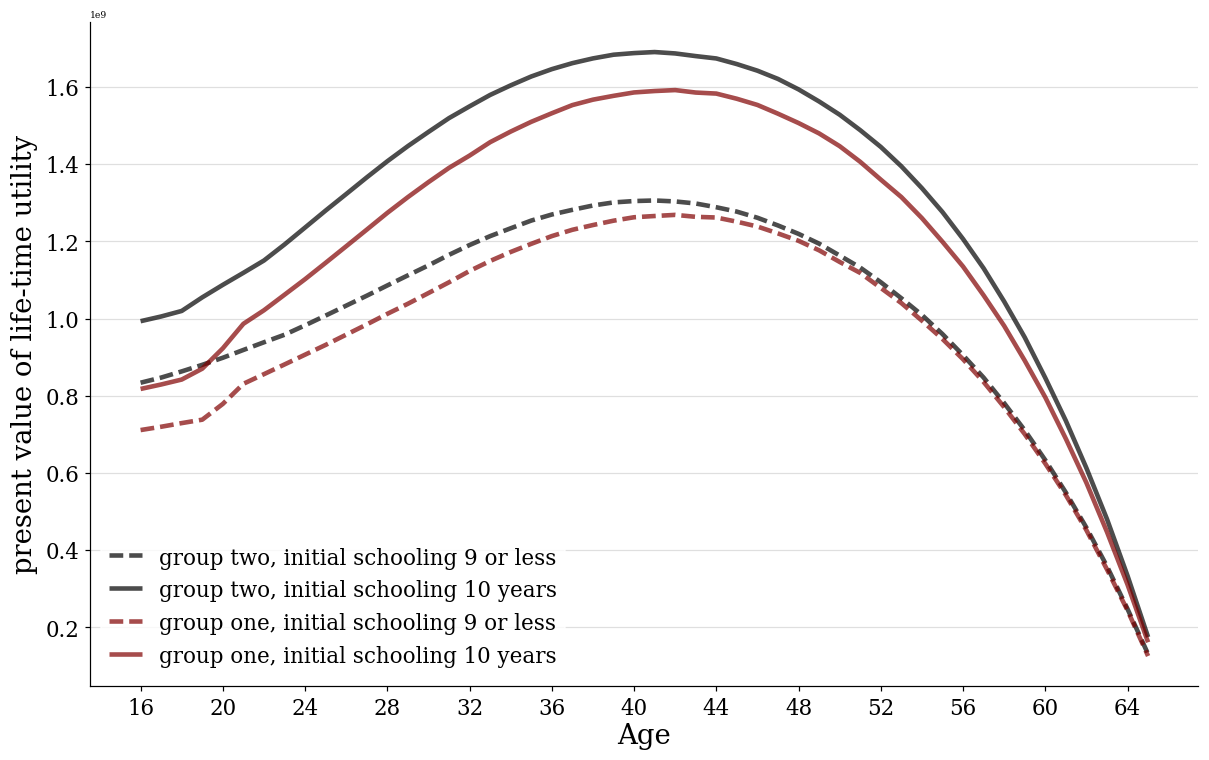

In [24]:
EmaxAgeTypeMil = sim.groupby(["age","military","educ16"]).agg({"Emax":"mean"}).reset_index()

labelMil = [
    "group two, " ,
    "group one, "
]


labelEduc = [
    "initial schooling 9 or less" ,
    "initial schooling 10 years"
]
# fig= plt.figure(figsize=(11,7))
fig= plt.figure(figsize=(13,8))
ax1=fig.add_subplot(1,1,1)

x = -1
for indexMil,mil in enumerate(["group two: Do not participate",
                              "group one: participate"]):    
    for indexEduc,educ16 in enumerate(["9 years or less","10 years"]):
        x+=1
        ax1.plot("age","Emax"
                ,markersize=5
                ,dashes= [3,1.3] if educ16=="9 years or less" else [1,0]
                ,label=f"{(labelMil[indexMil] + labelEduc[indexEduc])}"
                ,data=EmaxAgeTypeMil.loc[(EmaxAgeTypeMil.military==mil)
                                         &((EmaxAgeTypeMil.educ16==educ16)),:]
                ,linewidth=3
                ,color = (0.5 if mil=="group one: participate" else 0,0,0,0.7))
    
        
#     ax1.set_title(farsi(f"تایپ {Type}"),fontdict={'family': 'B Yas','size': 20},loc="right")

ax1.set_xlabel("Age",fontdict={'size': 18},labelpad=2)

ax1.set_ylabel("present value of life-time utility",
               fontsize=18,labelpad=5,fontweight='regular')

ax1.set_xticks(np.arange(16,65,4))
#     ax1.set_xticklabels([age for age in np.arange(choiceMomentSim.age.min(),choiceMomentSim.age.max()+1,4).astype(np.int)]
#                         ,rotation=0,fontsize=10)

# ax1.set_ylim(-0.04 , 0.82)
# ax1.set_yticks(np.arange(0.0,0.81,0.1))
# ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)
# these are matplotlib.patch.Patch properties
props = dict(facecolor='w', alpha=0.4,edgecolor='W')

# place a text box in upper left in axes coords
# ax1.text(0.02, 0.72, farsi(f"دسته اول: به سربازی می‌روند \n دسته دوم: به سربازی نمی‌روند"), transform=ax1.transAxes, fontsize=16,fontdict={'family': 'B Yas'},
#     verticalalignment='top', bbox=props)

ax1.grid(axis='y',alpha=0.4)
lgd=ax1.legend(loc='best',edgecolor='W',prop={'size':14}
              ,ncol=1,handlelength=1.5,handleheight=1)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelsize=14)
plt.show()
# fig.savefig(f"Results/life-time earning by mil and educ16.pdf", bbox_inches='tight')
# fig.savefig(f"Results/lifetime1.pdf", bbox_inches='tight')


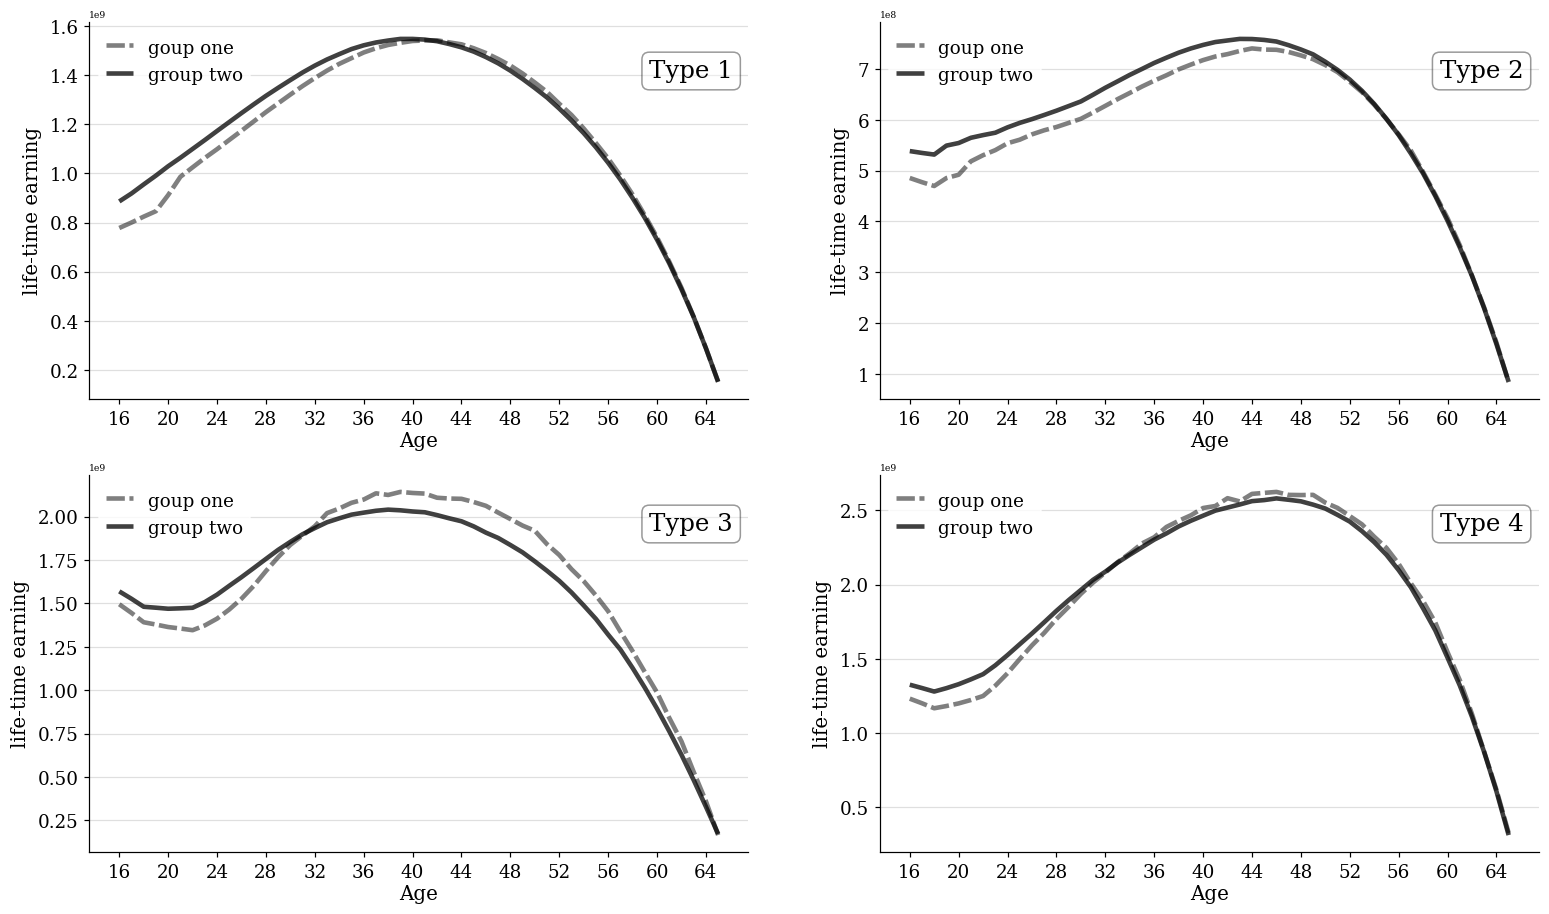

In [25]:
EmaxAgeTypeMil = sim.groupby(["age","type","military"]).agg({"Emax":"mean"}).reset_index()

labelFarsi = [
    "goup one",
    "group two"
]

# fig= plt.figure(figsize=(11,7))
fig= plt.figure(figsize=(17,10))


for Type in [1,2,3,4]:
    ax1=fig.add_subplot(2,2,Type)

    for index,mil in enumerate(["group one: participate", "group two: Do not participate"]):    
        ax1.plot("age","Emax"
                ,dashes= [4,1] if mil=="group one: participate" else [1,0]
                ,data=EmaxAgeTypeMil.loc[(EmaxAgeTypeMil.type==Type)
                                         &(EmaxAgeTypeMil.military==mil)
                                         &(EmaxAgeTypeMil.age>=14),:]
                ,label=f"{labelFarsi[index]}"
                ,linewidth=3
                ,color = (0,0,0,0.5 if mil=="group one: participate" else 0.75))

#     ax1.set_title(farsi(f"تایپ {Type}"),fontdict={'family': 'B Yas','size': 20},loc="right")

    ax1.set_xlabel("Age",fontdict={'size': 13},labelpad=2)
    if Type in [1,2,3,4]:
        ax1.set_ylabel("life-time earning",
                      fontdict={'size': 13},labelpad=5,fontweight='regular')
    ax1.set_xticks(np.arange(16,65,4))
    #     ax1.set_xticklabels([age for age in np.arange(choiceMomentSim.age.min(),choiceMomentSim.age.max()+1,4).astype(np.int)]
    #                         ,rotation=0,fontsize=10)

    # ax1.set_ylim(-0.04 , 0.82)
    # ax1.set_yticks(np.arange(0.0,0.81,0.1))
    # ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='w', alpha=0.4)

    # place a text box in upper left in axes coords
    ax1.text(0.85, 0.9, f"Type {Type}", transform=ax1.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

    ax1.grid(axis='y',alpha=0.4)
    lgd=ax1.legend(loc='upper left',edgecolor='w',prop={'size':12}
                  ,ncol=1,handlelength=1.5,handleheight=1)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.tick_params(labelsize=12)
plt.show()
# fig.savefig(f"Results/life-time earning by mil and educ16 and type.pdf", bbox_inches='tight')




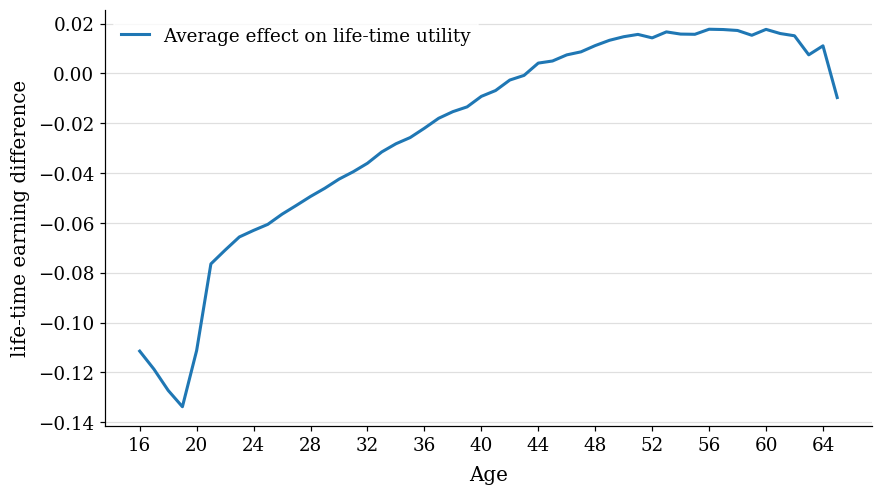

In [26]:
diff1 = sim.loc[(sim.type==1)&(sim.military=="group one: participate"),].groupby([
    "age"]).agg({"Emax":"mean"}).reset_index()
diff2 = sim.loc[(sim.type==1)&(sim.military=="group two: Do not participate"),].groupby([
    "age"]).agg({"Emax":"mean"}).reset_index()

diff = pd.merge(diff1,diff2,on=["age"])
diff["type 1"] = (diff.Emax_x - diff.Emax_y)/diff.Emax_y 
result = diff[["age","type 1"]]

for tt in [2,3,4]:
    diff1 = sim.loc[(sim.type==tt)&(sim.military=="group one: participate"),].groupby(["age"]).agg({"Emax":"mean"}).reset_index()
    diff2 = sim.loc[(sim.type==tt)&(sim.military=="group two: Do not participate"),].groupby(["age"]).agg({"Emax":"mean"}).reset_index()

    diff = pd.merge(diff1,diff2,on=["age"])
    diff[f"type {tt}"] = (diff.Emax_x - diff.Emax_y)/diff.Emax_y
    result = pd.merge(result,diff[["age",f"type {tt}"]],on=["age"])
    
    
# result

typeShare = sim.loc[(sim.age==16)&(sim.military=="group one: participate"),:].type.value_counts(normalize=True)
result["average"] = 0
for i in [1,2,3,4]:
    result["average"] = typeShare[i] * result[f"type {i}"] + result["average"]
    
result.head()



#******************************************
fig= plt.figure(figsize=(9,5))


# for Type in [1,2,3,4]:
ax1=fig.add_subplot(1,1,1)

# for index,mil in enumerate(["group one: participate", "group two: Do not participate"]):    
ax1.plot("age","average"
#         ,dashes= [4,1] if mil=="group one: participate" else [1,0]
        ,data=result.loc[:,:]
        ,label=f"Average effect on life-time utility"
        ,linewidth=2)
#         ,color = (0,0,0,0.8))


ax1.set_xlabel("Age",fontdict={'size': 13},labelpad=7)
ax1.set_ylabel("life-time earning difference",fontdict={'size': 13},labelpad=5,fontweight='regular')

ax1.set_xticks(np.arange(16,65,4))

props = dict(boxstyle='round', facecolor='w', alpha=0.4)

# place a text box in upper left in axes coords
# ax1.text(0.85, 0.9, f"Type {Type}", transform=ax1.transAxes, fontsize=16, verticalalignment='top', bbox=props)

ax1.grid(axis='y',alpha=0.4)
lgd=ax1.legend(loc='upper left',edgecolor='w',prop={'size':12}
              ,ncol=1,handlelength=1.5,handleheight=1)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelsize=12)
plt.show()

### Income

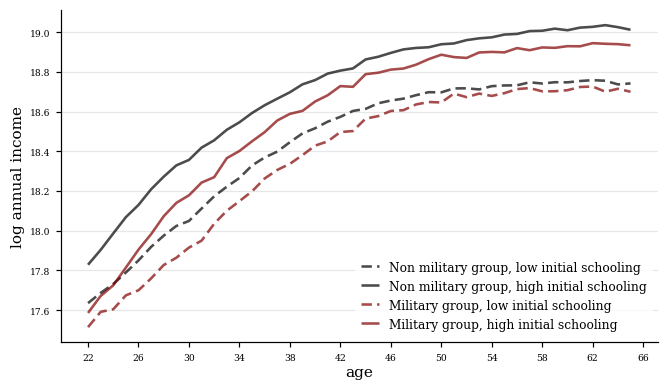

In [27]:
EmaxAgeTypeMil = sim.loc[(sim.age>=22),:].groupby(["age","military","educ16"]).agg({"income":"mean"}).reset_index()
EmaxAgeTypeMil["income"] = np.log(EmaxAgeTypeMil.income)

labelMil = [
    "Non military group, " ,
    "Military group, "
]


labelEduc = [
    "low initial schooling" ,
    "high initial schooling"
]

fSize = 10
tSize = 8

# fig= plt.figure(figsize=(11,7))
fig=plt.figure(figsize=(7, 4))
ax1=fig.add_subplot(1,1,1)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=tSize)
plt.rc('ytick',labelsize=tSize)

x = -1
for indexMil,mil in enumerate(["group two: Do not participate",
                              "group one: participate"]):    
    for indexEduc,educ16 in enumerate(["9 years or less","10 years"]):
        x+=1
        ax1.plot("age","income"
                # ,marker = marker[indexMil]
                # ,markersize=2.3
                ,dashes= [4,2] if educ16=="9 years or less" else [1,0]
                ,label=f"{(labelMil[indexMil] + labelEduc[indexEduc])}"
                ,data=EmaxAgeTypeMil.loc[(EmaxAgeTypeMil.military==mil)
                                         &((EmaxAgeTypeMil.educ16==educ16)),:]
                ,linewidth=1.7
                ,color = (0.5 if mil=="group one: participate" else 0,0,0,0.7))
    
        
#     ax1.set_title(farsi(f"تایپ {Type}"),fontdict={'family': 'B Yas','size': 20},loc="right")

ax1.set_xlabel("age",labelpad=2,fontsize=fSize)
ax1.set_ylabel("log annual income", fontsize=fSize,labelpad=3)

ax1.set_xticks(np.arange(22,67,4))
#     ax1.set_xticklabels([age for age in np.arange(choiceMomentSim.age.min(),choiceMomentSim.age.max()+1,4).astype(np.int)]
#                         ,rotation=0,fontsize=10)

# ax1.set_ylim(-0.04 , 0.82)
# ax1.set_yticks(np.arange(0.0,0.81,0.1))
# ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)
# these are matplotlib.patch.Patch properties
props = dict(facecolor='w', alpha=0.4,edgecolor='W')

# place a text box in upper left in axes coords
# ax1.text(0.02, 0.72, farsi(f"دسته اول: به سربازی می‌روند \n دسته دوم: به سربازی نمی‌روند"), transform=ax1.transAxes, fontsize=16,fontdict={'family': 'B Yas'},
#     verticalalignment='top', bbox=props)

ax1.grid(axis='y',alpha=0.3)
lgd=ax1.legend(loc='best',edgecolor='w',prop={'size':fSize-2}
              ,ncol=1,handlelength=1.5,handleheight=1)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()
# fig.savefig(f"../../Reports/English version/Latex/Figures/life-time earning by mil and educ16.pdf", bbox_inches='tight')


In [28]:
EmaxAgeTypeMil = sim.groupby(["age","type","military"]).agg({"income":"mean"}).reset_index()
EmaxAgeTypeMil["income"] = np.log(EmaxAgeTypeMil.income)

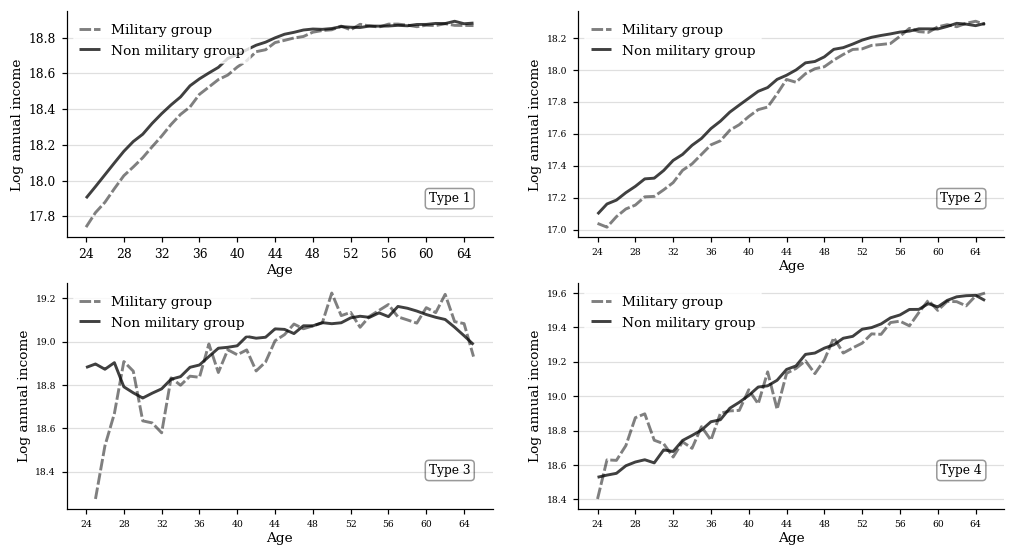

In [29]:


labelFarsi = [
    "Military group",
    "Non military group"
]
fSize = 9
tSize = 6
fig= plt.figure(figsize=(11,6))
# fig= plt.figure(figsize=(17,10))


for Type in [1,2,3,4]:
    ax1=fig.add_subplot(2,2,Type)
    plt.rc('font', family='serif')
    plt.rc('xtick',labelsize=tSize)
    plt.rc('ytick',labelsize=tSize)
    for index,mil in enumerate(["group one: participate", "group two: Do not participate"]):    
        ax1.plot("age","income"
                ,dashes= [4,1] if mil=="group one: participate" else [1,0]
                ,data=EmaxAgeTypeMil.loc[(EmaxAgeTypeMil.type==Type)
                                         &(EmaxAgeTypeMil.military==mil)
                                         &(EmaxAgeTypeMil.age>=24),:]
                ,label=f"{labelFarsi[index]}"
                ,linewidth=1.9
                ,color = (0,0,0,0.5 if mil=="group one: participate" else 0.75))

#     ax1.set_title(farsi(f"تایپ {Type}"),fontdict={'family': 'B Yas','size': 20},loc="right")

    ax1.set_xlabel("Age",fontsize=fSize,labelpad=2)
    if Type in [1,2,3,4]:
        ax1.set_ylabel("Log annual income",fontsize=fSize,labelpad=3)
    ax1.set_xticks(np.arange(24,65,4))
    #     ax1.set_xticklabels([age for age in np.arange(choiceMomentSim.age.min(),choiceMomentSim.age.max()+1,4).astype(np.int)]
    #                         ,rotation=0,fontsize=10)

    # ax1.set_ylim(-0.04 , 0.82)
    # ax1.set_yticks(np.arange(0.0,0.81,0.1))
    # ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='w', alpha=0.4)

    # place a text box in upper left in axes coords
    ax1.text(0.85, 0.2, f"Type {Type}", transform=ax1.transAxes, fontsize=fSize-1,
        verticalalignment='top', bbox=props)

    ax1.grid(axis='y',alpha=0.4)
    lgd=ax1.legend(loc='upper left',edgecolor='w',prop={'size':fSize}
                  ,ncol=1,handlelength=1.5,handleheight=1)
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
plt.show()
# fig.savefig(f"Results/Paper/life-time earning by mil and educ16 and type.pgf", bbox_inches='tight')
# fig.savefig(f"../../Reports/English version/Latex/Figures/life-time earning by mil and educ16 and type.pdf", bbox_inches='tight')




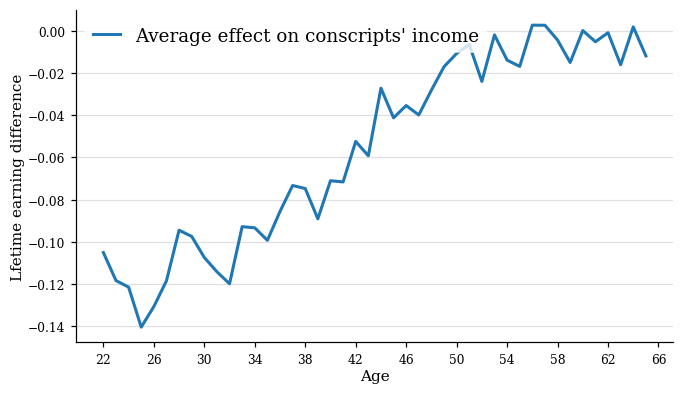

In [30]:

diff1 = sim.loc[(sim.age>=22)&(sim.type==1)&(sim.military=="group one: participate"),].groupby(["age"]).agg({"income":"mean"}).reset_index()
diff2 = sim.loc[(sim.age>=22)&(sim.type==1)&(sim.military=="group two: Do not participate"),].groupby(["age"]).agg({"income":"mean"}).reset_index()

diff = pd.merge(diff1,diff2,on=["age"])
# diff["income_x"] = np.log(diff.income_x)
# diff["income_y"] = np.log(diff.income_y)
diff["type 1"] = (diff.income_x - diff.income_y)/diff.income_y
result = diff[["age","type 1"]]

for tt in [2,3,4]:
    diff1 = sim.loc[(sim.type==tt)&(sim.military=="group one: participate"),].groupby(["age"]).agg({"income":"mean"}).reset_index()
    diff2 = sim.loc[(sim.type==tt)&(sim.military=="group two: Do not participate"),].groupby(["age"]).agg({"income":"mean"}).reset_index()

    diff = pd.merge(diff1,diff2,on=["age"])
#     diff["income_x"] = np.log(diff.income_x)
#     diff["income_y"] = np.log(diff.income_y)
    diff[f"type {tt}"] = (diff.income_x - diff.income_y)/diff.income_y
    result = pd.merge(result,diff[["age",f"type {tt}"]],on=["age"])
    
    
# result
result.fillna(0, inplace=True)
typeShare = sim.loc[(sim.age==16)&(sim.military=="group one: participate"),:].type.value_counts(normalize=True)
result["average"] = 0
for i in [1,2,3,4]:
    result["average"] = typeShare[i] * result[f"type {i}"] + result["average"]


# print(result.head())



#******************************************
fig= plt.figure(figsize=(7,4))

fSize = 10
tSize = 8
# for Type in [1,2,3,4]:
ax1=fig.add_subplot(1,1,1)

# for index,mil in enumerate(["group one: participate", "group two: Do not participate"]):    
ax1.plot("age","average"
#         ,dashes= [4,1] if mil=="group one: participate" else [1,0]
        ,data=result.loc[:,:]
        ,label=f"Average effect on conscripts' income"
        ,linewidth=2)
#         ,color = (0,0,0,0.8))


ax1.set_xlabel("Age",labelpad=2,fontsize=fSize)
ax1.set_ylabel("Lfetime earning difference",labelpad=2,fontsize=fSize)

ax1.set_xticks(np.arange(22,67,4))

props = dict(boxstyle='round', facecolor='w', alpha=0.4)

# place a text box in upper left in axes coords
# ax1.text(0.85, 0.9, f"Type {Type}", transform=ax1.transAxes, fontsize=16, verticalalignment='top', bbox=props)

ax1.grid(axis='y',alpha=0.4)
lgd=ax1.legend(loc='upper left',edgecolor='w',prop={'size':12}
              ,ncol=1,handlelength=1.5,handleheight=1)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelsize=tSize)
plt.show()
# fig.savefig(f"Results/Paper/average effect on conscripts income.pgf", bbox_inches='tight')
# fig.savefig(f"../../Reports/English version/Latex/Figures/average effect on conscripts income.pdf", bbox_inches='tight')



<br></br>
## Latex output 
<br></br>


In [30]:
ω1T1 = 17.821135744931293
ω1T2 = 17.15004146644513
ω1T3 = 17.246433733426983
ω1T4 = 17.115490814239713
α11 = -15.644757578492984
α12 = 16.443092181916015
α13 = -15.92442100698004
ω2T1 = 17.119188980274988
ω2T2 = 17.62777379230195
ω2T3 = 18.92034595966366
ω2T4 = 18.659296846027726
α21 = 17.25807868210704
tc1T1 = 17.838150523896807
tc2 = 17.663835137991445
α22 = 0.12733868752138708
α23 = 0.2690049377167906
α25 = 0.09749960712781927
α30study = -16.230282263881172
α3 = 14.883453963155073
ω3T1 = 14.983322039452377
ω3T2 = 14.45389803802563
ω3T3 = 15.149883841504563
ω3T4 = 15.152167145692376
α31 = 0.12216226807760436
α32 = 0.08672667020848523
α33 = 0.021363099917443486
α34 = -0.0032402574017335382
α35 = 0.00012359503531649587
ω4T1 = 16.781267388567404
ω4T2 = 15.996931754009072
ω4T3 = 16.340254459742845
ω4T4 = 16.79930212229079
α41 = 0.02841539777375748
α42 = 0.03265215947361173
α43 = 0.10915693436623712
α44 = -0.001988432162186431
α45 = -0.002015387979204839
α50 = 14.882579733172172
α51 = 15.231073304248538
α52 = 14.953841920486695
σ1 = 33.92413420890598
σ2 = 31.27000365128608
σ3 = 0.4999282805508579
σ4 = 0.31983281415948445
σ34 = 0.1713998915956022
σ5 = 32.1451810066792
πE1T1exp = 3.309193674530016
πE1T2exp = 2.0308050647750893
πE1T3exp = 0.6484173757852266
πE2T1exp = 1.372514905948539
πE2T2exp = 0.4553190319516045
πE2T3exp = -0.09477646109032327
π1T1exp = 1.6934129075613464
π1T2exp = 1.7754156968779518
π1T3exp = 2.587203379959395
π1T4exp = 2.588923306575371 

############################################
α21 = np.exp(α21)
tc1T1 = np.exp(tc1T1)
tc2 = np.exp(tc2)
α3 = np.exp(α3)
# α50 = np.exp(α50)
α51 = np.exp(α51)
α52 = np.exp(α52)
σ1 = np.sqrt(np.exp(σ1))
σ2 = np.sqrt(np.exp(σ2))
σ5 = np.sqrt(np.exp(σ5))
α11 = -np.exp(-α11)
α12 = np.exp(α12)
α13 = -np.exp(-α13)
α30study = -np.exp(-α30study)



α4 = 0.0  ;  # non pecuniary utility of blue-collar asssumed zero
# π1 = 0.78 ;  # share of individuals type 1

#= entry cost of without experience =#
α36, α46 = 0.0 , 0.0 ;
tc1T2 = tc1T1
tc1T3 = tc1T1
tc1T4 = tc1T1
α24 = α22

πE1T1 = np.exp(πE1T1exp)/(np.exp(πE1T1exp)+np.exp(πE1T2exp)+np.exp(πE1T3exp)+1)
πE1T2 = np.exp(πE1T2exp)/(np.exp(πE1T1exp)+np.exp(πE1T2exp)+np.exp(πE1T3exp)+1)
πE1T3 = np.exp(πE1T3exp)/(np.exp(πE1T1exp)+np.exp(πE1T2exp)+np.exp(πE1T3exp)+1)
πE1T4 = np.exp(0)/(np.exp(πE1T1exp)+np.exp(πE1T2exp)+np.exp(πE1T3exp)+1)

πE2T1 = np.exp(πE2T1exp)/(np.exp(πE2T1exp)+np.exp(πE2T2exp)+np.exp(πE2T3exp)+1)
πE2T2 = np.exp(πE2T2exp)/(np.exp(πE2T1exp)+np.exp(πE2T2exp)+np.exp(πE2T3exp)+1)
πE2T3 = np.exp(πE2T3exp)/(np.exp(πE2T1exp)+np.exp(πE2T2exp)+np.exp(πE2T3exp)+1)
πE2T4 = np.exp(0)/(np.exp(πE2T1exp)+np.exp(πE2T2exp)+np.exp(πE2T3exp)+1)

π1T1 = np.exp(π1T1exp) / (1+np.exp(π1T1exp))
π1T2 = np.exp(π1T2exp) / (1+np.exp(π1T2exp))
π1T3 = np.exp(π1T3exp) / (1+np.exp(π1T3exp))
π1T4 = np.exp(π1T4exp) / (1+np.exp(π1T4exp))


In [31]:
 
# # number 1# IsLog = 0 
# # param ω1T1 = 17.206210410475922
# ω1T1STD = 0.059242113402952164
 
# # number 2# IsLog = 0 
# # param ω1T2 = 16.80100236132292
# ω1T2STD = 0.16648998754332484
 
# # number 3# IsLog = 0 
# # param ω1T3 = 17.845861390236394
# ω1T3STD = 0.054813743645308194
 
# # number 4# IsLog = 0 
# # param ω1T4 = 17.39358653667415
# ω1T4STD = 0.3043438065234145
 
# # number 5# IsLog = 1 
# # param α11 = -4.324808352246317e6
# α11STD = 820757.7375419473
 
# # number 6# IsLog = 1 
# # param α12 = 7.302765971822288e6
# α12STD = 3.023347325735795e6
 
# # number 7# IsLog = 1 
# # param α13 = -1.2304484719094755e7
# α13STD = 650087.2376283623
 
# # number 8# IsLog = 0 
# # param ω2T1 = 16.12457636690639
# ω2T1STD = 0.10143933444328976
 
# # number 9# IsLog = 0 
# # param ω2T2 = 18.034200729767793
# ω2T2STD = 1.2755262148452924
 
# # number 10# IsLog = 0 
# # param ω2T3 = 19.37158270996246
# ω2T3STD = 0.049451287384770934
 
# # number 11# IsLog = 0 
# # param ω2T4 = 19.51895799429412
# ω2T4STD = 0.05297722902700455
 
# # number 12# IsLog = 1 
# # param α21 = 8.465823723620549e7
# α21STD = 5.062810473324035e6
 
# # number 13# IsLog = 1 
# # param tc1T1 = 2.0160686622854394e8
# tc1T1STD = 9.552822729396185e6
 
# # number 14# IsLog = 1 
# # param tc2 = 6.6150408286620066e7
# tc2STD = 3.094017362313057e6
 
# # number 15# IsLog = 0 
# # param α22 = 0.08884414372265025
# α22STD = 0.004569779020427756
 
# # number 16# IsLog = 0 
# # param α23 = 0.15605743021706184
# α23STD = 0.010411920825859358
 
# # number 17# IsLog = 0 
# # param α25 = 0.10262473045850386
# α25STD = 0.008281703398847212
 
# # number 18# IsLog = 1 
# # param α30study = -8.703338756849103e6
# α30studySTD = 1.9861971659766142e6
 
# # number 19# IsLog = 1 
# # param α3 = 3.5682307972031836e6
# α3STD = 887124.6295224982
 
# # number 20# IsLog = 0 
# # param ω3T1 = 14.060415350108283
# ω3T1STD = 0.8678357995802722
 
# # number 21# IsLog = 0 
# # param ω3T2 = 15.103207892523105
# ω3T2STD = 0.02809657557947952
 
# # number 22# IsLog = 0 
# # param ω3T3 = 14.84526014652997
# ω3T3STD = 0.03490208864843567
 
# # number 23# IsLog = 0 
# # param ω3T4 = 15.10029646125166
# ω3T4STD = 0.03377250145168745
 
# # number 24# IsLog = 0 
# # param α31 = 0.12510480220108106
# α31STD = 0.0014040149226067652
 
# # number 25# IsLog = 0 
# # param α32 = 0.09769641152996936
# α32STD = 0.0020771931188618455
 
# # number 26# IsLog = 0 
# # param α33 = 0.05697138338811244
# α33STD = 0.00241904615283595
 
# # number 27# IsLog = 0 
# # param α34 = -0.0034315012779852086
# α34STD = 0.00010439375279909028
 
# # number 28# IsLog = 0 
# # param α35 = -0.00609999092194062
# α35STD = 0.00033789877325441086
 
# # number 29# IsLog = 0 
# # param ω4T1 = 16.555366133312653
# ω4T1STD = 0.01374496194857975
 
# # number 30# IsLog = 0 
# # param ω4T2 = 15.996091476794433
# ω4T2STD = 0.033202149503198705
 
# # number 31# IsLog = 0 
# # param ω4T3 = 16.063528415111286
# ω4T3STD = 0.03534597631947094
 
# # number 32# IsLog = 0 
# # param ω4T4 = 16.527716929179867
# ω4T4STD = 0.028513623090165335
 
# # number 33# IsLog = 0 
# # param α41 = 0.05837921241858132
# α41STD = 0.0010801121612067156
 
# # number 34# IsLog = 0 
# # param α42 = 0.014457002818340598
# α42STD = 0.0012785648342375094
 
# # number 35# IsLog = 0 
# # param α43 = 0.11401686720491694
# α43STD = 0.001380061006335699
 
# # number 36# IsLog = 0 
# # param α44 = -0.006195809800063991
# α44STD = 0.00033114452796148775
 
# # number 37# IsLog = 0 
# # param α45 = -0.002988104177238432
# α45STD = 6.092662966988213e-5
 
# # number 38# IsLog = 0 
# # param α50 = 15.965528634915069
# α50STD = 2.992953601706488
 
# # number 39# IsLog = 1 
# # param α51 = 1.3202281267807227e7
# α51STD = 3.243173919664683e11
 
# # number 40# IsLog = 1 
# # param α52 = 5.395638213596865e6
# α52STD = 1.16533929275913e8
 
# # number 41# IsLog = 1 
# # param σ1 = 1.0783578001549805e15
# σ1STD = 1.500543950638874e14
 
# # number 42# IsLog = 1 
# # param σ2 = 8.273381165885625e13
# σ2STD = 5.1530810286968984e13
 
# # number 43# IsLog = 0 
# # param σ3 = 0.6158522459978923
# σ3STD = 0.013416771079419793
 
# # number 44# IsLog = 0 
# # param σ4 = 0.31519634955735093
# σ4STD = 0.005043437981649469
 
# # number 45# IsLog = 0 
# # param σ34 = 0.17540348640347714
# σ34STD = 0.009507391829974695
 
# # number 46# IsLog = 1 
# # param σ5 = 1.2444590088950795e15
# σ5STD = 1.4281565207240218e15
 
# # number 47# IsLog = 0 
# # param πE1T1 = 2.5991609189280798
# πE1T1STD = 0.006987961774358083
 
# # number 48# IsLog = 0 
# # param πE1T2 = 0.31580968464617004
# πE1T2STD = 0.0035960342271840486
 
# # number 49# IsLog = 0 
# # param πE1T3 = -0.16162980840009109
# πE1T3STD = 0.0017445954851855073
 
# # number 50# IsLog = 0 
# # param πE2T1 = 1.4739172889195529
# πE2T1STD = 0.009016194052255374
 
# # number 51# IsLog = 0 
# # param πE2T2 = 0.5716440914037556
# πE2T2STD = 0.006393322085494628
 
# # number 52# IsLog = 0 
# # param πE2T3 = 0.004417678382582084
# πE2T3STD = 1.547030894779743e-14
 
# # number 53# IsLog = 0 
# # param π1T1 = 1.8501419314430443
# π1T1STD = 0.006535093216818663
 
# # number 54# IsLog = 0 
# # param π1T2 = 1.9465414469678233
# π1T2STD = 0.02512117550582634
 
# # number 55# IsLog = 0 
# # param π1T3 = 2.745313182766822
# π1T3STD = 0.012148512584436598
 
# # number 56# IsLog = 0 
# # param π1T4 = 2.751444085270356
# π1T4STD = 0.011047944353153176







# number 1# IsLog = 0 
# param ω1T1 = 17.821135744931293
ω1T1STD = 0.019165767812555436
 
# number 2# IsLog = 0 
# param ω1T2 = 17.15004146644513
ω1T2STD = 0.12552800387382254
 
# number 3# IsLog = 0 
# param ω1T3 = 17.246433733426983
ω1T3STD = 0.603490951592461
 
# number 4# IsLog = 0 
# param ω1T4 = 17.115490814239713
ω1T4STD = 3.999408916957226
 
# number 5# IsLog = 1 
# param α11 = -6.229194436639572e6
α11STD = 544803.1790208914
 
# number 6# IsLog = 1 
# param α12 = 1.3840258447282169e7
α12STD = 3.5848297184306458e6
 
# number 7# IsLog = 1 
# param α13 = -8.239259299270849e6
α13STD = 755677.5942038235
 
# number 8# IsLog = 0 
# param ω2T1 = 17.119188980274988
ω2T1STD = 0.04009409465121985
 
# number 9# IsLog = 0 
# param ω2T2 = 17.62777379230195
ω2T2STD = 0.23183556674252373
 
# number 10# IsLog = 0 
# param ω2T3 = 18.92034595966366
ω2T3STD = 0.11197071695329691
 
# number 11# IsLog = 0 
# param ω2T4 = 18.659296846027726
ω2T4STD = 0.1382868084058129
 
# number 12# IsLog = 1 
# param α21 = 3.1267153079689432e7
α21STD = 1.803382281111504e6
 
# number 13# IsLog = 1 
# param tc1T1 = 5.584834912170728e7
tc1T1STD = 8.742668380886748e6
 
# number 14# IsLog = 1 
# param tc2 = 4.691439603355582e7
tc2STD = 1.2443773276432032e7
 
# number 15# IsLog = 0 
# param α22 = 0.12733868752138708
α22STD = 0.006292108310366
 
# number 16# IsLog = 0 
# param α23 = 0.2690049377167906
α23STD = 0.02492480670051738
 
# number 17# IsLog = 0 
# param α25 = 0.09749960712781927
α25STD = 0.012527546923675234
 
# number 18# IsLog = 1 
# param α30study = -1.1187216090761894e7
α30studySTD = 2.215055355891395e6
 
# number 19# IsLog = 1 
# param α3 = 2.9093899068247094e6
α3STD = 2.0714403105318828e6
 
# number 20# IsLog = 0 
# param ω3T1 = 14.983322039452377
ω3T1STD = 0.029326509951895962
 
# number 21# IsLog = 0 
# param ω3T2 = 14.45389803802563
ω3T2STD = 0.0832395014263316
 
# number 22# IsLog = 0 
# param ω3T3 = 15.149883841504563
ω3T3STD = 0.08394504692656662
 
# number 23# IsLog = 0 
# param ω3T4 = 15.152167145692376
ω3T4STD = 0.08552203903521684
 
# number 24# IsLog = 0 
# param α31 = 0.12216226807760436
α31STD = 0.0023477195078322037
 
# number 25# IsLog = 0 
# param α32 = 0.08672667020848523
α32STD = 0.0035927026015954563
 
# number 26# IsLog = 0 
# param α33 = 0.021363099917443486
α33STD = 0.000797043172774171
 
# number 27# IsLog = 0 
# param α34 = -0.0032402574017335382
α34STD = 0.0002724047789928597
 
# number 28# IsLog = 0 
# param α35 = 0.00012359503531649587
α35STD = 1.6631609683403305e-5
 
# number 29# IsLog = 0 
# param ω4T1 = 16.781267388567404
ω4T1STD = 0.013003076623498035
 
# number 30# IsLog = 0 
# param ω4T2 = 15.996931754009072
ω4T2STD = 0.03987190937255481
 
# number 31# IsLog = 0 
# param ω4T3 = 16.340254459742845
ω4T3STD = 0.18207075393167074
 
# number 32# IsLog = 0 
# param ω4T4 = 16.79930212229079
ω4T4STD = 0.04518855232720507
 
# number 33# IsLog = 0 
# param α41 = 0.02841539777375748
α41STD = 0.0010207859081398053
 
# number 34# IsLog = 0 
# param α42 = 0.03265215947361173
α42STD = 0.001493958157311707
 
# number 35# IsLog = 0 
# param α43 = 0.10915693436623712
α43STD = 0.001056097459846834
 
# number 36# IsLog = 0 
# param α44 = -0.001988432162186431
α44STD = 0.00021516173648793076
 
# number 37# IsLog = 0 
# param α45 = -0.002015387979204839
α45STD = 3.714126150264899e-5
 
# number 38# IsLog = 0 
# param α50 = 14.882579733172172
α50STD = 1.6784132096799667
 
# number 39# IsLog = 1 
# param α51 = 4.118803655369918e6
α51STD = 3.9429074186999123e6
 
# number 40# IsLog = 1 
# param α52 = 3.1215552728984714e6
α52STD = 1.2424467685865211e8
 
# number 41# IsLog = 1 
# param σ1 = 5.4083437880157475e14
σ1STD = 8.12224944230363e13
 
# number 42# IsLog = 1 
# param σ2 = 3.805309933866672e13
σ2STD = 2.2320751295633477e13
 
# number 43# IsLog = 0 
# param σ3 = 0.4999282805508579
σ3STD = 0.011370801731194475
 
# number 44# IsLog = 0 
# param σ4 = 0.31983281415948445
σ4STD = 0.006203874753379481
 
# number 45# IsLog = 0 
# param σ34 = 0.1713998915956022
σ34STD = 0.007246229387686133
 
# number 46# IsLog = 1 
# param σ5 = 9.130083112135336e13
σ5STD = 7.622399065934972e14
 
# number 47# IsLog = 0 
# param πE1T1 = 3.309193674530016
πE1T1STD = 0.021142936702259276
 
# number 48# IsLog = 0 
# param πE1T2 = 2.0308050647750893
πE1T2STD = 0.016976946391407403
 
# number 49# IsLog = 0 
# param πE1T3 = 0.6484173757852266
πE1T3STD = 0.00476013695585532
 
# number 50# IsLog = 0 
# param πE2T1 = 1.372514905948539
πE2T1STD = 0.010545084551701467
 
# number 51# IsLog = 0 
# param πE2T2 = 0.4553190319516045
πE2T2STD = 0.00646922562445281
 
# number 52# IsLog = 0 
# param πE2T3 = -0.09477646109032327
πE2T3STD = 0.00192323123320814
 
# number 53# IsLog = 0 
# param π1T1 = 1.6934129075613464
π1T1STD = 0.004557543700427038
 
# number 54# IsLog = 0 
# param π1T2 = 1.7754156968779518
π1T2STD = 0.019274361112031027
 
# number 55# IsLog = 0 
# param π1T3 = 2.587203379959395
π1T3STD = 0.019062376917861782
 
# number 56# IsLog = 0 
# param π1T4 = 2.588923306575371
π1T4STD = 0.021721188078472384
 

In [32]:
def O(n):
    import math
    return math.floor(math.log10(n))

O(12)

1

In [12]:


tableParameters1 = f"""\\begin{{tabular}}{{lrlrlrl}}
\\toprule
                            & \multicolumn{{2}}{{c}}{{White-collar}} & \multicolumn{{2}}{{c}}{{Blue-collar}} & \multicolumn{{2}}{{c}}{{Conscription}} \\\\
\\cmidrule{{2-7}}
Constants:                  &                 &                  &                &                  &                 &                \\\\
\ \ \ \ Type 1                      &{ω3T1:.4f}       &({ω3T1STD:.4f})   &{ω4T1:.4f}      &({ω4T1STD:.4f})   &{α50:.4f}        &({α50STD:.4f})  \\\\
\ \ \ \ Type 2                      &{ω3T2:.4f}       &({ω3T2STD:.4f})   &{ω4T2:.4f}      &({ω4T2STD:.4f})   &\multicolumn{{2}}{{c}}{{...}}     \\\\
\ \ \ \ Type 3                      &{ω3T3:.4f}       &({ω3T3STD:.4f})   &{ω4T3:.4f}      &({ω4T3STD:.4f})   &\multicolumn{{2}}{{c}}{{...}}     \\\\
\ \ \ \ Type 4                      &{ω3T4:.4f}       &({ω3T4STD:.4f})   &{ω4T4:.4f}      &({ω4T4STD:.4f})   &\multicolumn{{2}}{{c}}{{...}}     \\\\
White-collar experience             &{α32:.4f}        &({α32STD:.4f})    &{α42:.4f}       &({α42STD:.4f})    &\multicolumn{{2}}{{c}}{{...}}     \\\\
White-collar exp. squared           &{α34:.4f}        &({α34STD:.4f})    &{α44:.4f}       &({α44STD:.4f})    &\multicolumn{{2}}{{c}}{{...}}     \\\\
Blue-collar exp.                    &{α33:.4f}        &({α33STD:.4f})    &{α43:.4f}       &({α43STD:.4f})    &\multicolumn{{2}}{{c}}{{...}}     \\\\
Blue-collar exp. squared            &{α35:.4f}        &({α35STD:.4f})    &{α45:.4f}       &({α45STD:.4f})    &\multicolumn{{2}}{{c}}{{...}}     \\\\
Education (linear term)             &{α31:.4f}        &({α31STD:.4f})    &{α41:.4f}       &({α41STD:.4f})    &\multicolumn{{2}}{{c}}{{...}}     \\\\
Has Bachelor degree                 &{α23:.4f}        &({α23STD:.4f})    &{α25:.4f}       &({α25STD:.4f})    &{α51/1e6:.3f}$\\times10^6$        &({α51STD/10**(O(α51STD)):.3f}$\\times10^{ {O(α51STD)} }$)              \\\\
Has Diploma degree               &\multicolumn{{4}}{{c}}{{{α22:.4f} ({α22STD:.4f})}}                         &{α52/1e6:.3f}$\\times10^6$        &({α52STD/10**(O(α52STD)):.3f}$\\times10^{ {O(α52STD)} }$)              \\\\
Error's Variance-Covariance         &                 &                  &                &                  &                 &                \\\\
\ \ \ \ White-collar                &{σ3:.4f}         &({σ3STD:.4f})     &\multicolumn{{2}}{{c}}{{...}}      &\multicolumn{{2}}{{c}}{{...}}     \\\\
\ \ \ \ Blue-collar                 &{σ34:.4f}        &({σ34STD:.4f})    &{σ4:.4f}        &({σ4STD:.4f})     & \multicolumn{{2}}{{c}}{{...}}    \\\\
\ \ \ \ Conscription                &\multicolumn{{2}}{{c}}{{...}}       &\multicolumn{{2}}{{c}}{{...}}      &{σ5/1e6:.3f}$\\times10^6$         &({σ5STD/10**(O(σ5STD)):.3f}$\\times10^{ {O(σ5STD)} }$)              \\\\
\\bottomrule
\end{{tabular}}"""

print(tableParameters1)

try:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/tableParameters1.tex","w") as file:
        file.write(tableParameters1)
except:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/tableParameters1.tex","w") as file:
        file.write(tableParameters1)

\begin{tabular}{lrlrlrl}
\toprule
                            & \multicolumn{2}{c}{White-collar} & \multicolumn{2}{c}{Blue-collar} & \multicolumn{2}{c}{Conscription} \\
\cmidrule{2-7}
Constants:                  &                 &                  &                &                  &                 &                \\
\ \ \ \ Type 1                      &14.9833       &(0.0293)   &16.7813      &(0.0130)   &14.8826        &(1.6784)  \\
\ \ \ \ Type 2                      &14.4539       &(0.0832)   &15.9969      &(0.0399)   &\multicolumn{2}{c}{...}     \\
\ \ \ \ Type 3                      &15.1499       &(0.0839)   &16.3403      &(0.1821)   &\multicolumn{2}{c}{...}     \\
\ \ \ \ Type 4                      &15.1522       &(0.0855)   &16.7993      &(0.0452)   &\multicolumn{2}{c}{...}     \\
White-collar experience             &0.0867        &(0.0036)    &0.0327       &(0.0015)    &\multicolumn{2}{c}{...}     \\
White-collar exp. squared           &-0.0032        &(0.0003)    &-0.002

In [13]:


tableParameters2 = f"""\\begin{{tabular}}{{lrlrl}}
\\toprule
                             & \multicolumn{{2}}{{c}}{{Study}} & \multicolumn{{2}}{{c}}{{Stay home}} \\\\
\\cmidrule{{2-5}}
Constants:                        &                                &                                                                               &                                 &                  \\\\
\ \ \ \ Type 1                    &{ω2T1:.4f}                      &({ω2T1STD:.4f})                                                                &{ω1T1:.4f}                       &({ω1T1STD:.4f})   \\\\
\ \ \ \ Type 2                    &{ω2T2:.4f}                      &({ω2T2STD:.4f})                                                                &{ω1T2:.4f}                       &({ω1T2STD:.4f})   \\\\
\ \ \ \ Type 3                    &{ω2T3:.4f}                      &({ω2T3STD:.4f})                                                                &{ω1T3:.4f}                       &({ω1T3STD:.4f})   \\\\
\ \ \ \ Type 4                    &{ω2T4:.4f}                      &({ω2T4STD:.4f})                                                                &{ω1T4:.4f}                       &({ω1T4STD:.4f})   \\\\
Cost of study reenty              &{α21/1e6:.2f}$\\times10^6$      &({α21STD/10**(O(α21STD)):.3f}$\\times10^{ {O(α21STD)} }$)                      &\multicolumn{{2}}{{c}}{{...}}                       \\\\
Cost of university education      &{tc1T1/1e6:.2f}$\\times10^6$    &({tc1T1STD/10**(O(tc1T1STD)):.3f}$\\times10^{ {O(tc1T1STD)} }$)                &\multicolumn{{2}}{{c}}{{...}}                       \\\\
Excess cost of graduate education &{tc2/1e6:.2f}$\\times10^6$      &({tc2STD/10**(O(tc2STD)):.3f}$\\times10^{ {O(tc2STD)} }$)                      &\multicolumn{{2}}{{c}}{{...}}                       \\\\
Age 30 or above                   &{α30study/1e6:.2f}$\\times10^6$ &({α30studySTD/10**(O(α30studySTD)):.3f}$\\times10^{ {O(α30studySTD)} }$)       &{α13/1e6:.2f}$\\times10^6$       &({α13STD/10**(O(α13STD)):.3f}$\\times10^{ {O(α13STD)} }$)                \\\\
Age 18 or less                    &\multicolumn{{2}}{{c}}{{...}}                                                                                   &{α11/1e6:.2f}$\\times10^6$       &({α11STD/10**(O(α11STD)):.3f}$\\times10^{ {O(α11STD)} }$)                \\\\
Has Diploma degree                &\multicolumn{{2}}{{c}}{{...}}                                                                                   &{α12/1e6:.2f}$\\times10^6$       &({α12STD/10**(O(α12STD)):.3f}$\\times10^{ {O(α12STD)} }$)                \\\\
Error's Variance-Covariance       &{σ2/1e6:.3f}$\\times10^6$       &({σ2STD/10**(O(σ2STD)):.3f}$\\times10^{ {O(σ2STD)} }$)                         &{σ1/1e6:.3f}$\\times10^6$        &({σ1STD/10**(O(σ1STD)):.3f}$\\times10^{ {O(σ1STD)} }$)                \\\\
\\bottomrule
\end{{tabular}}"""

print(tableParameters2)
try:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/tableParameters2.tex","w") as file:
        file.write(tableParameters2)
except:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/tableParameters2.tex","w") as file:
        file.write(tableParameters2)

\begin{tabular}{lrlrl}
\toprule
                             & \multicolumn{2}{c}{Study} & \multicolumn{2}{c}{Stay home} \\
\cmidrule{2-5}
Constants:                        &                                &                                                                               &                                 &                  \\
\ \ \ \ Type 1                    &17.1192                      &(0.0401)                                                                &17.8211                       &(0.0192)   \\
\ \ \ \ Type 2                    &17.6278                      &(0.2318)                                                                &17.1500                       &(0.1255)   \\
\ \ \ \ Type 3                    &18.9203                      &(0.1120)                                                                &17.2464                       &(0.6035)   \\
\ \ \ \ Type 4                    &18.6593                      &(0.1383)                                    

In [37]:
tyShAv = sim.loc[(sim.age==16),:].type.value_counts(normalize=True)#[1]
tyShAv[1]

0.618445

In [40]:


tableParameters3 = f"""
\\begin{{tabular}}{{lrlrlrlrl}}
\\toprule
                  & \\multicolumn{{2}}{{c}}{{Type 1}} & \\multicolumn{{2}}{{c}}{{Type 2}} & \\multicolumn{{2}}{{c}}{{Type 3}} & \\multicolumn{{2}}{{c}}{{Type 4}} \\\\
\\cmidrule{{2-9}}
Initial schooling  &              &                  &               &                  &               &                  &               &             \\\\
9 years or leass  &{πE1T1:.4f}    &({πE1T1STD:.4f})  &{πE1T2:.4f}    &({πE1T2STD:.4f})  &{πE1T3:.4f}    &({πE1T3STD:.4f})  &{πE1T4:.4f}    &(...)           \\\\
10 years          &{πE2T1:.4f}    &({πE2T1STD:.4f})  &{πE2T2:.4f}    &({πE2T2STD:.4f})  &{πE2T3:.4f}    &({πE2T3STD:.4f})  &{πE2T4:.4f}    &(...)           \\\\
Group two share   &{π1T1:.4f}     &({π1T1STD:.4f})   &{π1T2:.4f}     &({π1T2STD:.4f})   &{π1T3:.4f}     &({π1T3STD:.4f})   &{π1T4:.4f}     &({π1T4STD:.4f})           \\\\
\\hdashline
Total share       &\\multicolumn{{2}}{{c}}{{{tyShAv[1]:.4f}}}   &\\multicolumn{{2}}{{c}}{{{tyShAv[2]:.4f}}} &\\multicolumn{{2}}{{c}}{{{tyShAv[3]:.4f}}} &\\multicolumn{{2}}{{c}}{{{tyShAv[4]:.4f}}} \\\\
Discount factor   &               \\multicolumn{{8}}{{c}}{{0.92}}             \\\\
\\bottomrule
\\end{{tabular}}
"""

print(tableParameters3)

try:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/tableParameters3.tex","w") as file:
        file.write(tableParameters3)
except:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/tableParameters3.tex","w") as file:
        file.write(tableParameters3)


\begin{tabular}{lrlrlrlrl}
\toprule
                  & \multicolumn{2}{c}{Type 1} & \multicolumn{2}{c}{Type 2} & \multicolumn{2}{c}{Type 3} & \multicolumn{2}{c}{Type 4} \\
\cmidrule{2-9}
Initial schooling  &              &                  &               &                  &               &                  &               &             \\
9 years or leass  &0.7221    &(0.0211)  &0.2011    &(0.0170)  &0.0505    &(0.0048)  &0.0264    &(...)           \\
10 years          &0.5309    &(0.0105)  &0.2122    &(0.0065)  &0.1224    &(0.0019)  &0.1346    &(...)           \\
Group two share   &0.8447     &(0.0046)   &0.8551     &(0.0193)   &0.9300     &(0.0191)   &0.9301     &(0.0217)           \\
\hdashline
Total share       &\multicolumn{2}{c}{0.6184}   &\multicolumn{2}{c}{0.2071} &\multicolumn{2}{c}{0.0895} &\multicolumn{2}{c}{0.0850} \\
Discount factor   &               \multicolumn{8}{c}{0.92}             \\
\bottomrule
\end{tabular}



In [187]:
a30 = sim.loc[(sim.age==30),:].groupby(["type"])["choice"].value_counts(normalize=True).unstack().reset_index().fillna(0)
a30 = a30.multiply(100)
print(a30)
a30 = a30.round(1)
a30 = a30.to_numpy()

a40 = sim.loc[(sim.age==40),:].groupby(["type"])["choice"].value_counts(normalize=True).unstack().reset_index().fillna(0)
a40 = a40.multiply(100)
print(a40)
a40 = a40.round(1)
a40 = a40.to_numpy()

a30All = sim.loc[(sim.age==30),:]["choice"].value_counts(normalize=True)
a30All
a40All = sim.loc[(sim.age==40),:]["choice"].value_counts(normalize=True)
a40All

choice    type    1.0    2.0    3.0    4.0   5.0
0      100.000  6.449  0.644  1.881 91.026 0.000
1      200.000 27.641  0.118  6.362 65.674 0.205
2      300.000  0.374 27.392 66.566  4.706 0.961
3      400.000  0.029 22.227 44.136 33.361 0.247
choice    type    1.0   2.0    3.0    4.0
0      100.000  5.969 0.187  5.208 88.636
1      200.000 16.351 0.002  6.314 77.333
2      300.000  0.961 0.855 66.650 31.534
3      400.000  0.012 2.653 38.619 58.717


4.000   0.786
3.000   0.138
1.000   0.072
2.000   0.004
Name: choice, dtype: float64

In [188]:

alternativeShare = f"""
\\begin{{tabular}}{{lccccc}}
\\toprule
                             & All Types & Type 1 & Type 2 & Type 3 & Type 4 \\\\
\\cmidrule{{2-6}}
Alternative share at age 30: &           &                   &        &        &        \\\\
Stay home                    &{a30All[1]*100:.1f}           &{a30[0][1]}        &{a30[1][1]}        &{a30[2][1]}        &{a30[3][1]}        \\\\
Studying                     &{a30All[2]*100:.1f}           &{a30[0][2]}        &{a30[1][2]}        &{a30[2][2]}        &{a30[3][2]}        \\\\
White-collar occupations     &{a30All[3]*100:.1f}           &{a30[0][3]}        &{a30[1][3]}        &{a30[2][3]}        &{a30[3][3]}        \\\\
Blue-collar occupations      &{a30All[4]*100:.1f}           &{a30[0][4]}        &{a30[1][4]}        &{a30[2][4]}        &{a30[3][4]}        \\\\
Conscriptions                &{a30All[5]*100:.1f}           &{a30[0][5]}        &{a30[1][5]}        &{a30[2][5]}        &{a30[3][5]}        \\\\
Alternative share at age 40: &           &                  &        &        &        \\\\
\\hdashline
Stay home                    &{a40All[1]*100:.1f}           &{a40[0][1]}        &{a40[1][1]}        &{a40[2][1]}        &{a40[3][1]}        \\\\
Studying                     &{a40All[2]*100:.1f}           &{a40[0][2]}        &{a40[1][2]}        &{a40[2][2]}        &{a40[3][2]}        \\\\
White-collar occupations     &{a40All[3]*100:.1f}           &{a40[0][3]}        &{a40[1][3]}        &{a40[2][3]}        &{a40[3][3]}        \\\\
Blue-collar occupations      &{a40All[4]*100:.1f}           &{a40[0][4]}        &{a40[1][4]}        &{a40[2][4]}        &{a40[3][4]}        \\\\
Conscriptions                &{0.0               }          &{0.0}              &{0.0}              &{0.0}              &{0.0}        \\\\
\\bottomrule
\\end{{tabular}}
"""

print(alternativeShare)
try:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/alternativeShare.tex","w") as file:
        file.write(alternativeShare)
except:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/alternativeShare.tex","w") as file:
        file.write(alternativeShare)


\begin{tabular}{lccccc}
\toprule
                             & All Types & Type 1 & Type 2 & Type 3 & Type 4 \\
\cmidrule{2-6}
Alternative share at age 30: &           &                   &        &        &        \\
Stay home                    &9.7           &6.4        &27.6        &0.4        &0.0        \\
Studying                     &4.8           &0.6        &0.1        &27.4        &22.2        \\
White-collar occupations     &12.2           &1.9        &6.4        &66.6        &44.1        \\
Blue-collar occupations      &73.2           &91.0        &65.7        &4.7        &33.4        \\
Conscriptions                &0.1           &0.0        &0.2        &1.0        &0.2        \\
Alternative share at age 40: &           &                  &        &        &        \\
\hdashline
Stay home                    &7.2           &6.0        &16.4        &1.0        &0.0        \\
Studying                     &0.4           &0.2        &0.0        &0.9        &2.7        \\
Whi

In [158]:
Emax16 = sim.loc[(sim.age==16),:].groupby(["educ16","military","type"]).agg(
    {"Emax":"mean"}).reset_index() 
mean30 = sim.loc[(sim.age==30),:].groupby(["educ16","military","type"]).agg(
    {"education":"mean","x3":"mean","x4":"mean"}).reset_index()

Emax16 = pd.merge(Emax16,mean30,on=["educ16","military","type"])
Emax16["Emax"] = np.log(Emax16.Emax)
Emax16 = Emax16.round(2)
# Emax16 = Emax16[["Emax","education","x3","x4"]]#.to_numpy()
EE = Emax16.to_numpy()

Emax16


educ16                       military  type   Emax  education  \
0          10 years         group one: participate 1.000 20.520     11.960   
1          10 years         group one: participate 2.000 19.970     12.780   
2          10 years         group one: participate 3.000 21.090     21.460   
3          10 years         group one: participate 4.000 20.910     20.550   
4          10 years  group two: Do not participate 1.000 20.640     11.990   
5          10 years  group two: Do not participate 2.000 20.090     12.800   
6          10 years  group two: Do not participate 3.000 21.150     21.670   
7          10 years  group two: Do not participate 4.000 20.990     20.610   
8   9 years or less         group one: participate 1.000 20.390      7.620   
9   9 years or less         group one: participate 2.000 20.010     12.690   
10  9 years or less         group one: participate 3.000 21.190     19.990   
11  9 years or less         group one: participate 4.000 20.980     18.810   
12  9 years or less  group two: Do not participate 1.000 20.520      7.370   
13  9 years or less  group two: Do not participate 2.000 20.100     12.670   
14  9 years or less  group two: Do not participate 3.000 21.220     20.210   
15  9 years or less  group two: Do not participate 4.000 21.030     18.730   

      x3     x4  
0  0.250  9.660  
1  0.630  4.800  
2  1.500  0.050  
3  1.670  0.780  
4  0.340 11.540  
5  0.780  5.890  
6  3.170  0.140  
7  2.490  1.900  
8  0.070  8.550  
9  0.390  3.000  
10 0.160  0.000  
11 0.530  0.230  
12 0.090 10.430  
13 0.540  4.030  
14 1.200  0.020  
15 1.250  1.450

In [159]:
Emax16All = sim.loc[(sim.age==16),:].groupby(["educ16","military"]).agg(
    {"Emax":"mean"}).reset_index() 
mean30All = sim.loc[(sim.age==30),:].groupby(["educ16","military"]).agg(
    {"education":"mean","x3":"mean","x4":"mean"}).reset_index()

Emax16All = pd.merge(Emax16All,mean30All,on=["educ16","military"])
Emax16All["Emax"] = np.log(Emax16All.Emax)
Emax16All = Emax16All.round(2)

EEAll = Emax16All.to_numpy()
Emax16All

educ16                       military   Emax  education    x3  \
0         10 years         group one: participate 20.500     13.390 0.520   
1         10 years  group two: Do not participate 20.700     14.680 1.120   
2  9 years or less         group one: participate 20.370      9.070 0.140   
3  9 years or less  group two: Do not participate 20.520      9.470 0.280   

     x4  
0 7.260  
1 7.470  
2 7.140  
3 8.310

In [163]:

typeDifferences = f"""
\\begin{{tabular}}{{lccccc}}
\\toprule
                                                                                                 & \\multicolumn{{1}}{{c}}{{All Types}} & \\multicolumn{{1}}{{c}}{{Type 1}} & \\multicolumn{{1}}{{c}}{{Type 2}} & \\multicolumn{{1}}{{c}}{{Type 3}} & \\multicolumn{{1}}{{c}}{{Type 4}} \\\\
\\cmidrule{{2-6}}
                                                                                                 & \\multicolumn{{5}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}High initial schooling\\\\ Military group: have to participate conscription\\end{{tabular}}}}              \\\\
\\hdashline
\\begin{{tabular}}[c]{{@{{}}l@{{}}}}Log expected present value of \\\\ life-time utility at age 16\\end{{tabular}} &{EEAll[0,2]}                   &{EE[0,3]}                   &{EE[1,3]}                   &{EE[2,3]}                   &{EE[3,3]}                   \\\\
Years of schooling                                                                                             &{EEAll[0,3]}                   &{EE[0,4]}                   &{EE[1,4]}                   &{EE[2,4]}                   &{EE[3,4]}                   \\\\
White-collar experience                                                                                        &{EEAll[0,4]}                   &{EE[0,5]}                   &{EE[1,5]}                   &{EE[2,5]}                   &{EE[3,5]}                   \\\\
Blue-collar experience                                                                                         &{EEAll[0,5]}                   &{EE[0,6]}                   &{EE[1,6]}                   &{EE[2,6]}                   &{EE[3,6]}                   \\\\
                                                                                                 & \\multicolumn{{5}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}High initial schooling\\\\ Non military group: do not have to participate conscription\\end{{tabular}}}}              \\\\
\\hdashline
\\begin{{tabular}}[c]{{@{{}}l@{{}}}}Log expected present value of \\\\ life-time utility at age 16\\end{{tabular}} &{EEAll[1,2]}                   &{EE[4,3]}                   &{EE[5,3]}                   &{EE[6,3]}                   &{EE[7,3]}                   \\\\
Years of schooling                                                                                             &{EEAll[1,3]}                   &{EE[4,4]}                   &{EE[5,4]}                   &{EE[6,4]}                   &{EE[7,4]}                   \\\\
White-collar experience                                                                                        &{EEAll[1,4]}                   &{EE[4,5]}                   &{EE[5,5]}                   &{EE[6,5]}                   &{EE[7,5]}                   \\\\
Blue-collar experience                                                                                         &{EEAll[1,5]}                   &{EE[4,6]}                   &{EE[5,6]}                   &{EE[6,6]}                   &{EE[7,6]}                   \\\\
                                                                                                 & \\multicolumn{{5}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Low initial schooling\\\\ Military group: have to participate conscription\\end{{tabular}}}}              \\\\
\\hdashline
\\begin{{tabular}}[c]{{@{{}}l@{{}}}}Log expected present value of \\\\ life-time utility at age 16\\end{{tabular}} &{EEAll[2,2]}                   &{EE[8,3]}                   &{EE[9,3]}                   &{EE[10,3]}                   &{EE[11,3]}                   \\\\
Years of schooling                                                                                             &{EEAll[2,3]}                   &{EE[8,4]}                   &{EE[9,4]}                   &{EE[10,4]}                   &{EE[11,4]}                   \\\\
White-collar experience                                                                                        &{EEAll[2,4]}                   &{EE[8,5]}                   &{EE[9,5]}                   &{EE[10,5]}                   &{EE[11,5]}                   \\\\
Blue-collar experience                                                                                         &{EEAll[2,5]}                   &{EE[8,6]}                   &{EE[9,6]}                   &{EE[10,6]}                   &{EE[11,6]}                   \\\\
                                                                                                 & \\multicolumn{{5}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Low initial schooling\\\\ Non military group: do not have to participate conscription\\end{{tabular}}}}              \\\\
\\hdashline
\\begin{{tabular}}[c]{{@{{}}l@{{}}}}Log expected present value of \\\\ life-time utility at age 16\\end{{tabular}} &{EEAll[3,2]}                   &{EE[12,3]}                   &{EE[13,3]}                   &{EE[14,3]}                   &{EE[15,3]}                   \\\\
Years of schooling                                                                                             &{EEAll[3,3]}                   &{EE[12,4]}                   &{EE[13,4]}                   &{EE[14,4]}                   &{EE[15,4]}                   \\\\
White-collar experience                                                                                        &{EEAll[3,4]}                   &{EE[12,5]}                   &{EE[13,5]}                   &{EE[14,5]}                   &{EE[15,5]}                   \\\\
Blue-collar experience                                                                                         &{EEAll[3,5]}                   &{EE[12,6]}                   &{EE[13,6]}                   &{EE[14,6]}                   &{EE[15,6]}                   \\\\
\\bottomrule
\\end{{tabular}}
"""

print(typeDifferences)
try:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/typeDifferences.tex","w") as file:
        file.write(typeDifferences)
except:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/typeDifferences.tex","w") as file:
        file.write(typeDifferences)


\begin{tabular}{lccccc}
\toprule
                                                                                                 & \multicolumn{1}{c}{All Types} & \multicolumn{1}{c}{Type 1} & \multicolumn{1}{c}{Type 2} & \multicolumn{1}{c}{Type 3} & \multicolumn{1}{c}{Type 4} \\
\cmidrule{2-6}
                                                                                                 & \multicolumn{5}{c}{\begin{tabular}[c]{@{}c@{}}High initial schooling\\ Military group: have to participate conscription\end{tabular}}              \\
\hdashline
\begin{tabular}[c]{@{}l@{}}Log expected present value of \\ life-time utility at age 16\end{tabular} &20.5                   &20.52                   &19.97                   &21.09                   &20.91                   \\
Years of schooling                                                                                             &13.39                   &11.96                   &12.78                   &21.46                   &20.

In [192]:

resultTable = f"""
\\begin{{tabular}}{{lcccccccccccc}}
\\toprule \\\\
                           & \\multicolumn{{3}}{{c}}{{Type 1}}                                                                                                                                             & \\multicolumn{{3}}{{c}}{{Type 2}}                                                                                                                                             & \\multicolumn{{3}}{{c}}{{Type 3}}                                                                                                                                             & \\multicolumn{{3}}{{c}}{{Type 4}}                                                                                                                                                    \\\\
                           & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ one\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ two\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{diff.}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ one\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ two\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{diff.}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ one\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ two\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{diff.}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ one\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}group\\\\ two\\end{{tabular}}}} & \\multicolumn{{1}}{{l}}{{diff.}} \\\\
\\cmidrule{{2-13}} \\\\
Years of education         &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           \\\\
High school graduate       &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           \\\\
College graduate           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           \\\\
log mean yearly income at: &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           \\\\
age 35                     &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           \\\\
age 45                     &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           \\\\
age 55                     &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                           &                                                                         &                                                                         &                          
\\\\ \\bottomrule
\\end{{tabular}}
"""

print(resultTable)

try:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/resultTable.tex","w") as file:
        file.write(resultTable)
except:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/resultTable.tex","w") as file:
        file.write(resultTable)


\begin{tabular}{lcccccccccccc}
\toprule \\
                           & \multicolumn{3}{c}{Type 1}                                                                                                                                             & \multicolumn{3}{c}{Type 2}                                                                                                                                             & \multicolumn{3}{c}{Type 3}                                                                                                                                             & \multicolumn{3}{c}{Type 4}                                                                                                                                                    \\
                           & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}group\\ one\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}group\\ two\end{tabular}} & \multicolumn{1}{l}{diff.} & \multicolumn{1}{l}{\begin{tabular}[c]{

### table

In [207]:
# from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ttest_ind

sim["diploma"] = 0
sim.loc[(sim.education>=12),"diploma"] = 1

sim["bachelor"] = 0
sim.loc[(sim.education>=16),"bachelor"] = 1

In [208]:
age=60
table1 = sim.loc[(sim.age==age)
                 &(sim.military=="group one: participate")
                 ,:].groupby(["type"]).agg({"education":"mean"}).reset_index()
table2 = sim.loc[(sim.age==age)
                 &(sim.military=="group two: Do not participate")
                 ,:].groupby(["type"]).agg({"education":"mean"}).reset_index()

# table["income"] = np.log(table.income)
table = pd.merge(table1, table2, on=["type"],suffixes=["Going","NotGoing"])

table["Difference"] = table.educationGoing - table.educationNotGoing

table["pvalue"] = np.nan
for Type in [1,2,3,4]:
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"education"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"education"]
    stat, pvalue, dpvaluef = ttest_ind(a, b, weights=(None,None))
    if np.isnan(pvalue) :
        pValue = 0
    if   pvalue < 0.01 :
        string = "***"
    elif pvalue < 0.05 :
        string = "**"
    elif pvalue < 0.1  :
        string = "*"
    else:
        string = ""
        
    table.loc[(table.type==Type),"pvalue"] = string
#     print(f"Type {Type} ",pvalue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")    
    
print(table)
educ = table.to_numpy()


   type  educationGoing  educationNotGoing  Difference pvalue
0 1.000           9.733              9.537       0.196    ***
1 2.000          12.744             12.742       0.001       
2 3.000          22.000             22.000       0.000       
3 4.000          21.917             21.264       0.653    ***


In [209]:
age=60
table1 = sim.loc[(sim.age==age)
                 &(sim.military=="group one: participate")
                 ,:].groupby(["type"]).agg({"diploma":"mean"}).reset_index()
table2 = sim.loc[(sim.age==age)
                 &(sim.military=="group two: Do not participate")
                 ,:].groupby(["type"]).agg({"diploma":"mean"}).reset_index()

# table["income"] = np.log(table.income)
table = pd.merge(table1, table2, on=["type"],suffixes=["Going","NotGoing"])

table["Difference"] = table.diplomaGoing - table.diplomaNotGoing
table["diplomaGoing"] = table["diplomaGoing"] * 100
table["diplomaNotGoing"] = table["diplomaNotGoing"] * 100
table["Difference"] = table["Difference"] * 100

table["pvalue"] = np.nan
for Type in [1,2,3,4]:
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"diploma"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"diploma"]
    stat, pvalue, dpvaluef = ttest_ind(a, b, weights=(None,None))
    if np.isnan(pvalue) :
        pValue = 0
    if   pvalue < 0.01 :
        string = "***"
    elif pvalue < 0.05 :
        string = "**"
    elif pvalue < 0.1  :
        string = "*"
    else:
        string = ""
        
    table.loc[(table.type==Type),"pvalue"] = string
#     print(f"Type {Type} ",pvalue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")    
    
print(table)
dipl = table.to_numpy()


   type  diplomaGoing  diplomaNotGoing  Difference pvalue
0 1.000        64.527           59.682       4.845    ***
1 2.000       100.000          100.000       0.000       
2 3.000       100.000          100.000       0.000       
3 4.000       100.000          100.000       0.000       


In [210]:
age=60
table1 = sim.loc[(sim.age==age)
                 &(sim.military=="group one: participate")
                 ,:].groupby(["type"]).agg({"bachelor":"mean"}).reset_index()
table2 = sim.loc[(sim.age==age)
                 &(sim.military=="group two: Do not participate")
                 ,:].groupby(["type"]).agg({"bachelor":"mean"}).reset_index()

# table["income"] = np.log(table.income)
table = pd.merge(table1, table2, on=["type"],suffixes=["Going","NotGoing"])

table["Difference"] = table.bachelorGoing - table.bachelorNotGoing
table["bachelorGoing"] = table["bachelorGoing"] * 100
table["bachelorNotGoing"] = table["bachelorNotGoing"] * 100
table["Difference"] = table["Difference"] * 100

table["pvalue"] = np.nan
for Type in [1,2,3,4]:
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"bachelor"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"bachelor"]
    stat, pvalue, dpvaluef = ttest_ind(a, b, weights=(None,None))
    if np.isnan(pvalue) :
        pValue = 0
    if   pvalue < 0.01 :
        string = "***"
    elif pvalue < 0.05 :
        string = "**"
    elif pvalue < 0.1  :
        string = "*"
    else:
        string = ""
        
    table.loc[(table.type==Type),"pvalue"] = string
#     print(f"Type {Type} ",pvalue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")    
    
print(table)
bach = table.to_numpy()


   type  bachelorGoing  bachelorNotGoing  Difference pvalue
0 1.000              0                 0           0       
1 2.000              0                 0           0       
2 3.000            100               100           0       
3 4.000            100               100           0       


In [211]:
age=35
table1 = sim.loc[(sim.age==age)
                 &(sim.military=="group one: participate")
                 ,:].groupby(["type"]).agg({"income":"mean"}).reset_index()
table2 = sim.loc[(sim.age==age)
                 &(sim.military=="group two: Do not participate")
                 ,:].groupby(["type"]).agg({"income":"mean"}).reset_index()

# table["income"] = np.log(table.income)
table = pd.merge(table1, table2, on=["type"],suffixes=["Going","NotGoing"])

table["incomeGoing"]    = np.log(table["incomeGoing"])
table["incomeNotGoing"] = np.log(table["incomeNotGoing"] )
table["Difference"] = table.incomeGoing - table.incomeNotGoing


table["pvalue"] = np.nan
for Type in [1,2,3,4]:
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"income"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"income"]
    stat, pvalue, dpvaluef = ttest_ind(a, b, weights=(None,None))
    if np.isnan(pvalue) :
        pValue = 0
    if   pvalue < 0.01 :
        string = "***"
    elif pvalue < 0.05 :
        string = "**"
    elif pvalue < 0.1  :
        string = "*"
    else:
        string = ""
        
    table.loc[(table.type==Type),"pvalue"] = string
#     print(f"Type {Type} ",pvalue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")    
    
print(table)
in35 = table.to_numpy()


   type  incomeGoing  incomeNotGoing  Difference pvalue
0 1.000       18.412          18.511      -0.099       
1 2.000       17.468          17.538      -0.070       
2 3.000       18.820          18.883      -0.064       
3 4.000       18.812          18.834      -0.022       


In [212]:
age=45
table1 = sim.loc[(sim.age==age)
                 &(sim.military=="group one: participate")
                 ,:].groupby(["type"]).agg({"income":"mean"}).reset_index()
table2 = sim.loc[(sim.age==age)
                 &(sim.military=="group two: Do not participate")
                 ,:].groupby(["type"]).agg({"income":"mean"}).reset_index()

# table["income"] = np.log(table.income)
table = pd.merge(table1, table2, on=["type"],suffixes=["Going","NotGoing"])

table["incomeGoing"]    = np.log(table["incomeGoing"])
table["incomeNotGoing"] = np.log(table["incomeNotGoing"] )
table["Difference"] = table.incomeGoing - table.incomeNotGoing


table["pvalue"] = np.nan
for Type in [1,2,3,4]:
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"income"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"income"]
    stat, pvalue, dpvaluef = ttest_ind(a, b, weights=(None,None))
    if np.isnan(pvalue) :
        pValue = 0
    if   pvalue < 0.01 :
        string = "***"
    elif pvalue < 0.05 :
        string = "**"
    elif pvalue < 0.1  :
        string = "*"
    else:
        string = ""
        
    table.loc[(table.type==Type),"pvalue"] = string
#     print(f"Type {Type} ",pvalue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")    
    
print(table)
in45 = table.to_numpy()


   type  incomeGoing  incomeNotGoing  Difference pvalue
0 1.000       18.784          18.806      -0.022       
1 2.000       17.920          17.969      -0.050       
2 3.000       18.991          19.056      -0.065       
3 4.000       19.121          19.176      -0.056       


In [213]:
age=55
table1 = sim.loc[(sim.age==age)
                 &(sim.military=="group one: participate")
                 ,:].groupby(["type"]).agg({"income":"mean"}).reset_index()
table2 = sim.loc[(sim.age==age)
                 &(sim.military=="group two: Do not participate")
                 ,:].groupby(["type"]).agg({"income":"mean"}).reset_index()

# table["income"] = np.log(table.income)
table = pd.merge(table1, table2, on=["type"],suffixes=["Going","NotGoing"])

table["incomeGoing"]    = np.log(table["incomeGoing"])
table["incomeNotGoing"] = np.log(table["incomeNotGoing"] )
table["Difference"] = table.incomeGoing - table.incomeNotGoing


table["pvalue"] = np.nan
for Type in [1,2,3,4]:
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"income"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"income"]
    stat, pvalue, dpvaluef = ttest_ind(a, b, weights=(None,None))
    if np.isnan(pvalue) :
        pValue = 0
    if   pvalue < 0.01 :
        string = "***"
    elif pvalue < 0.05 :
        string = "**"
    elif pvalue < 0.1  :
        string = "*"
    else:
        string = ""
        
    table.loc[(table.type==Type),"pvalue"] = string
#     print(f"Type {Type} ",pvalue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")    
    
print(table)
in55 = table.to_numpy()


   type  incomeGoing  incomeNotGoing  Difference pvalue
0 1.000       18.864          18.854       0.009       
1 2.000       18.191          18.214      -0.023       
2 3.000       19.110          19.122      -0.012       
3 4.000       19.409          19.443      -0.034       


In [220]:

resultTable = f"""
\\begin{{tabular}}{{lcccccccccccc}}
\\toprule \\\\
                           & \\multicolumn{{3}}{{c}}{{Type 1}}                                                                                                                                             & \\multicolumn{{3}}{{c}}{{Type 2}}                                                                                                                                             & \\multicolumn{{3}}{{c}}{{Type 3}}                                                                                                                                             & \\multicolumn{{3}}{{c}}{{Type 4}}                                                                                                                                                    \\\\
                           & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Non military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{diff.}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Non military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{diff.}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Non military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{diff.}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{\\begin{{tabular}}[c]{{@{{}}c@{{}}}}Non military\\\\ group\\end{{tabular}}}} & \\multicolumn{{1}}{{c}}{{diff.}} \\\\
\\cmidrule{{2-13}} \\\\
Years of education         &{educ[0,1]:.2f}                                                          &{educ[0,2]:.2f}                                                          &{educ[0,3]:.2f}$^{{{educ[0,4]}}}$ &{educ[1,1]:.2f}                                                          &{educ[1,2]:.2f}                                                          &{educ[1,3]:.2f}$^{{{educ[1,4]}}}$ &{educ[2,1]:.2f}                                                          &{educ[2,2]:.2f}                                                          &{educ[2,3]:.2f}$^{{{educ[2,4]}}}$ &{educ[3,1]:.2f}                                                          &{educ[3,2]:.2f}                                                          &{educ[3,3]:.2f}$^{{{educ[3,4]}}}$                           \\\\
High school graduate       &{dipl[0,1]:.1f}                                                          &{dipl[0,2]:.1f}                                                          &{dipl[0,3]:.1f}$^{{{dipl[0,4]}}}$ &{dipl[1,1]:.1f}                                                          &{dipl[1,2]:.1f}                                                          &{dipl[1,3]:.1f}$^{{{dipl[1,4]}}}$ &{dipl[2,1]:.1f}                                                          &{dipl[2,2]:.1f}                                                          &{dipl[2,3]:.1f}$^{{{dipl[2,4]}}}$ &{dipl[3,1]:.1f}                                                          &{dipl[3,2]:.1f}                                                          &{dipl[3,3]:.1f}$^{{{dipl[3,4]}}}$                           \\\\
College graduate           &{bach[0,1]:.1f}                                                          &{bach[0,2]:.1f}                                                          &{bach[0,3]:.1f}$^{{{bach[0,4]}}}$ &{bach[1,1]:.1f}                                                          &{bach[1,2]:.1f}                                                          &{bach[1,3]:.1f}$^{{{bach[1,4]}}}$ &{bach[2,1]:.1f}                                                          &{bach[2,2]:.1f}                                                          &{bach[2,3]:.1f}$^{{{bach[2,4]}}}$ &{bach[3,1]:.1f}                                                          &{bach[3,2]:.1f}                                                          &{bach[3,3]:.1f}$^{{{bach[3,4]}}}$                           \\\\
log mean yearly income at: &                                                                         &                                                                         &                                  &                                                                         &                                                                         &                                  &                                                                         &                                                                         &                                  &                                                                         &                                                                         &                           \\\\
age 35                     &{in35[0,1]:.2f}                                                          &{in35[0,2]:.2f}                                                          &{in35[0,3]:.2f}$^{{{in35[0,4]}}}$ &{in35[1,1]:.2f}                                                          &{in35[1,2]:.2f}                                                          &{in35[1,3]:.2f}$^{{{in35[1,4]}}}$ &{in35[2,1]:.2f}                                                          &{in35[2,2]:.2f}                                                          &{in35[2,3]:.2f}$^{{{in35[2,4]}}}$ &{in35[3,1]:.2f}                                                          &{in35[3,2]:.2f}                                                          &{in35[3,3]:.2f}$^{{{in35[3,4]}}}$                           \\\\
age 45                     &{in45[0,1]:.2f}                                                          &{in45[0,2]:.2f}                                                          &{in45[0,3]:.2f}$^{{{in45[0,4]}}}$ &{in45[1,1]:.2f}                                                          &{in45[1,2]:.2f}                                                          &{in45[1,3]:.2f}$^{{{in45[1,4]}}}$ &{in45[2,1]:.2f}                                                          &{in45[2,2]:.2f}                                                          &{in45[2,3]:.2f}$^{{{in45[2,4]}}}$ &{in45[3,1]:.2f}                                                          &{in45[3,2]:.2f}                                                          &{in45[3,3]:.2f}$^{{{in45[3,4]}}}$                           \\\\
age 55                     &{in55[0,1]:.2f}                                                          &{in55[0,2]:.2f}                                                          &{in55[0,3]:.2f}$^{{{in55[0,4]}}}$ &{in55[1,1]:.2f}                                                          &{in55[1,2]:.2f}                                                          &{in55[1,3]:.2f}$^{{{in55[1,4]}}}$ &{in55[2,1]:.2f}                                                          &{in55[2,2]:.2f}                                                          &{in55[2,3]:.2f}$^{{{in55[2,4]}}}$ &{in55[3,1]:.2f}                                                          &{in55[3,2]:.2f}                                                          &{in55[3,3]:.2f}$^{{{in55[3,4]}}}$                           \\\\
\\\\ \\bottomrule
\\end{{tabular}}
"""

print(resultTable)

try:
    with open("/home/sabouri/Dropbox/Labor/Reports/English version/Latex/Tables/resultTable.tex","w") as file:
        file.write(resultTable)
except:
    with open("/home/ehsan/Dropbox/Labor/Reports/English version/Latex/Tables/resultTable.tex","w") as file:
        file.write(resultTable)


\begin{tabular}{lcccccccccccc}
\toprule \\
                           & \multicolumn{3}{c}{Type 1}                                                                                                                                             & \multicolumn{3}{c}{Type 2}                                                                                                                                             & \multicolumn{3}{c}{Type 3}                                                                                                                                             & \multicolumn{3}{c}{Type 4}                                                                                                                                                    \\
                           & \multicolumn{1}{c}{\begin{tabular}[c]{@{}c@{}}Military\\ group\end{tabular}} & \multicolumn{1}{c}{\begin{tabular}[c]{@{}c@{}}Non military\\ group\end{tabular}} & \multicolumn{1}{c}{diff.} & \multicolumn{1}{c}{\begi

### Chi-squared test of difference

In [ ]:
age = 45
a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate"),"education"]
b = sim.loc[(sim.age==age)&(sim.military=="group one: participate"),"education"]
stat, pValue, df = ttest_ind(a, b, weights=(None,None))
print(pValue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")

In [ ]:
age = 45
what = "bachelor"
for Type in [1,2,3,4]:

    a = sim.loc[(sim.age==age)
                &(sim.military=="group two: Do not participate")
                &(sim.type==Type),what]
    
    b = sim.loc[(sim.age==age)
                &(sim.military=="group one: participate")
                &(sim.type==Type),what]
    
    stat, pValue, df = ttest_ind(a, b, weights=(None,None))
    print(f"Type {Type} ",pValue ,f"\ngoing= {b.mean()} Not Going {a.mean()} diff {b.mean()-a.mean()}")

In [ ]:
age = 45
for Type in [1,2,3,4]:
#     Type = 4
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"x3"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"x3"]
    stat, pValue, df = ttest_ind(a, b, weights=(None,None))
    print(f"Type {Type} ",pValue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")

In [ ]:
age = 45
for Type in [1,2,3,4]:
#     Type = 4
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")&(sim.type==Type),"x4"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")&(sim.type==Type),"x4"]
    stat, pValue, df = ttest_ind(a, b, weights=(None,None))
    print(f"Type {Type} ",pValue ,f"\ngoing= {b.mean()} Not Going {a.mean()}")

In [ ]:
age = 55
for Type in [1,2,3,4]:
#     Type = 4
    a = sim.loc[(sim.age==age)&(sim.military=="group two: Do not participate")
                &(sim.type==Type)&(sim.income.notna()),"income"]
    b = sim.loc[(sim.age==age)&(sim.military=="group one: participate")
                &(sim.type==Type)&(sim.income.notna()),"income"]
    stat, pValue, df = ttest_ind(a, b, weights=(None,None))
    print(f"Type {Type} ",pValue ,f"\ngoing= {np.log(b.mean())} Not Going {np.log(a.mean())} diff {np.log(b.mean())-np.log(a.mean())}")

In [ ]:
a.mean()

In [ ]:
b.mean()

<br>

**How much Emax age 16 variation is because of between type variation**

<br>

In [13]:
import econtools
import econtools.metrics as mt

dummy=pd.get_dummies(sim['type'],dtype='float16')
dummy.columns = ["one","two","three","four"]
sim.drop(columns=["one","two","three","four"],inplace=True,errors="ignore")
sim=pd.concat([sim,dummy],axis=1)
del dummy

results = mt.reg(
     sim.loc[(sim.age==16),:],                     # DataFrame
     'Emax',                      # Dependent var (string)
     ["one","two","three"],
     addcons=True
)

results

Dependent variable:	Emax
N:			200000
R-squared:		0.9589
Estimation method:	OLS
VCE method:		Standard (Homosk.)
               coeff         se         t   p>t         CI_low        CI_high
one   -454988999.632 486727.380  -934.792 0.000 -455942973.540 -454035025.723
two   -776761380.129 542008.252 -1433.117 0.000 -777823703.211 -775699057.047
three  252766395.881 637329.604   396.602 0.000  251517245.251  254015546.510
_cons 1303291955.256 456371.125  2855.772 0.000 1302397478.874 1304186431.637

<br>

**Goodness of fit test**

<br>

In [ ]:
dummy=pd.get_dummies(sim['choice'],dtype='float16')
dummy.columns = ["home","study","white","blue","military"]
sim.drop(columns=["home","study","white","blue","military"],inplace=True,errors="ignore")
sim=pd.concat([sim,dummy],axis=1)
del dummy

In [ ]:
data.weight

In [ ]:
data["home"] = data.home + data.unemployed

In [ ]:
for choice in ["home","study","white","blue","military"]:
    for age in np.arange(16,35):
#         choice = "military"
        a = sim.loc[(sim.age==age),choice]
        b = data.loc[(data.gender==1)&(data.age==age)&(data.birth_y.isin([62]))&(data.choice.notna()),choice]
        w = data.loc[(data.gender==1)&(data.age==age)&(data.birth_y.isin([62]))&(data.choice.notna()),"weight"]
        stat, pValue, df = ttest_ind(a, b, weights=(None,None) )
        if pValue > 0.1 :
            print(f"age = {age}, choice= {choice},     OK p_value={pValue*100}")
        else:
            print(f"age = {age}, choice= {choice}, NOT OK p_value={pValue*100}")        

In [ ]:
for choice in ["home","study","white","blue","military"]:
    for age in np.arange(16,35):
#         choice = "military"
        a = sim.loc[(sim.age==age),choice]
        b = data.loc[(data.gender==1)&(data.age==age)&(data.birth_y.isin([62]))&(data.choice.notna()),choice]
        w = data.loc[(data.gender==1)&(data.age==age)&(data.birth_y.isin([62]))&(data.choice.notna()),"weight"]
        stat, pValue, df = ttest_ind(a, b, weights=(None,None) )
        if pValue > 0.1 :
            print(f"age = {age}, choice= {choice},     OK p_value={pValue*100}")
        else:
            print(f"age = {age}, choice= {choice}, NOT OK p_value={pValue*100}")        

In [ ]:
a.mean()

In [ ]:
b.mean()

## counterfactuals

In [ ]:
try:
    simMain = pd.read_csv(r"C:/Users/claudioq/Dropbox/Labor/Codes/Moments/data/simMain.csv",
                               header=None)
except:
    simMain = pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/data/simMain.csv",
                               header=None)
simMain.columns = ["age","education","x3","x4","choice","income","educated","x5","type","Emax"] 
    

try:
    simCounter = pd.read_csv(r"C:/Users/claudioq/Dropbox/Labor/Codes/Moments/data/sim.csv",
                               header=None)
except:
    simCounter = pd.read_csv(r"/home/ehsan/Dropbox/Labor/Codes/Moments/data/sim.csv",
                               header=None)
simCounter.columns = ["age","education","x3","x4","choice","income","educated","x5","type","Emax"] 


In [ ]:
simMain["subsidy"] = "no"
simCounter["subsidy"] = "yes"

In [ ]:
sim = pd.concat([simMain,simCounter])
# sim["Emax"] = sim.Emax/1e7
sim["id"] = sim.index // 50
sim["Emax"] = sim.Emax // 1e7
sim = pd.merge(sim,sim.loc[(sim.age==18),["id","subsidy","Emax"]],on=["id","subsidy"],how="left",suffixes=["","16"])

In [ ]:
sim.tail();

In [ ]:
sim["highSchool"] = 0
sim.loc[(sim.education>=12),"highSchool"] = 1

sim["graduate"] = 0
sim.loc[(sim.education>=16),"graduate"] = 1


In [ ]:
sim.loc[(sim.age==30),:].groupby(["type","subsidy"]).agg(
    {"highSchool":"mean","graduate":"mean","education":"mean","Emax16":"mean"})

In [ ]:
subsidy = sim.loc[(sim.age==18)&(sim.subsidy=="yes"),:].groupby(["type"]).agg(
    {"highSchool":"mean","graduate":"mean","education":"mean","Emax":"mean"}).reset_index()

mundane = sim.loc[(sim.age==18)&(sim.subsidy=="no"),:].groupby(["type"]).agg(
    {"Emax":"mean"}).reset_index()

eff = pd.merge(mundane,subsidy,on=["type"],suffixes=["","Subsidy"])

eff["diffPercent"] = (eff.Emax-eff.EmaxSubsidy)/eff.Emax*100

eff

In [ ]:
sim.loc[(sim.age==28),:].groupby(["subsidy"]).agg({
    "highSchool":"mean","graduate":"mean","education":"mean","Emax16":"mean"})

In [ ]:
college = sim.loc[(sim.subsidy=="yes")&(sim.education>=13)&(sim.choice==2),:]#.shape[0]

tc1T1 = (4.5553275303767666e7)    ;    # education >= 12?
δ = 0.7937395498108646 ;               # discount factor

college["expenditure"] = (δ)**(college.age-18) * tc1T1 * 0.5

perCapita = college.expenditure.sum() / 1e6 / 6000
perCapita

In [ ]:
subsidy = sim.loc[(sim.age==18)&(sim.subsidy=="yes"),:].groupby(["type"]).agg(
    {"Emax":"mean"}).reset_index()

mundane = sim.loc[(sim.age==18)&(sim.subsidy=="no"),:].groupby(["type"]).agg(
    {"Emax":"mean"}).reset_index()

eff = pd.merge(mundane,subsidy,on=["type"],suffixes=["","Subsidy"])
eff["change"] = -(eff.Emax-eff.EmaxSubsidy)*10

eff["grossChange"] = (eff.change - perCapita)

eff

In [ ]:
10.682881136922694

In [ ]:

# parameters in the utility functions
#**********************
ω1T1 = 17.193643796698176      ;   # the intercept of staying home α10 for type 1
ω1T2 = 17.10101202090928       ;   # the intercept of staying home α10 for type 2
ω1T3 = 17.247155615996915      ;   # the intercept of staying home α10 for type 3
ω1T4 = 17.116436018425216      ;   # the intercept of staying home α10 for type 4

#**********************
ω2T1 = 17.12341272473545      ;    # the intercept of studying for type 1
ω2T2 = 17.790206579882735     ;    # the intercept of studying for type 2
ω2T3 = 18.95548071836632      ;    # the intercept of studying for type 3
ω2T4 = 18.71809027001068      ;    # the intercept of studying for type 4

α21 = np.log(3.115121860959169e7)     ;    # study in (t-1)?
tc1T1 = np.log(4.5553275303767666e7)    ;    # education >= 12?
# tc1T2 = 4.5553275303767666e7    ;    # education >= 12?
# tc1T3 = 4.5553275303767666e7    ;    # education >= 12?
# tc1T4 = 4.553275303767666e7    ;    # education >= 12?
tc2 = np.log(4.708012735120168e7)     ;    # education >= 16?

α22 = 0.137 # reward of getting diploma
α23 = 0.280 # reward of graduating college

# α24 = 0.137 # reward of getting diploma
α25 = 0.100 # reward of graduating college


#**********************
# occupational choices: 3=white, 4=blue collar
α3, α4 = np.log(2.912102156105642e6)   , 0 ;          # the intercept outside exp()

# the intercept inside exp() for type 1
ω3T1, ω4T1 = 14.923587474508264   , 16.68237380204532    ;
# the intercept inside exp() for type 2
ω3T2, ω4T2 = 14.36700982271307   , 15.993043719456187   ;
# the intercept inside exp() for type 3
ω3T3, ω4T3 = 15.149554695776371   , 16.341533053640374   ;
# the intercept inside exp() for type 4
ω3T4, ω4T4 = 15.081354895531176   , 16.736029404970487   ;


#**********************
# share of each type for those education less than 10 in 15 years old
πE1T1 = 0.7229226597006355
πE1T2 = 0.200245804890741
πE1T3 = 0.05042791889785734
# πE1T4 = 1- πE1T1- πE1T2- πE1T3

# share of each type for those education equalls 10 in 15 years old
πE2T1 = 0.532182272493524
πE2T2 = 0.21200626083052643
πE2T3 = 0.1216150006037918
# πE2T4 = 1- πE2T1- πE2T2- πE2T3


#**********************
# education coefficients
α31, α41 =  0.13314223937325274 , 0.05543705296821224 ;
# experience in white collar
α32, α42 = 0.09101988190579493 , 0.02939220222274944 ;
# experience in blue collar
α33, α43 = 0.0200014722980203 , 0.1129179772059813 ;
# experience^2 in white collar
α34, α44 = -0.0019514727935415903 ,-0.0021253464755022385 ;
# experience^2 in blue collar
α35, α45 = -0.003269082102255282 , -0.002950986951463705 ;

# entry cost of without experience
# α36, α46 = 0.0 , 0.0 ;

#**********************
α50 = 14.883024878263451 # intercept in util5 (conscription)
α51 = np.log(4.1091249722694878e6) ;    # util5 coeff for if educ >= 12
α52 = np.log(3.117584747501996e6) ;     # util5 coeff for if educ >= 16

#**********************
# Variance-covariance of shocks
σ1 = np.log(5.38353612340567e14) ;  # variance of ε1 - staying home
σ2 = np.log(3.801914530676497e13) ;  # variance of ε2 - studying
σ3 = 0.4980352741234879 ;    # variance of ε3 - white collar
σ4 = 0.322421463218912 ;    # variance of ε4 - blue collar
σ34 = 0.17007193198363868 ;    # Covariance of white and blue collar shocks

σ5 = np.log(9.163008268122894e13) ;

# π1 = 0.79 ;     # share of individuals type 1
π1T1 = 0.805
π1T2 = 0.835
π1T3 = 0.93
π1T4 = 0.93

δ = 0.7937395498108646 ;      # discount factor

# New parameters in the model
α11 = -np.log(6.2705530131153148e6)  # if age<=18
α12 = np.log(1.38e7)                # if educ >=13
α13 = -np.log(8.22e6)                # if age>=30

α30study = -np.log(1.12e7)

tax = 1.0

params=[ω1T1, ω1T2, ω1T3, ω1T4, α11, α12, α13 ,
        ω2T1, ω2T2, ω2T3, ω2T4,
        α21, tc1T1, tc2, α22, α23, α25, α30study,
        α3, ω3T1, ω3T2, ω3T3, ω3T4, α31, α32, α33, α34, α35,
            ω4T1, ω4T2, ω4T3, ω4T4, α41, α42, α43, α44, α45,
        α50, α51, α52,
        σ1, σ2, σ3, σ4, σ34 ,σ5,
        πE1T1, πE1T2, πE1T3,
        πE2T1, πE2T2, πE2T3,
        δ, π1T1, π1T2, π1T3, π1T4 ] ;



paramsName=["ω1T1", "ω1T2", "ω1T3", "ω1T4", "α11", "α12", "α13" ,
        "ω2T1", "ω2T2", "ω2T3", "ω2T4",
        "α21", "tc1T1", "tc2", "α22", "α23", "α25", "α30study",
        "α3", "ω3T1", "ω3T2", "ω3T3", "ω3T4", "α31", "α32", "α33", "α34", "α35",
            "ω4T1", "ω4T2", "ω4T3", "ω4T4", "α41", "α42", "α43", "α44", "α45",
        "α50", "α51", "α52",
        "σ1", "σ2", "σ3", "σ4", "σ34" ,"σ5",
        "πE1T1", "πE1T2", "πE1T3",
        "πE2T1", "πE2T2", "πE2T3",
        "δ", "π1T1", "π1T2", "π1T3", "π1T4" ] ;


In [ ]:
result = 102.23804401290099

effect =pd.read_csv("C:/Users/claudioq/Dropbox/Labor/Codes/Moments/effect.csv"
            ,delimiter="\t",header=None)
effect.columns = ["decrease","increase"]

effect["percentChangeIncrease"] = (effect.increase - result)/result * 100
effect["percentChangeDecrease"] = (effect.decrease - result)/result * 100
effect["percentChange"] = np.maximum(effect.percentChangeIncrease, effect.percentChangeDecrease)

effect["paramsName"] = paramsName 
effect.head()

In [ ]:
fig= plt.figure(figsize=(11,17))
ax1=fig.add_subplot(1,1,1)
    
plt.barh("paramsName","percentChange",data=effect)

plt.show()

In [ ]:
effect.loc[(effect.percentChange<0)]

## each choice distribution conditions:

In [ ]:
cohort2 = np.arange(40,70)
wageSize=data[(data.collar!=2)
              &(data.equivalentIncome.notna())
        &(data.birth_y.isin(cohort2))
        &(data.gender==1)].groupby(by=['age','educated','collar']).agg({
        'realIncome': "count", 'equivalentIncome': "count"}).reset_index() 
wageSize.rename(columns={"equivalentIncome":"tedad"},inplace=True)

wageMoment=data[(data.collar!=2)
                &(data.equivalentIncome.notna())
        &(data.age<=65)
        &(data.birth_y.isin(cohort2))
        &(data.gender==1)].groupby(by=['age','collar']).agg({
        'equivalentIncome':wm}).reset_index() 

wageMoment = pd.merge(wageMoment,wageSize,on=["age","collar"],how="left")
del wageSize

wageMoment = wageMoment.loc[(wageMoment.tedad>80),:]
wageMoment['income']= wageMoment.equivalentIncome#* 40 / wageMoment.totalHour['<lambda>']

wageMoment = wageMoment.loc[:,["age","collar","income"]]


wageMoment["logIncome"]= np.log(wageMoment.income)
label={0:"white-collar",1:"blue-collar",2:"conscription"}


fig= plt.figure(figsize=(11,7))
ax1=fig.add_subplot(1,1,1)


ax1.plot("age","logIncome"
#         ,dashes=[5, 2] if educated ==0 else [1,0]
        ,data=wageMoment.loc[(wageMoment.collar==0)
                             ,:]
#         ,marker=marker[educated]
        ,label=f"white-collar occupation"
        ,linewidth=4
        ,color= (0.5,0.8,0.5,1)
        )

line1=ax1.plot("age","logIncome"
#         ,dashes=[5, 2] if educated ==0 else [1,0]
        ,data=wageMoment.loc[(wageMoment.collar==1)
                             ,:]
#         ,marker=marker[educated]
        ,label=f"blue-collar occupation"
        ,linewidth=4
        ,color=(0,0.2,0.4,0.7)
        )

ax1.set_xlabel('age',fontsize=18,labelpad=10,fontweight='regular')
ax1.set_ylabel('log earnings',fontsize=18,labelpad=10,fontweight='regular')
ax1.set_xticks(np.arange(wageMoment.age.min(),wageMoment.age.max()+1,5))
ax1.set_xticklabels([age for age in np.arange(wageMoment.age.min(),wageMoment.age.max()+1,5).astype(np.int)]
                    ,rotation=0,fontsize=12)
# ax1.set_ylim(16.85 , 19.6)
# ax1.set_yticks(np.arange(17,19.6,0.5))
# ax1.set_yticklabels(np.arange(17,19.6,0.5) , fontsize=12)

ax1.grid(axis='y',alpha=0.5)
ax1.legend(loc="best",edgecolor="gray", prop={"size":15},ncol=2,handlelength=3,handleheight=1.5)
# lgd=ax1.legend(loc='upper center',edgecolor='black',prop={'size':12}
#               , bbox_to_anchor=(0.5, -0.12),ncol=6,handlelength=2)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelsize=14)
plt.show()
# fig.savefig(f"income cohort 60.pdf", bbox_inches='tight')


In [ ]:
cohort2 = np.arange(40,70,1)
choiceMoment=data[(data.age>=22)
          &(data.birth_y.isin(cohort2))
          &(data.gender==1)].groupby(by=(["age"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
choiceMoment= choiceMoment[choiceMoment.choice>100]

choiceMoment2=data[(data.age<22)
          &(data.birth_y.isin(cohort2))
          &(data.gender==1)].groupby(by=(["age"])).agg( 
            {'choice':'count','home':"mean",'study':"mean",'unemployed':"mean"
             ,'blue':"mean",'white':"mean",'military':"mean"}).reset_index()
choiceMoment2= choiceMoment2[choiceMoment2.choice>100]
choiceMoment2["educated"] = -1

choiceMoment = pd.concat([choiceMoment2,choiceMoment])
del choiceMoment2

choiceMoment["home"] = choiceMoment.home+choiceMoment.unemployed



choiceMoment = choiceMoment.loc[:,["age","home","study","white","blue","military"]]
# choiceMoment.to_csv(r"C:\Users\claudioq\Dropbox\Labor\Codes\Moments\choiceMoment.csv"
#                         ,index=False,header=False)

In [ ]:
#####################################################
# ENGLISH ##
#####################################################
fig= plt.figure(figsize=(11,7))
ax1=fig.add_subplot(1,1,1)

for index,choice in enumerate(["blue","white","study","home","military"]):
    ax1.plot("age",choice
            ,data=choiceMoment.loc[(choiceMoment.age<=49),:]
#             ,marker=marker[index]
            ,label=f"{choice}"
            ,linewidth=3
            ,alpha=0.75
            )

#     ax1.set_title(f'career decision of {gender} by year', fontsize= 14)
ax1.set_xlabel('age',fontsize=18,labelpad=5,fontweight='regular')
ax1.set_ylabel('percentage in each alternative',fontsize=18,labelpad=10,fontweight='regular')
ax1.set_xticks(np.arange(choiceMoment.age.min(),50,3))
ax1.set_xticklabels([age for age in np.arange(choiceMoment.age.min(),50,3).astype(np.int)]
                    ,rotation=0,fontsize=12)
# ax1.set_ylim(-0.04 , 0.82)
# ax1.set_yticks(np.arange(0.0,0.81,0.1))
# ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)

ax1.grid(axis='y',alpha=0.5)
ax1.tick_params(labelsize=14)
lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'size':15}
              , bbox_to_anchor=(0.5, -0.13),ncol=6,handlelength=2,handleheight=1.4)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.show()

# fig.savefig(f"Results/choice share of cohort 60.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')




In [ ]:


######################################################
## Farsi ##
######################################################

fig= plt.figure(figsize=(11,7))
ax1=fig.add_subplot(1,1,1)
labelFarsi = ["مشاغل یقه-آبی",
        "مشاغل یقه-سفید",
        "در حال تحصیل",
        "در خانه",
        "سربازی"]
for index,choice in enumerate(["blue","white","study","home","military"]):
    ax1.plot("age",choice
            ,data=choiceMoment
            ,marker=marker[index]
            ,label=f"{farsi(labelFarsi[index])}"
            ,markersize=7
            ,alpha=0.85
            )

ax1.set_xlabel(farsi("سن"),fontdict={'family': 'B Yas','size': 20},labelpad=20)
ax1.set_ylabel(farsi("مقدار نستبی از کل مردان "),fontdict={'family': 'B Yas'},
               fontsize=20,labelpad=10,fontweight='regular')
ax1.set_xticks(np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1,4))
ax1.set_xticklabels([age for age in np.arange(choiceMoment.age.min(),choiceMoment.age.max()+1,4).astype(np.int)]
                    ,rotation=0,fontsize=10)
# ax1.set_ylim(-0.04 , 0.82)
# ax1.set_yticks(np.arange(0.0,0.81,0.1))
# ax1.set_yticklabels(np.arange(0,8.1,1)/10 , fontsize=12)

ax1.grid(axis='y',alpha=0.5)
lgd=ax1.legend(loc='upper center',edgecolor='gray',prop={'family': 'B Yas','size':16}
              , bbox_to_anchor=(0.88, 0.74),ncol=1,handlelength=1.5,handleheight=1)
# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.show()

# fig.savefig(f"Results/choice share of cohort 60.jpg", bbox_extra_artists=(lgd,), bbox_inches='tight')


<br>

# Extracting rotating part of HIES

<br>


**This section have challenges, the problem is that the sampling method was not rotating from the begining. thus, when we match the same household address is consecutive years, we will not get the same household in some years.**


**Also, the DJaygozin variable is absent, so families that did not answere the survey for any reason is still in the data and may casue a problem if they attain the same address in the data.**

<br>

In [ ]:
# first I sort data for rotating households be in subsequent
# then extract the duplicate part and merge the next year that is in the data
data=data.sort_values(by=['household','person','year'])
Duplicates=data.loc[data.duplicated(subset=['household','person'],keep='last')
                   &(data.year>80), : ]
Duplicates['year']=Duplicates['year']+1
panel=pd.merge(data,Duplicates,on=['year','household','person'],how='inner',suffixes=['' , '_last'])
del Duplicates
panel.sort_values(by=['year','household','person'], inplace=True)

In [ ]:
for year in np.arange(77,99):
    print(f'year {year}: households:'
         , len(panel[(panel.year== year)].household.unique())
         , 'individuals:'
         , len(panel[panel.year== year]) )

In [ ]:
panel = panel.loc[abs(panel.age - panel.age_last)<=2 , : ]
panel = panel.loc[(panel.gender == panel.gender_last), : ]

In [ ]:
panel.loc[panel.RU != panel.RU_last
          , 
          ['age','age_last','year','gender', 'gender_last','household'
          ]]   #.year.value_counts()

<br>

## Transition matrix of decisions

<br>




In [ ]:
panel['yearCut']= pd.cut(x=panel['year'],bins=np.arange(78,98,4))


# weighted version #
transition=panel.groupby(['gender','year','choice_last']).agg(
    {'home':"mean",'study':"mean",'unemployed':"mean",
     'blue':"mean",'white':"mean",'military':"mean"
     }).reset_index()


# unweighted version #

# gender=1
# transition= pd.crosstab([panel[(panel.gender==gender)].yearCut ,
#                          panel[(panel.gender==gender)].choice_last],
#             panel[(panel.gender==gender)].choice,
#             normalize='index')  #.loc[(slice(None),'unemployed'), 'unemployed']*100

panel.drop(columns=['yearCut'], inplace=True,errors="ignore")

In [ ]:
transition.loc[(transition.gender==1)
              &(transition.choice_last=="unemployed"),:]

<br>

**change occupation and job by age**

Table 3 of sullivan(2010)

<br>

In [ ]:
# panel.drop(columns=['changeOccupation', 'changeJob'], inplace=True)
panel.loc[(panel.occupation != panel.occupation_last), 'changeOccupation'] = 1
panel.loc[(panel.occupation == panel.occupation_last), 'changeOccupation'] = 0
panel.loc[(panel.occupation.isna())| (panel.occupation_last.isna()), 'changeOccupation' ]=np.nan


panel.loc[(panel.job != panel.job_last), 'changeJob'] = 1
panel.loc[(panel.job == panel.job_last), 'changeJob'] = 0
panel.loc[(panel.job.isna())| (panel.job_last.isna()), 'changeJob' ]=np.nan

panel['ageCut']= pd.cut(x=panel['age'],bins=np.arange(18,40,4))

In [ ]:
print('Conditional on switching firm (column 4 of data), % Switching occupation ')

print(panel[(panel.changeJob==1)].groupby(by=['ageCut']).agg({'changeOccupation': wmPanel}))


In [ ]:
print('Conditional on Not switching firm (column 4 of data), % Switching occupation ')
 

print(panel[(panel.changeJob==0)].groupby(by=['ageCut']).agg({'changeOccupation': wmPanel}))

<br>

# Happy birthday (:

<br>

In [ ]:
# data.age.describe()

# birthday = data.loc[(data.age==0)&(data.relation==3),["household","year","RU"]]
# birthday["baby"] = 1

# data = pd.merge(data , birthday, on=["household","year","RU"], how="left")

# data.loc[(data.baby!=1), "baby"] = 0

# data.head()

# stataData=data.loc[(data.age<=65)&(data.age>=16), 
#                    ["household","gender","age","literate","educated",
#                     "relation","educLevel","baby","weight"]]

# stataData=stataData.astype({"age":"float64","weight":"float64"})

# # stataData.to_stata(r"E:\This_Term\Thesis other things\Data\stataData.dta",write_index=False)

In [ ]:
(100-8.246-33.043)*114/100

<br>

# Household'd income and expenditures

<br>

In [ ]:
# filepath should be set to where all raw data are stored
filepath='E:/This_Term/Thesis other things/Data/HIES data/data'
os.chdir(filepath)
khanevar=pd.DataFrame([])
  
for year in np.arange(76,83):
    for area in ['R','U']:
        df = pd.read_csv(f'E:\This_Term\Thesis other things\Data\HIES data\data\weight\Sum_{area}{year}.csv')
        # the column that store weight have different name in different years. here we select the column that
        # has the characters "eight" in it. (which includes in all names.)
        a=df.filter(regex='eight').columns
        df.rename(columns={a[0] :'weight'}, inplace=True)  # rename that column to 'weight'
        df['year']=year
        if area=='U':
            df['RU']= 1
        else:
            df['RU']= 0
        #######
        # the ADDRESS(or household in our codes) doesn't match to other objects from rawdata in
        # years 77 to 83. but based on format that Address name of each household is made in data,
        # we are able to build this Address. (how Addrees of each household is made is written in the first
        # page of survey questionare.)
        #######
        if year==76:
            df['household']= (df.KHANEVAR.astype(str).str[0:1]+ df.KHANEVAR.astype(str).str[2:]).astype(np.int64)+ \
                          df.OSTAN* 10000 + df.RU*1000000
        else:
            df['household']= (df.KHANEVAR.astype(str).str[0:1]+ df.KHANEVAR.astype(str).str[2:]).astype(np.int64)+ \
                    df.SHAHRESTAN* 10000 + df.OSTAN* 1000000 + df.RU*100000000
        # we just take required columns from data!
        df=df[['household', 'RU', 'year', 'weight','C01', 'NDARAMAD', 'NHAZINEH']]
        
        df.rename(columns={'NDARAMAD':'daramad','NHAZINEH':'hazineh','C01':'number'},inplace=True)
        khanevar=pd.concat([khanevar, df])

######
# in years 83 to 95, the ADDRESS of each household math to their Address number
# in other objects. hence we read them seperately and concatenate them to weight 
# dataframe created above.
######
for year in np.arange(83,96):
    for area in ['U','R']:
        df = pd.read_csv(f'E:\This_Term\Thesis other things\Data\HIES data\data\weight\Sum_{area}{year}.csv')
        
        other = df[ ['Daramad', 'NHazineh', 'C01'] ]

        df=df.filter(regex='Add|ADDRESS|KHAN|eight')
        df.columns=['household', 'weight']


        df=pd.concat([df, other] , axis=1)
        
        
        df['year']=year
        if area=='U':
            df['RU']= 1
        else:
            df['RU']= 0
        
        df.rename(columns={'Daramad':'daramad','NHazineh':'hazineh','C01':'number'},inplace=True)
        khanevar=pd.concat([khanevar, df])

        
        
# ######
# # for years 96 and 97 however, the wight is included in the data set downloaded form
# # webpage of Satistics Center of Iran.
# ######
# for year in [96,97]:
#     conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'+
#                       'DBQ= '+ filepath +'\Outfile-'+ str(year)+'.mdb')
#     for area in ['R','U']:
#         query='select * from ' + area + str(year) + 'Data'
#         df = pd.read_sql(query, conn)
#         df= df[['Address', 'weight']]
#         df.rename(columns={'Address':'household'}, inplace=True)
#         df=df.apply(pd.to_numeric, errors='coerce')
        
#         df['year']=year
#         if area=='U':
#             df['RU']= 1
#         else:
#             df['RU']= 0
        
#         weight=pd.concat([weight, df])
        
# del df       

In [ ]:
cpi= pd.DataFrame(data={'year':np.arange(76,98),
                       'cpi':[5.298, 6.258, 7.516, 8.463, 9.427, 10.915,
                              12.624, 14.544, 16.048, 17.955, 21.265, 26.66,
                              29.527, 33.188, 40.321, 52.635, 70.916, 81.948,
                              91.714, 100, 109.6, 137.3 ]})

khanevar= pd.merge(khanevar, cpi, on=['year'], how='left')

In [ ]:
khanevar.isna().sum()

In [ ]:
######################
######################
# khanevar['realIncome'] = khanevar.daramad/ (khanevar.cpi) *100
# khanevar['realExpenditure'] = khanevar.hazineh/ (khanevar.cpi) *100

khanevar['realIncome'] = khanevar.daramad/ (khanevar.cpi*khanevar.number) *100
khanevar['realExpenditure'] = khanevar.hazineh/ (khanevar.cpi*khanevar.number) *100

# khanevar['realIncome'] = khanevar.daramad/ (khanevar.cpi*np.sqrt(khanevar.number)) *100
# khanevar['realExpenditure'] = khanevar.hazineh/ (khanevar.cpi*np.sqrt(khanevar.number)) *100



In [ ]:
# wm is weighted mean function required for grouping when data have missingv value
# since python don't have average function like R, we create this function

wmkhanevar = lambda x: np.ma.average(np.ma.masked_array(x, np.isnan(x)),
                          weights=khanevar.loc[x.index, "weight"])

In [ ]:
groupYear= khanevar.groupby(by=['year','RU']).agg({'realIncome':wmkhanevar,'realExpenditure':wmkhanevar}). \
    reset_index()

In [ ]:
fig=plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)

ax1.plot('year','realIncome','-s',
        data=groupYear[(groupYear.RU==1)],
        label=f'realIncome')
ax1.plot('year','realExpenditure','-o',
        data=groupYear[(groupYear.RU==1)],
        label=f'realExpenditure')

ax1.set_xlabel('Year', fontsize=12)
# ax1.set_ylabel('Unemployement rate', fontsize=12)
# ax1.set_title('Uneployement rate men and women')
ax1.set_xticks(np.arange(76,98,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1398,1)],rotation='vertical')
# plt.yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y')
ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)

ax2 = fig.add_subplot(1,2,2)

ax2.plot('year','realIncome','-s',
        data=groupYear[(groupYear.RU==0)],
        label=f'realIncome')
ax2.plot('year','realExpenditure','-o',
        data=groupYear[(groupYear.RU==0)],
        label=f'realExpenditure')

ax2.set_xlabel('Year', fontsize=12)
# ax2.set_ylabel('Unemployement rate', fontsize=12)
# ax2.set_title('Uneployement rate men and women')
ax2.set_xticks(np.arange(76,98,1))
ax2.set_xticklabels([str(i) for i in np.arange(1376,1398,1)],rotation='vertical')
# plt.yticks(np.arange(0,0.3,0.025))
ax2.grid(axis='y')
ax2.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)



plt.show()
# figure.savefig('./output/')

In [ ]:
fig=plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)

ax1.plot('year','realIncome','-s',
        data=groupYear[(groupYear.RU==1)],
        label=f'realIncome')
ax1.plot('year','realExpenditure','-o',
        data=groupYear[(groupYear.RU==1)],
        label=f'realExpenditure')

ax1.set_xlabel('Year', fontsize=12)
# ax1.set_ylabel('Unemployement rate', fontsize=12)
# ax1.set_title('Uneployement rate men and women')
ax1.set_xticks(np.arange(76,98,1))
ax1.set_xticklabels([str(i) for i in np.arange(1376,1398,1)],rotation='vertical')
# plt.yticks(np.arange(0,0.3,0.025))
ax1.grid(axis='y')
ax1.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
plt.show()
# figure.savefig('./output/')

# Trash

In [93]:
from platform import python_version

print(python_version())

3.7.6


In [96]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 19:59:22) \n[GCC 7.3.0]'

In [2]:
"""
Installation with conda:
    $ conda config --add channels conda-forge 
    $ conda install -c opensourceeconomics estimagic
"""

import estimagic


In [13]:
def sphere(params):
    """Spherical criterion function.

    The unique local and global optimum of this function is at
    the zero vector. It is differentiable, convex and extremely
    well behaved in any possible sense.

    Args:
        params (pandas.DataFrame): DataFrame with the columns
            "value", "lower_bound", "upper_bound" and potentially more.

    Returns:
        dict: A dictionary with the entries "value" and "root_contributions".

    """
    out = {
        "value": (params["value"] ** 2).sum(),
        "root_contributions": params["value"],
    }
    return out


def sphere_gradient(params):
    """Gradient of spherical criterion function"""
    return params["value"] * 2  

In [14]:
start_params = pd.DataFrame(
    data=np.arange(5) + 1,
    columns=["value"],
    index=[f"x_{i}" for i in range(5)],
)
start_params

value
x_0      1
x_1      2
x_2      3
x_3      4
x_4      5

In [15]:
# start_params = [1, 2]
res = estimagic.minimize(
    criterion=sphere,
    params=start_params,
    algorithm="scipy_lbfgsb",
    derivative=sphere_gradient,
)
res

{'solution_x': array([ 1.11022302e-16,  2.22044605e-16,  0.00000000e+00,  4.44089210e-16,
        -8.88178420e-16]),
 'solution_criterion': 1.0477058897466563e-30,
 'solution_derivative': array([ 2.22044605e-16,  4.44089210e-16,  0.00000000e+00,  8.88178420e-16,
        -1.77635684e-15]),
 'solution_hessian': None,
 'n_criterion_evaluations': 3,
 'n_derivative_evaluations': None,
 'n_iterations': 2,
 'success': True,
 'reached_convergence_criterion': None,
 'message': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'solution_params':      lower_bound  upper_bound  value
 x_0         -inf          inf  0.000
 x_1         -inf          inf  0.000
 x_2         -inf          inf  0.000
 x_3         -inf          inf  0.000
 x_4         -inf          inf -0.000}

In [16]:
# !pip install mpi4py

# !pip install petsc petsc4py

In [17]:
res = estimagic.minimize(
    criterion=sphere,
    params=start_params,
    algorithm="tao_pounders"
)
res["solution_params"]#.round(2)

lower_bound  upper_bound  value
x_0         -inf          inf  0.000
x_1         -inf          inf  0.000
x_2         -inf          inf -0.000
x_3         -inf          inf  0.000
x_4         -inf          inf  0.000

In [18]:
res

{'solution_x': array([ 1.55077186e-14,  1.52035879e-14, -3.44500923e-15,  2.22044605e-16,
         2.22044605e-16]),
 'solution_criterion': 4.836051173194505e-28,
 'solution_derivative': None,
 'solution_hessian': None,
 'n_criterion_evaluations': 50,
 'n_derivative_evaluations': None,
 'n_iterations': None,
 'success': True,
 'reached_convergence_criterion': 'step size small',
 'message': 'step size small',
 'solution_criterion_values': array([ 1.55077186e-14,  1.52035879e-14, -3.44500923e-15,  2.22044605e-16,
         2.22044605e-16]),
 'gradient_norm': 2.19910235623413e-26,
 'criterion_norm': 0.0,
 'convergence_code': 6,
 'solution_params':      lower_bound  upper_bound  value
 x_0         -inf          inf  0.000
 x_1         -inf          inf  0.000
 x_2         -inf          inf -0.000
 x_3         -inf          inf  0.000
 x_4         -inf          inf  0.000}

In [4]:
refah = pd.read_csv("/home/ehsan/Downloads/500000FamilySample-990402.csv")

In [6]:
refah.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456230 entries, 0 to 1456229
Data columns (total 43 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   Id                             1456230 non-null  int64 
 1   ParentId                       1456230 non-null  int64 
 2   Gender                         1456230 non-null  object
 3   BirthDate                      1456230 non-null  object
 4   PostalCode                     1456230 non-null  int64 
 5   IsUrban                        1456230 non-null  int64 
 6   ProvinceName                   1456230 non-null  object
 7   CountyName                     1456230 non-null  object
 8   Trip_AirNonPilgrimageCount_95  1456230 non-null  int64 
 9   Trip_AirNonPilgrimageCount_96  1456230 non-null  int64 
 10  Trip_AirNonPilgrimageCount_97  1456230 non-null  int64 
 11  Trip_AirNonPilgrimageCount_98  1456230 non-null  int64 
 12  Cars_Count                  